In [2]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
from postBornCrossSpectra import PostBorn_Bispec
import numpy as np
import Cosmology as C
import pickle
from scipy.integrate import simps
from scipy.interpolate import RectBivariateSpline
from classy import Class

import copy
import kernels
plt.style.use(['seaborn-colorblind','paper'])
plt.style.use('classic')

In [3]:
path = '/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/CrossPostBorn/data/class_postlimberdensity/inifiles4/'

In [35]:
step = 0.002
da = 0.02

def atoz(a):
    return 1/a-1

def ztoa(z):
    a = 1/(1+z)
    return a

a_min = 0.97
a_max = ztoa(5)

amins=[]
amaxs=[]

for a in np.arange(a_min, a_max, -da/2.):
    
    a1 = np.round(a, 3)
    a2 = np.round(a-da, 3)   
    
    amins+=[a1]
    amaxs+=[a2]
    
    aa = np.linspace(a1, a2, 11, endpoint=True)
    
    print(aa)
    
a_s = np.arange(a_min,a_max-da/2.-step*2,step=-step)
print(a_max-da/2.)
print(a_s)
print(amins)
print(amaxs)
zs = atoz(a_s)

[ 0.97   0.968  0.966  0.964  0.962  0.96   0.958  0.956  0.954  0.952
  0.95 ]
[ 0.96   0.958  0.956  0.954  0.952  0.95   0.948  0.946  0.944  0.942
  0.94 ]
[ 0.95   0.948  0.946  0.944  0.942  0.94   0.938  0.936  0.934  0.932
  0.93 ]
[ 0.94   0.938  0.936  0.934  0.932  0.93   0.928  0.926  0.924  0.922
  0.92 ]
[ 0.93   0.928  0.926  0.924  0.922  0.92   0.918  0.916  0.914  0.912
  0.91 ]
[ 0.92   0.918  0.916  0.914  0.912  0.91   0.908  0.906  0.904  0.902  0.9  ]
[ 0.91   0.908  0.906  0.904  0.902  0.9    0.898  0.896  0.894  0.892
  0.89 ]
[ 0.9    0.898  0.896  0.894  0.892  0.89   0.888  0.886  0.884  0.882
  0.88 ]
[ 0.89   0.888  0.886  0.884  0.882  0.88   0.878  0.876  0.874  0.872
  0.87 ]
[ 0.88   0.878  0.876  0.874  0.872  0.87   0.868  0.866  0.864  0.862
  0.86 ]
[ 0.87   0.868  0.866  0.864  0.862  0.86   0.858  0.856  0.854  0.852
  0.85 ]
[ 0.86   0.858  0.856  0.854  0.852  0.85   0.848  0.846  0.844  0.842
  0.84 ]
[ 0.85   0.848  0.846  0.844  0.842  0.84

In [36]:
indices = np.zeros((66,2))
count = 0
for ii in np.arange(11):
    for nn in np.arange(ii,11):
        indices[count]=[ii,nn]
        count+=1
print(indices)

[[  0.   0.]
 [  0.   1.]
 [  0.   2.]
 [  0.   3.]
 [  0.   4.]
 [  0.   5.]
 [  0.   6.]
 [  0.   7.]
 [  0.   8.]
 [  0.   9.]
 [  0.  10.]
 [  1.   1.]
 [  1.   2.]
 [  1.   3.]
 [  1.   4.]
 [  1.   5.]
 [  1.   6.]
 [  1.   7.]
 [  1.   8.]
 [  1.   9.]
 [  1.  10.]
 [  2.   2.]
 [  2.   3.]
 [  2.   4.]
 [  2.   5.]
 [  2.   6.]
 [  2.   7.]
 [  2.   8.]
 [  2.   9.]
 [  2.  10.]
 [  3.   3.]
 [  3.   4.]
 [  3.   5.]
 [  3.   6.]
 [  3.   7.]
 [  3.   8.]
 [  3.   9.]
 [  3.  10.]
 [  4.   4.]
 [  4.   5.]
 [  4.   6.]
 [  4.   7.]
 [  4.   8.]
 [  4.   9.]
 [  4.  10.]
 [  5.   5.]
 [  5.   6.]
 [  5.   7.]
 [  5.   8.]
 [  5.   9.]
 [  5.  10.]
 [  6.   6.]
 [  6.   7.]
 [  6.   8.]
 [  6.   9.]
 [  6.  10.]
 [  7.   7.]
 [  7.   8.]
 [  7.   9.]
 [  7.  10.]
 [  8.   8.]
 [  8.   9.]
 [  8.  10.]
 [  9.   9.]
 [  9.  10.]
 [ 10.  10.]]


In [37]:

filename = 'class_a%03da%03d_cl.dat'%(amins[0]*1000, amaxs[0]*1000)
corrs    = np.loadtxt(path+filename)
L        = corrs[:,0]
print(L)

[  2.00000000e+00   3.00000000e+00   4.00000000e+00 ...,   2.99800000e+03
   2.99900000e+03   3.00000000e+03]


In [38]:
def get_matrix_at_L(Lind):
    interp_matrix = np.zeros((len(a_s),len(a_s)))
    filenum = 0
    
    amin    = amins[filenum]
    amax    = amaxs[filenum]
    filename = 'class_a%03da%03d_cl.dat'%(amin*1000, amax*1000)
    corrs    = np.loadtxt(path+filename)
    corrs    = corrs[:,1::]
    for ii in range(0,len(zs)):
        for jj in range(ii,ii+6): #track correlation only for delta z = 0.5
            if jj < len(zs):
                a1 = a_s[ii]
                a2 = a_s[jj]
                print('%.3f, %.3f, %.3f, %.3f'%(a1,a2,amin,amax))
                if a2>=amax-step/2.:
                    print(a2,amin+step/2.)
                    print(filenum)
                    
                    ind1 = int((amin-a1)/step)
                    ind2 = int((amin-a2)/step)

                    index = np.all(np.equal(indices,[ind1,ind2]),axis=1)
                    print(ind1,ind2,np.where(index))
                    val = corrs[Lind,index]
                    print(Lind)
                else:
                    filenum+=1
                    print(filenum)

                    amin = amins[filenum]
                    amax = amaxs[filenum]
                    #print('%.3f, %.3f, %.3f, %.3f'%(a1,a2,amin,amax))
                    filename = 'class_a%03da%03d_cl.dat'%(amin*1000, amax*1000)
                    corrs    = np.loadtxt(path+filename)
                    corrs    = corrs[:,1::]
                    ind1 = int((amin-a1)/step)
                    ind2 = int((amin-a2)/step)
                    index = np.all(np.equal(indices,[ind1,ind2]),axis=1)
                    val = corrs[Lind,index]
                    print(Lind)
                    print(ind1,ind2,np.where(index))
                interp_matrix[ii,jj] = val

                interp_matrix[jj,ii] = interp_matrix[ii,jj] #hopefully creates only a pointer :)
    return interp_matrix


interp_matrix100  = get_matrix_at_L(100-2)
interp_matrix1000 = get_matrix_at_L(1000-2)
interp_matrix10   = get_matrix_at_L(10-2)
interp_matrix2   = get_matrix_at_L(0)


0.970, 0.970, 0.970, 0.950
(0.96999999999999997, 0.97099999999999997)
0
(0, 0, (array([0]),))
98
0.970, 0.968, 0.970, 0.950
(0.96799999999999997, 0.97099999999999997)
0
(0, 1, (array([1]),))
98
0.970, 0.966, 0.970, 0.950
(0.96599999999999997, 0.97099999999999997)
0
(0, 2, (array([2]),))
98
0.970, 0.964, 0.970, 0.950
(0.96399999999999997, 0.97099999999999997)
0
(0, 3, (array([3]),))
98
0.970, 0.962, 0.970, 0.950
(0.96199999999999997, 0.97099999999999997)
0
(0, 4, (array([4]),))
98
0.970, 0.960, 0.970, 0.950
(0.95999999999999996, 0.97099999999999997)
0
(0, 5, (array([5]),))
98
0.968, 0.968, 0.970, 0.950
(0.96799999999999997, 0.97099999999999997)
0
(1, 1, (array([11]),))
98
0.968, 0.966, 0.970, 0.950
(0.96599999999999997, 0.97099999999999997)
0
(1, 2, (array([12]),))
98
0.968, 0.964, 0.970, 0.950
(0.96399999999999997, 0.97099999999999997)
0
(1, 3, (array([13]),))
98
0.968, 0.962, 0.970, 0.950
(0.96199999999999997, 0.97099999999999997)
0
(1, 4, (array([14]),))
98
0.968, 0.960, 0.970, 0.950

98
(1, 6, (array([16]),))
0.936, 0.936, 0.940, 0.920
(0.93599999999999994, 0.94099999999999995)
3
(2, 2, (array([21]),))
98
0.936, 0.934, 0.940, 0.920
(0.93399999999999994, 0.94099999999999995)
3
(2, 3, (array([22]),))
98
0.936, 0.932, 0.940, 0.920
(0.93199999999999994, 0.94099999999999995)
3
(2, 4, (array([23]),))
98
0.936, 0.930, 0.940, 0.920
(0.92999999999999994, 0.94099999999999995)
3
(2, 5, (array([24]),))
98
0.936, 0.928, 0.940, 0.920
(0.92799999999999994, 0.94099999999999995)
3
(2, 6, (array([25]),))
98
0.936, 0.926, 0.940, 0.920
(0.92599999999999993, 0.94099999999999995)
3
(2, 7, (array([26]),))
98
0.934, 0.934, 0.940, 0.920
(0.93399999999999994, 0.94099999999999995)
3
(3, 3, (array([30]),))
98
0.934, 0.932, 0.940, 0.920
(0.93199999999999994, 0.94099999999999995)
3
(3, 4, (array([31]),))
98
0.934, 0.930, 0.940, 0.920
(0.92999999999999994, 0.94099999999999995)
3
(3, 5, (array([32]),))
98
0.934, 0.928, 0.940, 0.920
(0.92799999999999994, 0.94099999999999995)
3
(3, 6, (array([33]),

98
(1, 6, (array([16]),))
0.906, 0.906, 0.910, 0.890
(0.90599999999999992, 0.91100000000000003)
6
(2, 2, (array([21]),))
98
0.906, 0.904, 0.910, 0.890
(0.90399999999999991, 0.91100000000000003)
6
(2, 3, (array([22]),))
98
0.906, 0.902, 0.910, 0.890
(0.90199999999999991, 0.91100000000000003)
6
(2, 4, (array([23]),))
98
0.906, 0.900, 0.910, 0.890
(0.89999999999999991, 0.91100000000000003)
6
(2, 5, (array([24]),))
98
0.906, 0.898, 0.910, 0.890
(0.89799999999999991, 0.91100000000000003)
6
(2, 6, (array([25]),))
98
0.906, 0.896, 0.910, 0.890
(0.89599999999999991, 0.91100000000000003)
6
(2, 7, (array([26]),))
98
0.904, 0.904, 0.910, 0.890
(0.90399999999999991, 0.91100000000000003)
6
(3, 3, (array([30]),))
98
0.904, 0.902, 0.910, 0.890
(0.90199999999999991, 0.91100000000000003)
6
(3, 4, (array([31]),))
98
0.904, 0.900, 0.910, 0.890
(0.89999999999999991, 0.91100000000000003)
6
(3, 5, (array([32]),))
98
0.904, 0.898, 0.910, 0.890
(0.89799999999999991, 0.91100000000000003)
6
(3, 6, (array([33]),

98
(1, 6, (array([16]),))
0.876, 0.876, 0.880, 0.860
(0.87599999999999989, 0.88100000000000001)
9
(2, 2, (array([21]),))
98
0.876, 0.874, 0.880, 0.860
(0.87399999999999989, 0.88100000000000001)
9
(2, 3, (array([22]),))
98
0.876, 0.872, 0.880, 0.860
(0.87199999999999989, 0.88100000000000001)
9
(2, 4, (array([23]),))
98
0.876, 0.870, 0.880, 0.860
(0.86999999999999988, 0.88100000000000001)
9
(2, 5, (array([24]),))
98
0.876, 0.868, 0.880, 0.860
(0.86799999999999988, 0.88100000000000001)
9
(2, 6, (array([25]),))
98
0.876, 0.866, 0.880, 0.860
(0.86599999999999988, 0.88100000000000001)
9
(2, 7, (array([26]),))
98
0.874, 0.874, 0.880, 0.860
(0.87399999999999989, 0.88100000000000001)
9
(3, 3, (array([30]),))
98
0.874, 0.872, 0.880, 0.860
(0.87199999999999989, 0.88100000000000001)
9
(3, 4, (array([31]),))
98
0.874, 0.870, 0.880, 0.860
(0.86999999999999988, 0.88100000000000001)
9
(3, 5, (array([32]),))
98
0.874, 0.868, 0.880, 0.860
(0.86799999999999988, 0.88100000000000001)
9
(3, 6, (array([33]),

98
(1, 6, (array([16]),))
0.836, 0.836, 0.840, 0.820
(0.83599999999999985, 0.84099999999999997)
13
(2, 2, (array([21]),))
98
0.836, 0.834, 0.840, 0.820
(0.83399999999999985, 0.84099999999999997)
13
(2, 3, (array([22]),))
98
0.836, 0.832, 0.840, 0.820
(0.83199999999999985, 0.84099999999999997)
13
(2, 4, (array([23]),))
98
0.836, 0.830, 0.840, 0.820
(0.82999999999999985, 0.84099999999999997)
13
(2, 5, (array([24]),))
98
0.836, 0.828, 0.840, 0.820
(0.82799999999999985, 0.84099999999999997)
13
(2, 6, (array([25]),))
98
0.836, 0.826, 0.840, 0.820
(0.82599999999999985, 0.84099999999999997)
13
(2, 7, (array([26]),))
98
0.834, 0.834, 0.840, 0.820
(0.83399999999999985, 0.84099999999999997)
13
(3, 3, (array([30]),))
98
0.834, 0.832, 0.840, 0.820
(0.83199999999999985, 0.84099999999999997)
13
(3, 4, (array([31]),))
98
0.834, 0.830, 0.840, 0.820
(0.82999999999999985, 0.84099999999999997)
13
(3, 5, (array([32]),))
98
0.834, 0.828, 0.840, 0.820
(0.82799999999999985, 0.84099999999999997)
13
(3, 6, (ar

98
(1, 6, (array([16]),))
0.796, 0.796, 0.800, 0.780
(0.79599999999999982, 0.80100000000000005)
17
(2, 2, (array([21]),))
98
0.796, 0.794, 0.800, 0.780
(0.79399999999999982, 0.80100000000000005)
17
(2, 3, (array([22]),))
98
0.796, 0.792, 0.800, 0.780
(0.79199999999999982, 0.80100000000000005)
17
(2, 4, (array([23]),))
98
0.796, 0.790, 0.800, 0.780
(0.78999999999999981, 0.80100000000000005)
17
(2, 5, (array([24]),))
98
0.796, 0.788, 0.800, 0.780
(0.78799999999999981, 0.80100000000000005)
17
(2, 6, (array([25]),))
98
0.796, 0.786, 0.800, 0.780
(0.78599999999999981, 0.80100000000000005)
17
(2, 7, (array([26]),))
98
0.794, 0.794, 0.800, 0.780
(0.79399999999999982, 0.80100000000000005)
17
(3, 3, (array([30]),))
98
0.794, 0.792, 0.800, 0.780
(0.79199999999999982, 0.80100000000000005)
17
(3, 4, (array([31]),))
98
0.794, 0.790, 0.800, 0.780
(0.78999999999999981, 0.80100000000000005)
17
(3, 5, (array([32]),))
98
0.794, 0.788, 0.800, 0.780
(0.78799999999999981, 0.80100000000000005)
17
(3, 6, (ar

98
(1, 6, (array([16]),))
0.756, 0.756, 0.760, 0.740
(0.75599999999999978, 0.76100000000000001)
21
(2, 2, (array([21]),))
98
0.756, 0.754, 0.760, 0.740
(0.75399999999999978, 0.76100000000000001)
21
(2, 3, (array([22]),))
98
0.756, 0.752, 0.760, 0.740
(0.75199999999999978, 0.76100000000000001)
21
(2, 4, (array([23]),))
98
0.756, 0.750, 0.760, 0.740
(0.74999999999999978, 0.76100000000000001)
21
(2, 5, (array([24]),))
98
0.756, 0.748, 0.760, 0.740
(0.74799999999999978, 0.76100000000000001)
21
(2, 6, (array([25]),))
98
0.756, 0.746, 0.760, 0.740
(0.74599999999999977, 0.76100000000000001)
21
(2, 7, (array([26]),))
98
0.754, 0.754, 0.760, 0.740
(0.75399999999999978, 0.76100000000000001)
21
(3, 3, (array([30]),))
98
0.754, 0.752, 0.760, 0.740
(0.75199999999999978, 0.76100000000000001)
21
(3, 4, (array([31]),))
98
0.754, 0.750, 0.760, 0.740
(0.74999999999999978, 0.76100000000000001)
21
(3, 5, (array([32]),))
98
0.754, 0.748, 0.760, 0.740
(0.74799999999999978, 0.76100000000000001)
21
(3, 6, (ar

98
(1, 6, (array([16]),))
0.716, 0.716, 0.720, 0.700
(0.71599999999999975, 0.72099999999999997)
25
(2, 2, (array([21]),))
98
0.716, 0.714, 0.720, 0.700
(0.71399999999999975, 0.72099999999999997)
25
(2, 3, (array([22]),))
98
0.716, 0.712, 0.720, 0.700
(0.71199999999999974, 0.72099999999999997)
25
(2, 4, (array([23]),))
98
0.716, 0.710, 0.720, 0.700
(0.70999999999999974, 0.72099999999999997)
25
(2, 5, (array([24]),))
98
0.716, 0.708, 0.720, 0.700
(0.70799999999999974, 0.72099999999999997)
25
(2, 6, (array([25]),))
98
0.716, 0.706, 0.720, 0.700
(0.70599999999999974, 0.72099999999999997)
25
(2, 7, (array([26]),))
98
0.714, 0.714, 0.720, 0.700
(0.71399999999999975, 0.72099999999999997)
25
(3, 3, (array([30]),))
98
0.714, 0.712, 0.720, 0.700
(0.71199999999999974, 0.72099999999999997)
25
(3, 4, (array([31]),))
98
0.714, 0.710, 0.720, 0.700
(0.70999999999999974, 0.72099999999999997)
25
(3, 5, (array([32]),))
98
0.714, 0.708, 0.720, 0.700
(0.70799999999999974, 0.72099999999999997)
25
(3, 6, (ar

98
(1, 6, (array([16]),))
0.676, 0.676, 0.680, 0.660
(0.67599999999999971, 0.68100000000000005)
29
(2, 2, (array([21]),))
98
0.676, 0.674, 0.680, 0.660
(0.67399999999999971, 0.68100000000000005)
29
(2, 3, (array([22]),))
98
0.676, 0.672, 0.680, 0.660
(0.67199999999999971, 0.68100000000000005)
29
(2, 4, (array([23]),))
98
0.676, 0.670, 0.680, 0.660
(0.66999999999999971, 0.68100000000000005)
29
(2, 5, (array([24]),))
98
0.676, 0.668, 0.680, 0.660
(0.66799999999999971, 0.68100000000000005)
29
(2, 6, (array([25]),))
98
0.676, 0.666, 0.680, 0.660
(0.6659999999999997, 0.68100000000000005)
29
(2, 7, (array([26]),))
98
0.674, 0.674, 0.680, 0.660
(0.67399999999999971, 0.68100000000000005)
29
(3, 3, (array([30]),))
98
0.674, 0.672, 0.680, 0.660
(0.67199999999999971, 0.68100000000000005)
29
(3, 4, (array([31]),))
98
0.674, 0.670, 0.680, 0.660
(0.66999999999999971, 0.68100000000000005)
29
(3, 5, (array([32]),))
98
0.674, 0.668, 0.680, 0.660
(0.66799999999999971, 0.68100000000000005)
29
(3, 6, (arr

98
(1, 6, (array([16]),))
0.636, 0.636, 0.640, 0.620
(0.63599999999999968, 0.64100000000000001)
33
(2, 2, (array([21]),))
98
0.636, 0.634, 0.640, 0.620
(0.63399999999999967, 0.64100000000000001)
33
(2, 3, (array([22]),))
98
0.636, 0.632, 0.640, 0.620
(0.63199999999999967, 0.64100000000000001)
33
(2, 4, (array([23]),))
98
0.636, 0.630, 0.640, 0.620
(0.62999999999999967, 0.64100000000000001)
33
(2, 5, (array([24]),))
98
0.636, 0.628, 0.640, 0.620
(0.62799999999999967, 0.64100000000000001)
33
(2, 6, (array([25]),))
98
0.636, 0.626, 0.640, 0.620
(0.62599999999999967, 0.64100000000000001)
33
(2, 7, (array([26]),))
98
0.634, 0.634, 0.640, 0.620
(0.63399999999999967, 0.64100000000000001)
33
(3, 3, (array([30]),))
98
0.634, 0.632, 0.640, 0.620
(0.63199999999999967, 0.64100000000000001)
33
(3, 4, (array([31]),))
98
0.634, 0.630, 0.640, 0.620
(0.62999999999999967, 0.64100000000000001)
33
(3, 5, (array([32]),))
98
0.634, 0.628, 0.640, 0.620
(0.62799999999999967, 0.64100000000000001)
33
(3, 6, (ar

98
(1, 6, (array([16]),))
0.596, 0.596, 0.600, 0.580
(0.59599999999999964, 0.60099999999999998)
37
(2, 2, (array([21]),))
98
0.596, 0.594, 0.600, 0.580
(0.59399999999999964, 0.60099999999999998)
37
(2, 3, (array([22]),))
98
0.596, 0.592, 0.600, 0.580
(0.59199999999999964, 0.60099999999999998)
37
(2, 4, (array([23]),))
98
0.596, 0.590, 0.600, 0.580
(0.58999999999999964, 0.60099999999999998)
37
(2, 5, (array([24]),))
98
0.596, 0.588, 0.600, 0.580
(0.58799999999999963, 0.60099999999999998)
37
(2, 6, (array([25]),))
98
0.596, 0.586, 0.600, 0.580
(0.58599999999999963, 0.60099999999999998)
37
(2, 7, (array([26]),))
98
0.594, 0.594, 0.600, 0.580
(0.59399999999999964, 0.60099999999999998)
37
(3, 3, (array([30]),))
98
0.594, 0.592, 0.600, 0.580
(0.59199999999999964, 0.60099999999999998)
37
(3, 4, (array([31]),))
98
0.594, 0.590, 0.600, 0.580
(0.58999999999999964, 0.60099999999999998)
37
(3, 5, (array([32]),))
98
0.594, 0.588, 0.600, 0.580
(0.58799999999999963, 0.60099999999999998)
37
(3, 6, (ar

98
(1, 6, (array([16]),))
0.556, 0.556, 0.560, 0.540
(0.55599999999999961, 0.56100000000000005)
41
(2, 2, (array([21]),))
98
0.556, 0.554, 0.560, 0.540
(0.5539999999999996, 0.56100000000000005)
41
(2, 3, (array([22]),))
98
0.556, 0.552, 0.560, 0.540
(0.5519999999999996, 0.56100000000000005)
41
(2, 4, (array([23]),))
98
0.556, 0.550, 0.560, 0.540
(0.5499999999999996, 0.56100000000000005)
41
(2, 5, (array([24]),))
98
0.556, 0.548, 0.560, 0.540
(0.5479999999999996, 0.56100000000000005)
41
(2, 6, (array([25]),))
98
0.556, 0.546, 0.560, 0.540
(0.5459999999999996, 0.56100000000000005)
41
(2, 7, (array([26]),))
98
0.554, 0.554, 0.560, 0.540
(0.5539999999999996, 0.56100000000000005)
41
(3, 3, (array([30]),))
98
0.554, 0.552, 0.560, 0.540
(0.5519999999999996, 0.56100000000000005)
41
(3, 4, (array([31]),))
98
0.554, 0.550, 0.560, 0.540
(0.5499999999999996, 0.56100000000000005)
41
(3, 5, (array([32]),))
98
0.554, 0.548, 0.560, 0.540
(0.5479999999999996, 0.56100000000000005)
41
(3, 6, (array([33])

98
(1, 6, (array([16]),))
0.516, 0.516, 0.520, 0.500
(0.51599999999999957, 0.52100000000000002)
45
(2, 2, (array([21]),))
98
0.516, 0.514, 0.520, 0.500
(0.51399999999999957, 0.52100000000000002)
45
(2, 3, (array([22]),))
98
0.516, 0.512, 0.520, 0.500
(0.51199999999999957, 0.52100000000000002)
45
(2, 4, (array([23]),))
98
0.516, 0.510, 0.520, 0.500
(0.50999999999999956, 0.52100000000000002)
45
(2, 5, (array([24]),))
98
0.516, 0.508, 0.520, 0.500
(0.50799999999999956, 0.52100000000000002)
45
(2, 6, (array([25]),))
98
0.516, 0.506, 0.520, 0.500
(0.50599999999999956, 0.52100000000000002)
45
(2, 7, (array([26]),))
98
0.514, 0.514, 0.520, 0.500
(0.51399999999999957, 0.52100000000000002)
45
(3, 3, (array([30]),))
98
0.514, 0.512, 0.520, 0.500
(0.51199999999999957, 0.52100000000000002)
45
(3, 4, (array([31]),))
98
0.514, 0.510, 0.520, 0.500
(0.50999999999999956, 0.52100000000000002)
45
(3, 5, (array([32]),))
98
0.514, 0.508, 0.520, 0.500
(0.50799999999999956, 0.52100000000000002)
45
(3, 6, (ar

98
(1, 6, (array([16]),))
0.476, 0.476, 0.480, 0.460
(0.47599999999999953, 0.48099999999999998)
49
(2, 2, (array([21]),))
98
0.476, 0.474, 0.480, 0.460
(0.47399999999999953, 0.48099999999999998)
49
(2, 3, (array([22]),))
98
0.476, 0.472, 0.480, 0.460
(0.47199999999999953, 0.48099999999999998)
49
(2, 4, (array([23]),))
98
0.476, 0.470, 0.480, 0.460
(0.46999999999999953, 0.48099999999999998)
49
(2, 5, (array([24]),))
98
0.476, 0.468, 0.480, 0.460
(0.46799999999999953, 0.48099999999999998)
49
(2, 6, (array([25]),))
98
0.476, 0.466, 0.480, 0.460
(0.46599999999999953, 0.48099999999999998)
49
(2, 7, (array([26]),))
98
0.474, 0.474, 0.480, 0.460
(0.47399999999999953, 0.48099999999999998)
49
(3, 3, (array([30]),))
98
0.474, 0.472, 0.480, 0.460
(0.47199999999999953, 0.48099999999999998)
49
(3, 4, (array([31]),))
98
0.474, 0.470, 0.480, 0.460
(0.46999999999999953, 0.48099999999999998)
49
(3, 5, (array([32]),))
98
0.474, 0.468, 0.480, 0.460
(0.46799999999999953, 0.48099999999999998)
49
(3, 6, (ar

98
(1, 6, (array([16]),))
0.436, 0.436, 0.440, 0.420
(0.4359999999999995, 0.441)
53
(2, 2, (array([21]),))
98
0.436, 0.434, 0.440, 0.420
(0.4339999999999995, 0.441)
53
(2, 3, (array([22]),))
98
0.436, 0.432, 0.440, 0.420
(0.4319999999999995, 0.441)
53
(2, 4, (array([23]),))
98
0.436, 0.430, 0.440, 0.420
(0.42999999999999949, 0.441)
53
(2, 5, (array([24]),))
98
0.436, 0.428, 0.440, 0.420
(0.42799999999999949, 0.441)
53
(2, 6, (array([25]),))
98
0.436, 0.426, 0.440, 0.420
(0.42599999999999949, 0.441)
53
(2, 7, (array([26]),))
98
0.434, 0.434, 0.440, 0.420
(0.4339999999999995, 0.441)
53
(3, 3, (array([30]),))
98
0.434, 0.432, 0.440, 0.420
(0.4319999999999995, 0.441)
53
(3, 4, (array([31]),))
98
0.434, 0.430, 0.440, 0.420
(0.42999999999999949, 0.441)
53
(3, 5, (array([32]),))
98
0.434, 0.428, 0.440, 0.420
(0.42799999999999949, 0.441)
53
(3, 6, (array([33]),))
98
0.434, 0.426, 0.440, 0.420
(0.42599999999999949, 0.441)
53
(3, 7, (array([34]),))
98
0.434, 0.424, 0.440, 0.420
(0.42399999999999

98
(1, 6, (array([16]),))
0.396, 0.396, 0.400, 0.380
(0.39599999999999946, 0.40100000000000002)
57
(2, 2, (array([21]),))
98
0.396, 0.394, 0.400, 0.380
(0.39399999999999946, 0.40100000000000002)
57
(2, 3, (array([22]),))
98
0.396, 0.392, 0.400, 0.380
(0.39199999999999946, 0.40100000000000002)
57
(2, 4, (array([23]),))
98
0.396, 0.390, 0.400, 0.380
(0.38999999999999946, 0.40100000000000002)
57
(2, 5, (array([24]),))
98
0.396, 0.388, 0.400, 0.380
(0.38799999999999946, 0.40100000000000002)
57
(2, 6, (array([25]),))
98
0.396, 0.386, 0.400, 0.380
(0.38599999999999945, 0.40100000000000002)
57
(2, 7, (array([26]),))
98
0.394, 0.394, 0.400, 0.380
(0.39399999999999946, 0.40100000000000002)
57
(3, 3, (array([30]),))
98
0.394, 0.392, 0.400, 0.380
(0.39199999999999946, 0.40100000000000002)
57
(3, 4, (array([31]),))
98
0.394, 0.390, 0.400, 0.380
(0.38999999999999946, 0.40100000000000002)
57
(3, 5, (array([32]),))
98
0.394, 0.388, 0.400, 0.380
(0.38799999999999946, 0.40100000000000002)
57
(3, 6, (ar

98
(1, 6, (array([16]),))
0.356, 0.356, 0.360, 0.340
(0.35599999999999943, 0.36099999999999999)
61
(2, 2, (array([21]),))
98
0.356, 0.354, 0.360, 0.340
(0.35399999999999943, 0.36099999999999999)
61
(2, 3, (array([22]),))
98
0.356, 0.352, 0.360, 0.340
(0.35199999999999942, 0.36099999999999999)
61
(2, 4, (array([23]),))
98
0.356, 0.350, 0.360, 0.340
(0.34999999999999942, 0.36099999999999999)
61
(2, 5, (array([24]),))
98
0.356, 0.348, 0.360, 0.340
(0.34799999999999942, 0.36099999999999999)
61
(2, 6, (array([25]),))
98
0.356, 0.346, 0.360, 0.340
(0.34599999999999942, 0.36099999999999999)
61
(2, 7, (array([26]),))
98
0.354, 0.354, 0.360, 0.340
(0.35399999999999943, 0.36099999999999999)
61
(3, 3, (array([30]),))
98
0.354, 0.352, 0.360, 0.340
(0.35199999999999942, 0.36099999999999999)
61
(3, 4, (array([31]),))
98
0.354, 0.350, 0.360, 0.340
(0.34999999999999942, 0.36099999999999999)
61
(3, 5, (array([32]),))
98
0.354, 0.348, 0.360, 0.340
(0.34799999999999942, 0.36099999999999999)
61
(3, 6, (ar

98
(1, 6, (array([16]),))
0.316, 0.316, 0.320, 0.300
(0.31599999999999939, 0.32100000000000001)
65
(2, 2, (array([21]),))
98
0.316, 0.314, 0.320, 0.300
(0.31399999999999939, 0.32100000000000001)
65
(2, 3, (array([22]),))
98
0.316, 0.312, 0.320, 0.300
(0.31199999999999939, 0.32100000000000001)
65
(2, 4, (array([23]),))
98
0.316, 0.310, 0.320, 0.300
(0.30999999999999939, 0.32100000000000001)
65
(2, 5, (array([24]),))
98
0.316, 0.308, 0.320, 0.300
(0.30799999999999939, 0.32100000000000001)
65
(2, 6, (array([25]),))
98
0.316, 0.306, 0.320, 0.300
(0.30599999999999938, 0.32100000000000001)
65
(2, 7, (array([26]),))
98
0.314, 0.314, 0.320, 0.300
(0.31399999999999939, 0.32100000000000001)
65
(3, 3, (array([30]),))
98
0.314, 0.312, 0.320, 0.300
(0.31199999999999939, 0.32100000000000001)
65
(3, 4, (array([31]),))
98
0.314, 0.310, 0.320, 0.300
(0.30999999999999939, 0.32100000000000001)
65
(3, 5, (array([32]),))
98
0.314, 0.308, 0.320, 0.300
(0.30799999999999939, 0.32100000000000001)
65
(3, 6, (ar

98
(1, 6, (array([16]),))
0.276, 0.276, 0.280, 0.260
(0.27599999999999936, 0.28100000000000003)
69
(2, 2, (array([21]),))
98
0.276, 0.274, 0.280, 0.260
(0.27399999999999936, 0.28100000000000003)
69
(2, 3, (array([22]),))
98
0.276, 0.272, 0.280, 0.260
(0.27199999999999935, 0.28100000000000003)
69
(2, 4, (array([23]),))
98
0.276, 0.270, 0.280, 0.260
(0.26999999999999935, 0.28100000000000003)
69
(2, 5, (array([24]),))
98
0.276, 0.268, 0.280, 0.260
(0.26799999999999935, 0.28100000000000003)
69
(2, 6, (array([25]),))
98
0.276, 0.266, 0.280, 0.260
(0.26599999999999935, 0.28100000000000003)
69
(2, 7, (array([26]),))
98
0.274, 0.274, 0.280, 0.260
(0.27399999999999936, 0.28100000000000003)
69
(3, 3, (array([30]),))
98
0.274, 0.272, 0.280, 0.260
(0.27199999999999935, 0.28100000000000003)
69
(3, 4, (array([31]),))
98
0.274, 0.270, 0.280, 0.260
(0.26999999999999935, 0.28100000000000003)
69
(3, 5, (array([32]),))
98
0.274, 0.268, 0.280, 0.260
(0.26799999999999935, 0.28100000000000003)
69
(3, 6, (ar

98
(1, 6, (array([16]),))
0.236, 0.236, 0.240, 0.220
(0.23599999999999932, 0.24099999999999999)
73
(2, 2, (array([21]),))
98
0.236, 0.234, 0.240, 0.220
(0.23399999999999932, 0.24099999999999999)
73
(2, 3, (array([22]),))
98
0.236, 0.232, 0.240, 0.220
(0.23199999999999932, 0.24099999999999999)
73
(2, 4, (array([23]),))
98
0.236, 0.230, 0.240, 0.220
(0.22999999999999932, 0.24099999999999999)
73
(2, 5, (array([24]),))
98
0.236, 0.228, 0.240, 0.220
(0.22799999999999931, 0.24099999999999999)
73
(2, 6, (array([25]),))
98
0.236, 0.226, 0.240, 0.220
(0.22599999999999931, 0.24099999999999999)
73
(2, 7, (array([26]),))
98
0.234, 0.234, 0.240, 0.220
(0.23399999999999932, 0.24099999999999999)
73
(3, 3, (array([30]),))
98
0.234, 0.232, 0.240, 0.220
(0.23199999999999932, 0.24099999999999999)
73
(3, 4, (array([31]),))
98
0.234, 0.230, 0.240, 0.220
(0.22999999999999932, 0.24099999999999999)
73
(3, 5, (array([32]),))
98
0.234, 0.228, 0.240, 0.220
(0.22799999999999931, 0.24099999999999999)
73
(3, 6, (ar

98
(1, 6, (array([16]),))
0.196, 0.196, 0.200, 0.180
(0.19599999999999929, 0.20100000000000001)
77
(2, 2, (array([21]),))
98
0.196, 0.194, 0.200, 0.180
(0.19399999999999928, 0.20100000000000001)
77
(2, 3, (array([22]),))
98
0.196, 0.192, 0.200, 0.180
(0.19199999999999928, 0.20100000000000001)
77
(2, 4, (array([23]),))
98
0.196, 0.190, 0.200, 0.180
(0.18999999999999928, 0.20100000000000001)
77
(2, 5, (array([24]),))
98
0.196, 0.188, 0.200, 0.180
(0.18799999999999928, 0.20100000000000001)
77
(2, 6, (array([25]),))
98
0.196, 0.186, 0.200, 0.180
(0.18599999999999928, 0.20100000000000001)
77
(2, 7, (array([26]),))
98
0.194, 0.194, 0.200, 0.180
(0.19399999999999928, 0.20100000000000001)
77
(3, 3, (array([30]),))
98
0.194, 0.192, 0.200, 0.180
(0.19199999999999928, 0.20100000000000001)
77
(3, 4, (array([31]),))
98
0.194, 0.190, 0.200, 0.180
(0.18999999999999928, 0.20100000000000001)
77
(3, 5, (array([32]),))
98
0.194, 0.188, 0.200, 0.180
(0.18799999999999928, 0.20100000000000001)
77
(3, 6, (ar

0.970, 0.970, 0.970, 0.950
(0.96999999999999997, 0.97099999999999997)
0
(0, 0, (array([0]),))
998
0.970, 0.968, 0.970, 0.950
(0.96799999999999997, 0.97099999999999997)
0
(0, 1, (array([1]),))
998
0.970, 0.966, 0.970, 0.950
(0.96599999999999997, 0.97099999999999997)
0
(0, 2, (array([2]),))
998
0.970, 0.964, 0.970, 0.950
(0.96399999999999997, 0.97099999999999997)
0
(0, 3, (array([3]),))
998
0.970, 0.962, 0.970, 0.950
(0.96199999999999997, 0.97099999999999997)
0
(0, 4, (array([4]),))
998
0.970, 0.960, 0.970, 0.950
(0.95999999999999996, 0.97099999999999997)
0
(0, 5, (array([5]),))
998
0.968, 0.968, 0.970, 0.950
(0.96799999999999997, 0.97099999999999997)
0
(1, 1, (array([11]),))
998
0.968, 0.966, 0.970, 0.950
(0.96599999999999997, 0.97099999999999997)
0
(1, 2, (array([12]),))
998
0.968, 0.964, 0.970, 0.950
(0.96399999999999997, 0.97099999999999997)
0
(1, 3, (array([13]),))
998
0.968, 0.962, 0.970, 0.950
(0.96199999999999997, 0.97099999999999997)
0
(1, 4, (array([14]),))
998
0.968, 0.960, 0.

998
(1, 6, (array([16]),))
0.926, 0.926, 0.930, 0.910
(0.92599999999999993, 0.93100000000000005)
4
(2, 2, (array([21]),))
998
0.926, 0.924, 0.930, 0.910
(0.92399999999999993, 0.93100000000000005)
4
(2, 3, (array([22]),))
998
0.926, 0.922, 0.930, 0.910
(0.92199999999999993, 0.93100000000000005)
4
(2, 4, (array([23]),))
998
0.926, 0.920, 0.930, 0.910
(0.91999999999999993, 0.93100000000000005)
4
(2, 5, (array([24]),))
998
0.926, 0.918, 0.930, 0.910
(0.91799999999999993, 0.93100000000000005)
4
(2, 6, (array([25]),))
998
0.926, 0.916, 0.930, 0.910
(0.91599999999999993, 0.93100000000000005)
4
(2, 7, (array([26]),))
998
0.924, 0.924, 0.930, 0.910
(0.92399999999999993, 0.93100000000000005)
4
(3, 3, (array([30]),))
998
0.924, 0.922, 0.930, 0.910
(0.92199999999999993, 0.93100000000000005)
4
(3, 4, (array([31]),))
998
0.924, 0.920, 0.930, 0.910
(0.91999999999999993, 0.93100000000000005)
4
(3, 5, (array([32]),))
998
0.924, 0.918, 0.930, 0.910
(0.91799999999999993, 0.93100000000000005)
4
(3, 6, (ar

998
(1, 6, (array([16]),))
0.886, 0.886, 0.890, 0.870
(0.8859999999999999, 0.89100000000000001)
8
(2, 2, (array([21]),))
998
0.886, 0.884, 0.890, 0.870
(0.8839999999999999, 0.89100000000000001)
8
(2, 3, (array([22]),))
998
0.886, 0.882, 0.890, 0.870
(0.8819999999999999, 0.89100000000000001)
8
(2, 4, (array([23]),))
998
0.886, 0.880, 0.890, 0.870
(0.87999999999999989, 0.89100000000000001)
8
(2, 5, (array([24]),))
998
0.886, 0.878, 0.890, 0.870
(0.87799999999999989, 0.89100000000000001)
8
(2, 6, (array([25]),))
998
0.886, 0.876, 0.890, 0.870
(0.87599999999999989, 0.89100000000000001)
8
(2, 7, (array([26]),))
998
0.884, 0.884, 0.890, 0.870
(0.8839999999999999, 0.89100000000000001)
8
(3, 3, (array([30]),))
998
0.884, 0.882, 0.890, 0.870
(0.8819999999999999, 0.89100000000000001)
8
(3, 4, (array([31]),))
998
0.884, 0.880, 0.890, 0.870
(0.87999999999999989, 0.89100000000000001)
8
(3, 5, (array([32]),))
998
0.884, 0.878, 0.890, 0.870
(0.87799999999999989, 0.89100000000000001)
8
(3, 6, (array([

998
(1, 6, (array([16]),))
0.856, 0.856, 0.860, 0.840
(0.85599999999999987, 0.86099999999999999)
11
(2, 2, (array([21]),))
998
0.856, 0.854, 0.860, 0.840
(0.85399999999999987, 0.86099999999999999)
11
(2, 3, (array([22]),))
998
0.856, 0.852, 0.860, 0.840
(0.85199999999999987, 0.86099999999999999)
11
(2, 4, (array([23]),))
998
0.856, 0.850, 0.860, 0.840
(0.84999999999999987, 0.86099999999999999)
11
(2, 5, (array([24]),))
998
0.856, 0.848, 0.860, 0.840
(0.84799999999999986, 0.86099999999999999)
11
(2, 6, (array([25]),))
998
0.856, 0.846, 0.860, 0.840
(0.84599999999999986, 0.86099999999999999)
11
(2, 7, (array([26]),))
998
0.854, 0.854, 0.860, 0.840
(0.85399999999999987, 0.86099999999999999)
11
(3, 3, (array([30]),))
998
0.854, 0.852, 0.860, 0.840
(0.85199999999999987, 0.86099999999999999)
11
(3, 4, (array([31]),))
998
0.854, 0.850, 0.860, 0.840
(0.84999999999999987, 0.86099999999999999)
11
(3, 5, (array([32]),))
998
0.854, 0.848, 0.860, 0.840
(0.84799999999999986, 0.86099999999999999)
11


998
(1, 6, (array([16]),))
0.816, 0.816, 0.820, 0.800
(0.81599999999999984, 0.82099999999999995)
15
(2, 2, (array([21]),))
998
0.816, 0.814, 0.820, 0.800
(0.81399999999999983, 0.82099999999999995)
15
(2, 3, (array([22]),))
998
0.816, 0.812, 0.820, 0.800
(0.81199999999999983, 0.82099999999999995)
15
(2, 4, (array([23]),))
998
0.816, 0.810, 0.820, 0.800
(0.80999999999999983, 0.82099999999999995)
15
(2, 5, (array([24]),))
998
0.816, 0.808, 0.820, 0.800
(0.80799999999999983, 0.82099999999999995)
15
(2, 6, (array([25]),))
998
0.816, 0.806, 0.820, 0.800
(0.80599999999999983, 0.82099999999999995)
15
(2, 7, (array([26]),))
998
0.814, 0.814, 0.820, 0.800
(0.81399999999999983, 0.82099999999999995)
15
(3, 3, (array([30]),))
998
0.814, 0.812, 0.820, 0.800
(0.81199999999999983, 0.82099999999999995)
15
(3, 4, (array([31]),))
998
0.814, 0.810, 0.820, 0.800
(0.80999999999999983, 0.82099999999999995)
15
(3, 5, (array([32]),))
998
0.814, 0.808, 0.820, 0.800
(0.80799999999999983, 0.82099999999999995)
15


998
(1, 6, (array([16]),))
0.776, 0.776, 0.780, 0.760
(0.7759999999999998, 0.78100000000000003)
19
(2, 2, (array([21]),))
998
0.776, 0.774, 0.780, 0.760
(0.7739999999999998, 0.78100000000000003)
19
(2, 3, (array([22]),))
998
0.776, 0.772, 0.780, 0.760
(0.7719999999999998, 0.78100000000000003)
19
(2, 4, (array([23]),))
998
0.776, 0.770, 0.780, 0.760
(0.7699999999999998, 0.78100000000000003)
19
(2, 5, (array([24]),))
998
0.776, 0.768, 0.780, 0.760
(0.76799999999999979, 0.78100000000000003)
19
(2, 6, (array([25]),))
998
0.776, 0.766, 0.780, 0.760
(0.76599999999999979, 0.78100000000000003)
19
(2, 7, (array([26]),))
998
0.774, 0.774, 0.780, 0.760
(0.7739999999999998, 0.78100000000000003)
19
(3, 3, (array([30]),))
998
0.774, 0.772, 0.780, 0.760
(0.7719999999999998, 0.78100000000000003)
19
(3, 4, (array([31]),))
998
0.774, 0.770, 0.780, 0.760
(0.7699999999999998, 0.78100000000000003)
19
(3, 5, (array([32]),))
998
0.774, 0.768, 0.780, 0.760
(0.76799999999999979, 0.78100000000000003)
19
(3, 6, 

998
(1, 6, (array([16]),))
0.736, 0.736, 0.740, 0.720
(0.73599999999999977, 0.74099999999999999)
23
(2, 2, (array([21]),))
998
0.736, 0.734, 0.740, 0.720
(0.73399999999999976, 0.74099999999999999)
23
(2, 3, (array([22]),))
998
0.736, 0.732, 0.740, 0.720
(0.73199999999999976, 0.74099999999999999)
23
(2, 4, (array([23]),))
998
0.736, 0.730, 0.740, 0.720
(0.72999999999999976, 0.74099999999999999)
23
(2, 5, (array([24]),))
998
0.736, 0.728, 0.740, 0.720
(0.72799999999999976, 0.74099999999999999)
23
(2, 6, (array([25]),))
998
0.736, 0.726, 0.740, 0.720
(0.72599999999999976, 0.74099999999999999)
23
(2, 7, (array([26]),))
998
0.734, 0.734, 0.740, 0.720
(0.73399999999999976, 0.74099999999999999)
23
(3, 3, (array([30]),))
998
0.734, 0.732, 0.740, 0.720
(0.73199999999999976, 0.74099999999999999)
23
(3, 4, (array([31]),))
998
0.734, 0.730, 0.740, 0.720
(0.72999999999999976, 0.74099999999999999)
23
(3, 5, (array([32]),))
998
0.734, 0.728, 0.740, 0.720
(0.72799999999999976, 0.74099999999999999)
23


998
(1, 6, (array([16]),))
0.696, 0.696, 0.700, 0.680
(0.69599999999999973, 0.70099999999999996)
27
(2, 2, (array([21]),))
998
0.696, 0.694, 0.700, 0.680
(0.69399999999999973, 0.70099999999999996)
27
(2, 3, (array([22]),))
998
0.696, 0.692, 0.700, 0.680
(0.69199999999999973, 0.70099999999999996)
27
(2, 4, (array([23]),))
998
0.696, 0.690, 0.700, 0.680
(0.68999999999999972, 0.70099999999999996)
27
(2, 5, (array([24]),))
998
0.696, 0.688, 0.700, 0.680
(0.68799999999999972, 0.70099999999999996)
27
(2, 6, (array([25]),))
998
0.696, 0.686, 0.700, 0.680
(0.68599999999999972, 0.70099999999999996)
27
(2, 7, (array([26]),))
998
0.694, 0.694, 0.700, 0.680
(0.69399999999999973, 0.70099999999999996)
27
(3, 3, (array([30]),))
998
0.694, 0.692, 0.700, 0.680
(0.69199999999999973, 0.70099999999999996)
27
(3, 4, (array([31]),))
998
0.694, 0.690, 0.700, 0.680
(0.68999999999999972, 0.70099999999999996)
27
(3, 5, (array([32]),))
998
0.694, 0.688, 0.700, 0.680
(0.68799999999999972, 0.70099999999999996)
27


998
(1, 6, (array([16]),))
0.656, 0.656, 0.660, 0.640
(0.65599999999999969, 0.66100000000000003)
31
(2, 2, (array([21]),))
998
0.656, 0.654, 0.660, 0.640
(0.65399999999999969, 0.66100000000000003)
31
(2, 3, (array([22]),))
998
0.656, 0.652, 0.660, 0.640
(0.65199999999999969, 0.66100000000000003)
31
(2, 4, (array([23]),))
998
0.656, 0.650, 0.660, 0.640
(0.64999999999999969, 0.66100000000000003)
31
(2, 5, (array([24]),))
998
0.656, 0.648, 0.660, 0.640
(0.64799999999999969, 0.66100000000000003)
31
(2, 6, (array([25]),))
998
0.656, 0.646, 0.660, 0.640
(0.64599999999999969, 0.66100000000000003)
31
(2, 7, (array([26]),))
998
0.654, 0.654, 0.660, 0.640
(0.65399999999999969, 0.66100000000000003)
31
(3, 3, (array([30]),))
998
0.654, 0.652, 0.660, 0.640
(0.65199999999999969, 0.66100000000000003)
31
(3, 4, (array([31]),))
998
0.654, 0.650, 0.660, 0.640
(0.64999999999999969, 0.66100000000000003)
31
(3, 5, (array([32]),))
998
0.654, 0.648, 0.660, 0.640
(0.64799999999999969, 0.66100000000000003)
31


998
(1, 6, (array([16]),))
0.616, 0.616, 0.620, 0.600
(0.61599999999999966, 0.621)
35
(2, 2, (array([21]),))
998
0.616, 0.614, 0.620, 0.600
(0.61399999999999966, 0.621)
35
(2, 3, (array([22]),))
998
0.616, 0.612, 0.620, 0.600
(0.61199999999999966, 0.621)
35
(2, 4, (array([23]),))
998
0.616, 0.610, 0.620, 0.600
(0.60999999999999965, 0.621)
35
(2, 5, (array([24]),))
998
0.616, 0.608, 0.620, 0.600
(0.60799999999999965, 0.621)
35
(2, 6, (array([25]),))
998
0.616, 0.606, 0.620, 0.600
(0.60599999999999965, 0.621)
35
(2, 7, (array([26]),))
998
0.614, 0.614, 0.620, 0.600
(0.61399999999999966, 0.621)
35
(3, 3, (array([30]),))
998
0.614, 0.612, 0.620, 0.600
(0.61199999999999966, 0.621)
35
(3, 4, (array([31]),))
998
0.614, 0.610, 0.620, 0.600
(0.60999999999999965, 0.621)
35
(3, 5, (array([32]),))
998
0.614, 0.608, 0.620, 0.600
(0.60799999999999965, 0.621)
35
(3, 6, (array([33]),))
998
0.614, 0.606, 0.620, 0.600
(0.60599999999999965, 0.621)
35
(3, 7, (array([34]),))
998
0.614, 0.604, 0.620, 0.600


998
(1, 6, (array([16]),))
0.576, 0.576, 0.580, 0.560
(0.57599999999999962, 0.58099999999999996)
39
(2, 2, (array([21]),))
998
0.576, 0.574, 0.580, 0.560
(0.57399999999999962, 0.58099999999999996)
39
(2, 3, (array([22]),))
998
0.576, 0.572, 0.580, 0.560
(0.57199999999999962, 0.58099999999999996)
39
(2, 4, (array([23]),))
998
0.576, 0.570, 0.580, 0.560
(0.56999999999999962, 0.58099999999999996)
39
(2, 5, (array([24]),))
998
0.576, 0.568, 0.580, 0.560
(0.56799999999999962, 0.58099999999999996)
39
(2, 6, (array([25]),))
998
0.576, 0.566, 0.580, 0.560
(0.56599999999999961, 0.58099999999999996)
39
(2, 7, (array([26]),))
998
0.574, 0.574, 0.580, 0.560
(0.57399999999999962, 0.58099999999999996)
39
(3, 3, (array([30]),))
998
0.574, 0.572, 0.580, 0.560
(0.57199999999999962, 0.58099999999999996)
39
(3, 4, (array([31]),))
998
0.574, 0.570, 0.580, 0.560
(0.56999999999999962, 0.58099999999999996)
39
(3, 5, (array([32]),))
998
0.574, 0.568, 0.580, 0.560
(0.56799999999999962, 0.58099999999999996)
39


998
(1, 6, (array([16]),))
0.536, 0.536, 0.540, 0.520
(0.53599999999999959, 0.54100000000000004)
43
(2, 2, (array([21]),))
998
0.536, 0.534, 0.540, 0.520
(0.53399999999999959, 0.54100000000000004)
43
(2, 3, (array([22]),))
998
0.536, 0.532, 0.540, 0.520
(0.53199999999999958, 0.54100000000000004)
43
(2, 4, (array([23]),))
998
0.536, 0.530, 0.540, 0.520
(0.52999999999999958, 0.54100000000000004)
43
(2, 5, (array([24]),))
998
0.536, 0.528, 0.540, 0.520
(0.52799999999999958, 0.54100000000000004)
43
(2, 6, (array([25]),))
998
0.536, 0.526, 0.540, 0.520
(0.52599999999999958, 0.54100000000000004)
43
(2, 7, (array([26]),))
998
0.534, 0.534, 0.540, 0.520
(0.53399999999999959, 0.54100000000000004)
43
(3, 3, (array([30]),))
998
0.534, 0.532, 0.540, 0.520
(0.53199999999999958, 0.54100000000000004)
43
(3, 4, (array([31]),))
998
0.534, 0.530, 0.540, 0.520
(0.52999999999999958, 0.54100000000000004)
43
(3, 5, (array([32]),))
998
0.534, 0.528, 0.540, 0.520
(0.52799999999999958, 0.54100000000000004)
43


998
(1, 6, (array([16]),))
0.496, 0.496, 0.500, 0.480
(0.49599999999999955, 0.501)
47
(2, 2, (array([21]),))
998
0.496, 0.494, 0.500, 0.480
(0.49399999999999955, 0.501)
47
(2, 3, (array([22]),))
998
0.496, 0.492, 0.500, 0.480
(0.49199999999999955, 0.501)
47
(2, 4, (array([23]),))
998
0.496, 0.490, 0.500, 0.480
(0.48999999999999955, 0.501)
47
(2, 5, (array([24]),))
998
0.496, 0.488, 0.500, 0.480
(0.48799999999999955, 0.501)
47
(2, 6, (array([25]),))
998
0.496, 0.486, 0.500, 0.480
(0.48599999999999954, 0.501)
47
(2, 7, (array([26]),))
998
0.494, 0.494, 0.500, 0.480
(0.49399999999999955, 0.501)
47
(3, 3, (array([30]),))
998
0.494, 0.492, 0.500, 0.480
(0.49199999999999955, 0.501)
47
(3, 4, (array([31]),))
998
0.494, 0.490, 0.500, 0.480
(0.48999999999999955, 0.501)
47
(3, 5, (array([32]),))
998
0.494, 0.488, 0.500, 0.480
(0.48799999999999955, 0.501)
47
(3, 6, (array([33]),))
998
0.494, 0.486, 0.500, 0.480
(0.48599999999999954, 0.501)
47
(3, 7, (array([34]),))
998
0.494, 0.484, 0.500, 0.480


998
(1, 6, (array([16]),))
0.456, 0.456, 0.460, 0.440
(0.45599999999999952, 0.46100000000000002)
51
(2, 2, (array([21]),))
998
0.456, 0.454, 0.460, 0.440
(0.45399999999999952, 0.46100000000000002)
51
(2, 3, (array([22]),))
998
0.456, 0.452, 0.460, 0.440
(0.45199999999999951, 0.46100000000000002)
51
(2, 4, (array([23]),))
998
0.456, 0.450, 0.460, 0.440
(0.44999999999999951, 0.46100000000000002)
51
(2, 5, (array([24]),))
998
0.456, 0.448, 0.460, 0.440
(0.44799999999999951, 0.46100000000000002)
51
(2, 6, (array([25]),))
998
0.456, 0.446, 0.460, 0.440
(0.44599999999999951, 0.46100000000000002)
51
(2, 7, (array([26]),))
998
0.454, 0.454, 0.460, 0.440
(0.45399999999999952, 0.46100000000000002)
51
(3, 3, (array([30]),))
998
0.454, 0.452, 0.460, 0.440
(0.45199999999999951, 0.46100000000000002)
51
(3, 4, (array([31]),))
998
0.454, 0.450, 0.460, 0.440
(0.44999999999999951, 0.46100000000000002)
51
(3, 5, (array([32]),))
998
0.454, 0.448, 0.460, 0.440
(0.44799999999999951, 0.46100000000000002)
51


998
(1, 6, (array([16]),))
0.416, 0.416, 0.420, 0.400
(0.41599999999999948, 0.42099999999999999)
55
(2, 2, (array([21]),))
998
0.416, 0.414, 0.420, 0.400
(0.41399999999999948, 0.42099999999999999)
55
(2, 3, (array([22]),))
998
0.416, 0.412, 0.420, 0.400
(0.41199999999999948, 0.42099999999999999)
55
(2, 4, (array([23]),))
998
0.416, 0.410, 0.420, 0.400
(0.40999999999999948, 0.42099999999999999)
55
(2, 5, (array([24]),))
998
0.416, 0.408, 0.420, 0.400
(0.40799999999999947, 0.42099999999999999)
55
(2, 6, (array([25]),))
998
0.416, 0.406, 0.420, 0.400
(0.40599999999999947, 0.42099999999999999)
55
(2, 7, (array([26]),))
998
0.414, 0.414, 0.420, 0.400
(0.41399999999999948, 0.42099999999999999)
55
(3, 3, (array([30]),))
998
0.414, 0.412, 0.420, 0.400
(0.41199999999999948, 0.42099999999999999)
55
(3, 4, (array([31]),))
998
0.414, 0.410, 0.420, 0.400
(0.40999999999999948, 0.42099999999999999)
55
(3, 5, (array([32]),))
998
0.414, 0.408, 0.420, 0.400
(0.40799999999999947, 0.42099999999999999)
55


998
(1, 6, (array([16]),))
0.376, 0.376, 0.380, 0.360
(0.37599999999999945, 0.38100000000000001)
59
(2, 2, (array([21]),))
998
0.376, 0.374, 0.380, 0.360
(0.37399999999999944, 0.38100000000000001)
59
(2, 3, (array([22]),))
998
0.376, 0.372, 0.380, 0.360
(0.37199999999999944, 0.38100000000000001)
59
(2, 4, (array([23]),))
998
0.376, 0.370, 0.380, 0.360
(0.36999999999999944, 0.38100000000000001)
59
(2, 5, (array([24]),))
998
0.376, 0.368, 0.380, 0.360
(0.36799999999999944, 0.38100000000000001)
59
(2, 6, (array([25]),))
998
0.376, 0.366, 0.380, 0.360
(0.36599999999999944, 0.38100000000000001)
59
(2, 7, (array([26]),))
998
0.374, 0.374, 0.380, 0.360
(0.37399999999999944, 0.38100000000000001)
59
(3, 3, (array([30]),))
998
0.374, 0.372, 0.380, 0.360
(0.37199999999999944, 0.38100000000000001)
59
(3, 4, (array([31]),))
998
0.374, 0.370, 0.380, 0.360
(0.36999999999999944, 0.38100000000000001)
59
(3, 5, (array([32]),))
998
0.374, 0.368, 0.380, 0.360
(0.36799999999999944, 0.38100000000000001)
59


998
(1, 6, (array([16]),))
0.336, 0.336, 0.340, 0.320
(0.33599999999999941, 0.34100000000000003)
63
(2, 2, (array([21]),))
998
0.336, 0.334, 0.340, 0.320
(0.33399999999999941, 0.34100000000000003)
63
(2, 3, (array([22]),))
998
0.336, 0.332, 0.340, 0.320
(0.33199999999999941, 0.34100000000000003)
63
(2, 4, (array([23]),))
998
0.336, 0.330, 0.340, 0.320
(0.3299999999999994, 0.34100000000000003)
63
(2, 5, (array([24]),))
998
0.336, 0.328, 0.340, 0.320
(0.3279999999999994, 0.34100000000000003)
63
(2, 6, (array([25]),))
998
0.336, 0.326, 0.340, 0.320
(0.3259999999999994, 0.34100000000000003)
63
(2, 7, (array([26]),))
998
0.334, 0.334, 0.340, 0.320
(0.33399999999999941, 0.34100000000000003)
63
(3, 3, (array([30]),))
998
0.334, 0.332, 0.340, 0.320
(0.33199999999999941, 0.34100000000000003)
63
(3, 4, (array([31]),))
998
0.334, 0.330, 0.340, 0.320
(0.3299999999999994, 0.34100000000000003)
63
(3, 5, (array([32]),))
998
0.334, 0.328, 0.340, 0.320
(0.3279999999999994, 0.34100000000000003)
63
(3, 6

998
(1, 6, (array([16]),))
0.296, 0.296, 0.300, 0.280
(0.29599999999999937, 0.30099999999999999)
67
(2, 2, (array([21]),))
998
0.296, 0.294, 0.300, 0.280
(0.29399999999999937, 0.30099999999999999)
67
(2, 3, (array([22]),))
998
0.296, 0.292, 0.300, 0.280
(0.29199999999999937, 0.30099999999999999)
67
(2, 4, (array([23]),))
998
0.296, 0.290, 0.300, 0.280
(0.28999999999999937, 0.30099999999999999)
67
(2, 5, (array([24]),))
998
0.296, 0.288, 0.300, 0.280
(0.28799999999999937, 0.30099999999999999)
67
(2, 6, (array([25]),))
998
0.296, 0.286, 0.300, 0.280
(0.28599999999999937, 0.30099999999999999)
67
(2, 7, (array([26]),))
998
0.294, 0.294, 0.300, 0.280
(0.29399999999999937, 0.30099999999999999)
67
(3, 3, (array([30]),))
998
0.294, 0.292, 0.300, 0.280
(0.29199999999999937, 0.30099999999999999)
67
(3, 4, (array([31]),))
998
0.294, 0.290, 0.300, 0.280
(0.28999999999999937, 0.30099999999999999)
67
(3, 5, (array([32]),))
998
0.294, 0.288, 0.300, 0.280
(0.28799999999999937, 0.30099999999999999)
67


998
(1, 6, (array([16]),))
0.256, 0.256, 0.260, 0.240
(0.25599999999999934, 0.26100000000000001)
71
(2, 2, (array([21]),))
998
0.256, 0.254, 0.260, 0.240
(0.25399999999999934, 0.26100000000000001)
71
(2, 3, (array([22]),))
998
0.256, 0.252, 0.260, 0.240
(0.25199999999999934, 0.26100000000000001)
71
(2, 4, (array([23]),))
998
0.256, 0.250, 0.260, 0.240
(0.24999999999999933, 0.26100000000000001)
71
(2, 5, (array([24]),))
998
0.256, 0.248, 0.260, 0.240
(0.24799999999999933, 0.26100000000000001)
71
(2, 6, (array([25]),))
998
0.256, 0.246, 0.260, 0.240
(0.24599999999999933, 0.26100000000000001)
71
(2, 7, (array([26]),))
998
0.254, 0.254, 0.260, 0.240
(0.25399999999999934, 0.26100000000000001)
71
(3, 3, (array([30]),))
998
0.254, 0.252, 0.260, 0.240
(0.25199999999999934, 0.26100000000000001)
71
(3, 4, (array([31]),))
998
0.254, 0.250, 0.260, 0.240
(0.24999999999999933, 0.26100000000000001)
71
(3, 5, (array([32]),))
998
0.254, 0.248, 0.260, 0.240
(0.24799999999999933, 0.26100000000000001)
71


998
(1, 6, (array([16]),))
0.216, 0.216, 0.220, 0.200
(0.2159999999999993, 0.221)
75
(2, 2, (array([21]),))
998
0.216, 0.214, 0.220, 0.200
(0.2139999999999993, 0.221)
75
(2, 3, (array([22]),))
998
0.216, 0.212, 0.220, 0.200
(0.2119999999999993, 0.221)
75
(2, 4, (array([23]),))
998
0.216, 0.210, 0.220, 0.200
(0.2099999999999993, 0.221)
75
(2, 5, (array([24]),))
998
0.216, 0.208, 0.220, 0.200
(0.2079999999999993, 0.221)
75
(2, 6, (array([25]),))
998
0.216, 0.206, 0.220, 0.200
(0.20599999999999929, 0.221)
75
(2, 7, (array([26]),))
998
0.214, 0.214, 0.220, 0.200
(0.2139999999999993, 0.221)
75
(3, 3, (array([30]),))
998
0.214, 0.212, 0.220, 0.200
(0.2119999999999993, 0.221)
75
(3, 4, (array([31]),))
998
0.214, 0.210, 0.220, 0.200
(0.2099999999999993, 0.221)
75
(3, 5, (array([32]),))
998
0.214, 0.208, 0.220, 0.200
(0.2079999999999993, 0.221)
75
(3, 6, (array([33]),))
998
0.214, 0.206, 0.220, 0.200
(0.20599999999999929, 0.221)
75
(3, 7, (array([34]),))
998
0.214, 0.204, 0.220, 0.200
(0.203999

998
(1, 6, (array([16]),))
0.176, 0.176, 0.180, 0.160
(0.17599999999999927, 0.18099999999999999)
79
(2, 2, (array([21]),))
998
0.176, 0.174, 0.180, 0.160
(0.17399999999999927, 0.18099999999999999)
79
(2, 3, (array([22]),))
998
0.176, 0.172, 0.180, 0.160
(0.17199999999999926, 0.18099999999999999)
79
(2, 4, (array([23]),))
998
0.176, 0.170, 0.180, 0.160
(0.16999999999999926, 0.18099999999999999)
79
(2, 5, (array([24]),))
998
0.176, 0.168, 0.180, 0.160
(0.16799999999999926, 0.18099999999999999)
79
(2, 6, (array([25]),))
998
0.176, 0.166, 0.180, 0.160
(0.16599999999999926, 0.18099999999999999)
79
(2, 7, (array([26]),))
998
0.174, 0.174, 0.180, 0.160
(0.17399999999999927, 0.18099999999999999)
79
(3, 3, (array([30]),))
998
0.174, 0.172, 0.180, 0.160
(0.17199999999999926, 0.18099999999999999)
79
(3, 4, (array([31]),))
998
0.174, 0.170, 0.180, 0.160
(0.16999999999999926, 0.18099999999999999)
79
(3, 5, (array([32]),))
998
0.174, 0.168, 0.180, 0.160
(0.16799999999999926, 0.18099999999999999)
79


8
(1, 6, (array([16]),))
0.946, 0.946, 0.950, 0.930
(0.94599999999999995, 0.95099999999999996)
2
(2, 2, (array([21]),))
8
0.946, 0.944, 0.950, 0.930
(0.94399999999999995, 0.95099999999999996)
2
(2, 3, (array([22]),))
8
0.946, 0.942, 0.950, 0.930
(0.94199999999999995, 0.95099999999999996)
2
(2, 4, (array([23]),))
8
0.946, 0.940, 0.950, 0.930
(0.93999999999999995, 0.95099999999999996)
2
(2, 5, (array([24]),))
8
0.946, 0.938, 0.950, 0.930
(0.93799999999999994, 0.95099999999999996)
2
(2, 6, (array([25]),))
8
0.946, 0.936, 0.950, 0.930
(0.93599999999999994, 0.95099999999999996)
2
(2, 7, (array([26]),))
8
0.944, 0.944, 0.950, 0.930
(0.94399999999999995, 0.95099999999999996)
2
(3, 3, (array([30]),))
8
0.944, 0.942, 0.950, 0.930
(0.94199999999999995, 0.95099999999999996)
2
(3, 4, (array([31]),))
8
0.944, 0.940, 0.950, 0.930
(0.93999999999999995, 0.95099999999999996)
2
(3, 5, (array([32]),))
8
0.944, 0.938, 0.950, 0.930
(0.93799999999999994, 0.95099999999999996)
2
(3, 6, (array([33]),))
8
0.944

8
(1, 6, (array([16]),))
0.906, 0.906, 0.910, 0.890
(0.90599999999999992, 0.91100000000000003)
6
(2, 2, (array([21]),))
8
0.906, 0.904, 0.910, 0.890
(0.90399999999999991, 0.91100000000000003)
6
(2, 3, (array([22]),))
8
0.906, 0.902, 0.910, 0.890
(0.90199999999999991, 0.91100000000000003)
6
(2, 4, (array([23]),))
8
0.906, 0.900, 0.910, 0.890
(0.89999999999999991, 0.91100000000000003)
6
(2, 5, (array([24]),))
8
0.906, 0.898, 0.910, 0.890
(0.89799999999999991, 0.91100000000000003)
6
(2, 6, (array([25]),))
8
0.906, 0.896, 0.910, 0.890
(0.89599999999999991, 0.91100000000000003)
6
(2, 7, (array([26]),))
8
0.904, 0.904, 0.910, 0.890
(0.90399999999999991, 0.91100000000000003)
6
(3, 3, (array([30]),))
8
0.904, 0.902, 0.910, 0.890
(0.90199999999999991, 0.91100000000000003)
6
(3, 4, (array([31]),))
8
0.904, 0.900, 0.910, 0.890
(0.89999999999999991, 0.91100000000000003)
6
(3, 5, (array([32]),))
8
0.904, 0.898, 0.910, 0.890
(0.89799999999999991, 0.91100000000000003)
6
(3, 6, (array([33]),))
8
0.904

8
(1, 6, (array([16]),))
0.866, 0.866, 0.870, 0.850
(0.86599999999999988, 0.871)
10
(2, 2, (array([21]),))
8
0.866, 0.864, 0.870, 0.850
(0.86399999999999988, 0.871)
10
(2, 3, (array([22]),))
8
0.866, 0.862, 0.870, 0.850
(0.86199999999999988, 0.871)
10
(2, 4, (array([23]),))
8
0.866, 0.860, 0.870, 0.850
(0.85999999999999988, 0.871)
10
(2, 5, (array([24]),))
8
0.866, 0.858, 0.870, 0.850
(0.85799999999999987, 0.871)
10
(2, 6, (array([25]),))
8
0.866, 0.856, 0.870, 0.850
(0.85599999999999987, 0.871)
10
(2, 7, (array([26]),))
8
0.864, 0.864, 0.870, 0.850
(0.86399999999999988, 0.871)
10
(3, 3, (array([30]),))
8
0.864, 0.862, 0.870, 0.850
(0.86199999999999988, 0.871)
10
(3, 4, (array([31]),))
8
0.864, 0.860, 0.870, 0.850
(0.85999999999999988, 0.871)
10
(3, 5, (array([32]),))
8
0.864, 0.858, 0.870, 0.850
(0.85799999999999987, 0.871)
10
(3, 6, (array([33]),))
8
0.864, 0.856, 0.870, 0.850
(0.85599999999999987, 0.871)
10
(3, 7, (array([34]),))
8
0.864, 0.854, 0.870, 0.850
(0.85399999999999987, 0.

8
(1, 6, (array([16]),))
0.826, 0.826, 0.830, 0.810
(0.82599999999999985, 0.83099999999999996)
14
(2, 2, (array([21]),))
8
0.826, 0.824, 0.830, 0.810
(0.82399999999999984, 0.83099999999999996)
14
(2, 3, (array([22]),))
8
0.826, 0.822, 0.830, 0.810
(0.82199999999999984, 0.83099999999999996)
14
(2, 4, (array([23]),))
8
0.826, 0.820, 0.830, 0.810
(0.81999999999999984, 0.83099999999999996)
14
(2, 5, (array([24]),))
8
0.826, 0.818, 0.830, 0.810
(0.81799999999999984, 0.83099999999999996)
14
(2, 6, (array([25]),))
8
0.826, 0.816, 0.830, 0.810
(0.81599999999999984, 0.83099999999999996)
14
(2, 7, (array([26]),))
8
0.824, 0.824, 0.830, 0.810
(0.82399999999999984, 0.83099999999999996)
14
(3, 3, (array([30]),))
8
0.824, 0.822, 0.830, 0.810
(0.82199999999999984, 0.83099999999999996)
14
(3, 4, (array([31]),))
8
0.824, 0.820, 0.830, 0.810
(0.81999999999999984, 0.83099999999999996)
14
(3, 5, (array([32]),))
8
0.824, 0.818, 0.830, 0.810
(0.81799999999999984, 0.83099999999999996)
14
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.786, 0.786, 0.790, 0.770
(0.78599999999999981, 0.79100000000000004)
18
(2, 2, (array([21]),))
8
0.786, 0.784, 0.790, 0.770
(0.78399999999999981, 0.79100000000000004)
18
(2, 3, (array([22]),))
8
0.786, 0.782, 0.790, 0.770
(0.78199999999999981, 0.79100000000000004)
18
(2, 4, (array([23]),))
8
0.786, 0.780, 0.790, 0.770
(0.7799999999999998, 0.79100000000000004)
18
(2, 5, (array([24]),))
8
0.786, 0.778, 0.790, 0.770
(0.7779999999999998, 0.79100000000000004)
18
(2, 6, (array([25]),))
8
0.786, 0.776, 0.790, 0.770
(0.7759999999999998, 0.79100000000000004)
18
(2, 7, (array([26]),))
8
0.784, 0.784, 0.790, 0.770
(0.78399999999999981, 0.79100000000000004)
18
(3, 3, (array([30]),))
8
0.784, 0.782, 0.790, 0.770
(0.78199999999999981, 0.79100000000000004)
18
(3, 4, (array([31]),))
8
0.784, 0.780, 0.790, 0.770
(0.7799999999999998, 0.79100000000000004)
18
(3, 5, (array([32]),))
8
0.784, 0.778, 0.790, 0.770
(0.7779999999999998, 0.79100000000000004)
18
(3, 6, (array([33]),))
8


8
(1, 6, (array([16]),))
0.746, 0.746, 0.750, 0.730
(0.74599999999999977, 0.751)
22
(2, 2, (array([21]),))
8
0.746, 0.744, 0.750, 0.730
(0.74399999999999977, 0.751)
22
(2, 3, (array([22]),))
8
0.746, 0.742, 0.750, 0.730
(0.74199999999999977, 0.751)
22
(2, 4, (array([23]),))
8
0.746, 0.740, 0.750, 0.730
(0.73999999999999977, 0.751)
22
(2, 5, (array([24]),))
8
0.746, 0.738, 0.750, 0.730
(0.73799999999999977, 0.751)
22
(2, 6, (array([25]),))
8
0.746, 0.736, 0.750, 0.730
(0.73599999999999977, 0.751)
22
(2, 7, (array([26]),))
8
0.744, 0.744, 0.750, 0.730
(0.74399999999999977, 0.751)
22
(3, 3, (array([30]),))
8
0.744, 0.742, 0.750, 0.730
(0.74199999999999977, 0.751)
22
(3, 4, (array([31]),))
8
0.744, 0.740, 0.750, 0.730
(0.73999999999999977, 0.751)
22
(3, 5, (array([32]),))
8
0.744, 0.738, 0.750, 0.730
(0.73799999999999977, 0.751)
22
(3, 6, (array([33]),))
8
0.744, 0.736, 0.750, 0.730
(0.73599999999999977, 0.751)
22
(3, 7, (array([34]),))
8
0.744, 0.734, 0.750, 0.730
(0.73399999999999976, 0.

8
(1, 6, (array([16]),))
0.706, 0.706, 0.710, 0.690
(0.70599999999999974, 0.71099999999999997)
26
(2, 2, (array([21]),))
8
0.706, 0.704, 0.710, 0.690
(0.70399999999999974, 0.71099999999999997)
26
(2, 3, (array([22]),))
8
0.706, 0.702, 0.710, 0.690
(0.70199999999999974, 0.71099999999999997)
26
(2, 4, (array([23]),))
8
0.706, 0.700, 0.710, 0.690
(0.69999999999999973, 0.71099999999999997)
26
(2, 5, (array([24]),))
8
0.706, 0.698, 0.710, 0.690
(0.69799999999999973, 0.71099999999999997)
26
(2, 6, (array([25]),))
8
0.706, 0.696, 0.710, 0.690
(0.69599999999999973, 0.71099999999999997)
26
(2, 7, (array([26]),))
8
0.704, 0.704, 0.710, 0.690
(0.70399999999999974, 0.71099999999999997)
26
(3, 3, (array([30]),))
8
0.704, 0.702, 0.710, 0.690
(0.70199999999999974, 0.71099999999999997)
26
(3, 4, (array([31]),))
8
0.704, 0.700, 0.710, 0.690
(0.69999999999999973, 0.71099999999999997)
26
(3, 5, (array([32]),))
8
0.704, 0.698, 0.710, 0.690
(0.69799999999999973, 0.71099999999999997)
26
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.666, 0.666, 0.670, 0.650
(0.6659999999999997, 0.67100000000000004)
30
(2, 2, (array([21]),))
8
0.666, 0.664, 0.670, 0.650
(0.6639999999999997, 0.67100000000000004)
30
(2, 3, (array([22]),))
8
0.666, 0.662, 0.670, 0.650
(0.6619999999999997, 0.67100000000000004)
30
(2, 4, (array([23]),))
8
0.666, 0.660, 0.670, 0.650
(0.6599999999999997, 0.67100000000000004)
30
(2, 5, (array([24]),))
8
0.666, 0.658, 0.670, 0.650
(0.6579999999999997, 0.67100000000000004)
30
(2, 6, (array([25]),))
8
0.666, 0.656, 0.670, 0.650
(0.65599999999999969, 0.67100000000000004)
30
(2, 7, (array([26]),))
8
0.664, 0.664, 0.670, 0.650
(0.6639999999999997, 0.67100000000000004)
30
(3, 3, (array([30]),))
8
0.664, 0.662, 0.670, 0.650
(0.6619999999999997, 0.67100000000000004)
30
(3, 4, (array([31]),))
8
0.664, 0.660, 0.670, 0.650
(0.6599999999999997, 0.67100000000000004)
30
(3, 5, (array([32]),))
8
0.664, 0.658, 0.670, 0.650
(0.6579999999999997, 0.67100000000000004)
30
(3, 6, (array([33]),))
8
0.66

8
(1, 6, (array([16]),))
0.626, 0.626, 0.630, 0.610
(0.62599999999999967, 0.63100000000000001)
34
(2, 2, (array([21]),))
8
0.626, 0.624, 0.630, 0.610
(0.62399999999999967, 0.63100000000000001)
34
(2, 3, (array([22]),))
8
0.626, 0.622, 0.630, 0.610
(0.62199999999999966, 0.63100000000000001)
34
(2, 4, (array([23]),))
8
0.626, 0.620, 0.630, 0.610
(0.61999999999999966, 0.63100000000000001)
34
(2, 5, (array([24]),))
8
0.626, 0.618, 0.630, 0.610
(0.61799999999999966, 0.63100000000000001)
34
(2, 6, (array([25]),))
8
0.626, 0.616, 0.630, 0.610
(0.61599999999999966, 0.63100000000000001)
34
(2, 7, (array([26]),))
8
0.624, 0.624, 0.630, 0.610
(0.62399999999999967, 0.63100000000000001)
34
(3, 3, (array([30]),))
8
0.624, 0.622, 0.630, 0.610
(0.62199999999999966, 0.63100000000000001)
34
(3, 4, (array([31]),))
8
0.624, 0.620, 0.630, 0.610
(0.61999999999999966, 0.63100000000000001)
34
(3, 5, (array([32]),))
8
0.624, 0.618, 0.630, 0.610
(0.61799999999999966, 0.63100000000000001)
34
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.586, 0.586, 0.590, 0.570
(0.58599999999999963, 0.59099999999999997)
38
(2, 2, (array([21]),))
8
0.586, 0.584, 0.590, 0.570
(0.58399999999999963, 0.59099999999999997)
38
(2, 3, (array([22]),))
8
0.586, 0.582, 0.590, 0.570
(0.58199999999999963, 0.59099999999999997)
38
(2, 4, (array([23]),))
8
0.586, 0.580, 0.590, 0.570
(0.57999999999999963, 0.59099999999999997)
38
(2, 5, (array([24]),))
8
0.586, 0.578, 0.590, 0.570
(0.57799999999999963, 0.59099999999999997)
38
(2, 6, (array([25]),))
8
0.586, 0.576, 0.590, 0.570
(0.57599999999999962, 0.59099999999999997)
38
(2, 7, (array([26]),))
8
0.584, 0.584, 0.590, 0.570
(0.58399999999999963, 0.59099999999999997)
38
(3, 3, (array([30]),))
8
0.584, 0.582, 0.590, 0.570
(0.58199999999999963, 0.59099999999999997)
38
(3, 4, (array([31]),))
8
0.584, 0.580, 0.590, 0.570
(0.57999999999999963, 0.59099999999999997)
38
(3, 5, (array([32]),))
8
0.584, 0.578, 0.590, 0.570
(0.57799999999999963, 0.59099999999999997)
38
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.546, 0.546, 0.550, 0.530
(0.5459999999999996, 0.55100000000000005)
42
(2, 2, (array([21]),))
8
0.546, 0.544, 0.550, 0.530
(0.54399999999999959, 0.55100000000000005)
42
(2, 3, (array([22]),))
8
0.546, 0.542, 0.550, 0.530
(0.54199999999999959, 0.55100000000000005)
42
(2, 4, (array([23]),))
8
0.546, 0.540, 0.550, 0.530
(0.53999999999999959, 0.55100000000000005)
42
(2, 5, (array([24]),))
8
0.546, 0.538, 0.550, 0.530
(0.53799999999999959, 0.55100000000000005)
42
(2, 6, (array([25]),))
8
0.546, 0.536, 0.550, 0.530
(0.53599999999999959, 0.55100000000000005)
42
(2, 7, (array([26]),))
8
0.544, 0.544, 0.550, 0.530
(0.54399999999999959, 0.55100000000000005)
42
(3, 3, (array([30]),))
8
0.544, 0.542, 0.550, 0.530
(0.54199999999999959, 0.55100000000000005)
42
(3, 4, (array([31]),))
8
0.544, 0.540, 0.550, 0.530
(0.53999999999999959, 0.55100000000000005)
42
(3, 5, (array([32]),))
8
0.544, 0.538, 0.550, 0.530
(0.53799999999999959, 0.55100000000000005)
42
(3, 6, (array([33]),)

8
(1, 6, (array([16]),))
0.506, 0.506, 0.510, 0.490
(0.50599999999999956, 0.51100000000000001)
46
(2, 2, (array([21]),))
8
0.506, 0.504, 0.510, 0.490
(0.50399999999999956, 0.51100000000000001)
46
(2, 3, (array([22]),))
8
0.506, 0.502, 0.510, 0.490
(0.50199999999999956, 0.51100000000000001)
46
(2, 4, (array([23]),))
8
0.506, 0.500, 0.510, 0.490
(0.49999999999999956, 0.51100000000000001)
46
(2, 5, (array([24]),))
8
0.506, 0.498, 0.510, 0.490
(0.49799999999999955, 0.51100000000000001)
46
(2, 6, (array([25]),))
8
0.506, 0.496, 0.510, 0.490
(0.49599999999999955, 0.51100000000000001)
46
(2, 7, (array([26]),))
8
0.504, 0.504, 0.510, 0.490
(0.50399999999999956, 0.51100000000000001)
46
(3, 3, (array([30]),))
8
0.504, 0.502, 0.510, 0.490
(0.50199999999999956, 0.51100000000000001)
46
(3, 4, (array([31]),))
8
0.504, 0.500, 0.510, 0.490
(0.49999999999999956, 0.51100000000000001)
46
(3, 5, (array([32]),))
8
0.504, 0.498, 0.510, 0.490
(0.49799999999999955, 0.51100000000000001)
46
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.466, 0.466, 0.470, 0.450
(0.46599999999999953, 0.47099999999999997)
50
(2, 2, (array([21]),))
8
0.466, 0.464, 0.470, 0.450
(0.46399999999999952, 0.47099999999999997)
50
(2, 3, (array([22]),))
8
0.466, 0.462, 0.470, 0.450
(0.46199999999999952, 0.47099999999999997)
50
(2, 4, (array([23]),))
8
0.466, 0.460, 0.470, 0.450
(0.45999999999999952, 0.47099999999999997)
50
(2, 5, (array([24]),))
8
0.466, 0.458, 0.470, 0.450
(0.45799999999999952, 0.47099999999999997)
50
(2, 6, (array([25]),))
8
0.466, 0.456, 0.470, 0.450
(0.45599999999999952, 0.47099999999999997)
50
(2, 7, (array([26]),))
8
0.464, 0.464, 0.470, 0.450
(0.46399999999999952, 0.47099999999999997)
50
(3, 3, (array([30]),))
8
0.464, 0.462, 0.470, 0.450
(0.46199999999999952, 0.47099999999999997)
50
(3, 4, (array([31]),))
8
0.464, 0.460, 0.470, 0.450
(0.45999999999999952, 0.47099999999999997)
50
(3, 5, (array([32]),))
8
0.464, 0.458, 0.470, 0.450
(0.45799999999999952, 0.47099999999999997)
50
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.426, 0.426, 0.430, 0.410
(0.42599999999999949, 0.43099999999999999)
54
(2, 2, (array([21]),))
8
0.426, 0.424, 0.430, 0.410
(0.42399999999999949, 0.43099999999999999)
54
(2, 3, (array([22]),))
8
0.426, 0.422, 0.430, 0.410
(0.42199999999999949, 0.43099999999999999)
54
(2, 4, (array([23]),))
8
0.426, 0.420, 0.430, 0.410
(0.41999999999999948, 0.43099999999999999)
54
(2, 5, (array([24]),))
8
0.426, 0.418, 0.430, 0.410
(0.41799999999999948, 0.43099999999999999)
54
(2, 6, (array([25]),))
8
0.426, 0.416, 0.430, 0.410
(0.41599999999999948, 0.43099999999999999)
54
(2, 7, (array([26]),))
8
0.424, 0.424, 0.430, 0.410
(0.42399999999999949, 0.43099999999999999)
54
(3, 3, (array([30]),))
8
0.424, 0.422, 0.430, 0.410
(0.42199999999999949, 0.43099999999999999)
54
(3, 4, (array([31]),))
8
0.424, 0.420, 0.430, 0.410
(0.41999999999999948, 0.43099999999999999)
54
(3, 5, (array([32]),))
8
0.424, 0.418, 0.430, 0.410
(0.41799999999999948, 0.43099999999999999)
54
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.386, 0.386, 0.390, 0.370
(0.38599999999999945, 0.39100000000000001)
58
(2, 2, (array([21]),))
8
0.386, 0.384, 0.390, 0.370
(0.38399999999999945, 0.39100000000000001)
58
(2, 3, (array([22]),))
8
0.386, 0.382, 0.390, 0.370
(0.38199999999999945, 0.39100000000000001)
58
(2, 4, (array([23]),))
8
0.386, 0.380, 0.390, 0.370
(0.37999999999999945, 0.39100000000000001)
58
(2, 5, (array([24]),))
8
0.386, 0.378, 0.390, 0.370
(0.37799999999999945, 0.39100000000000001)
58
(2, 6, (array([25]),))
8
0.386, 0.376, 0.390, 0.370
(0.37599999999999945, 0.39100000000000001)
58
(2, 7, (array([26]),))
8
0.384, 0.384, 0.390, 0.370
(0.38399999999999945, 0.39100000000000001)
58
(3, 3, (array([30]),))
8
0.384, 0.382, 0.390, 0.370
(0.38199999999999945, 0.39100000000000001)
58
(3, 4, (array([31]),))
8
0.384, 0.380, 0.390, 0.370
(0.37999999999999945, 0.39100000000000001)
58
(3, 5, (array([32]),))
8
0.384, 0.378, 0.390, 0.370
(0.37799999999999945, 0.39100000000000001)
58
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.346, 0.346, 0.350, 0.330
(0.34599999999999942, 0.35099999999999998)
62
(2, 2, (array([21]),))
8
0.346, 0.344, 0.350, 0.330
(0.34399999999999942, 0.35099999999999998)
62
(2, 3, (array([22]),))
8
0.346, 0.342, 0.350, 0.330
(0.34199999999999942, 0.35099999999999998)
62
(2, 4, (array([23]),))
8
0.346, 0.340, 0.350, 0.330
(0.33999999999999941, 0.35099999999999998)
62
(2, 5, (array([24]),))
8
0.346, 0.338, 0.350, 0.330
(0.33799999999999941, 0.35099999999999998)
62
(2, 6, (array([25]),))
8
0.346, 0.336, 0.350, 0.330
(0.33599999999999941, 0.35099999999999998)
62
(2, 7, (array([26]),))
8
0.344, 0.344, 0.350, 0.330
(0.34399999999999942, 0.35099999999999998)
62
(3, 3, (array([30]),))
8
0.344, 0.342, 0.350, 0.330
(0.34199999999999942, 0.35099999999999998)
62
(3, 4, (array([31]),))
8
0.344, 0.340, 0.350, 0.330
(0.33999999999999941, 0.35099999999999998)
62
(3, 5, (array([32]),))
8
0.344, 0.338, 0.350, 0.330
(0.33799999999999941, 0.35099999999999998)
62
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.306, 0.306, 0.310, 0.290
(0.30599999999999938, 0.311)
66
(2, 2, (array([21]),))
8
0.306, 0.304, 0.310, 0.290
(0.30399999999999938, 0.311)
66
(2, 3, (array([22]),))
8
0.306, 0.302, 0.310, 0.290
(0.30199999999999938, 0.311)
66
(2, 4, (array([23]),))
8
0.306, 0.300, 0.310, 0.290
(0.29999999999999938, 0.311)
66
(2, 5, (array([24]),))
8
0.306, 0.298, 0.310, 0.290
(0.29799999999999938, 0.311)
66
(2, 6, (array([25]),))
8
0.306, 0.296, 0.310, 0.290
(0.29599999999999937, 0.311)
66
(2, 7, (array([26]),))
8
0.304, 0.304, 0.310, 0.290
(0.30399999999999938, 0.311)
66
(3, 3, (array([30]),))
8
0.304, 0.302, 0.310, 0.290
(0.30199999999999938, 0.311)
66
(3, 4, (array([31]),))
8
0.304, 0.300, 0.310, 0.290
(0.29999999999999938, 0.311)
66
(3, 5, (array([32]),))
8
0.304, 0.298, 0.310, 0.290
(0.29799999999999938, 0.311)
66
(3, 6, (array([33]),))
8
0.304, 0.296, 0.310, 0.290
(0.29599999999999937, 0.311)
66
(3, 7, (array([34]),))
8
0.304, 0.294, 0.310, 0.290
(0.29399999999999937, 0.

8
(1, 6, (array([16]),))
0.266, 0.266, 0.270, 0.250
(0.26599999999999935, 0.27100000000000002)
70
(2, 2, (array([21]),))
8
0.266, 0.264, 0.270, 0.250
(0.26399999999999935, 0.27100000000000002)
70
(2, 3, (array([22]),))
8
0.266, 0.262, 0.270, 0.250
(0.26199999999999934, 0.27100000000000002)
70
(2, 4, (array([23]),))
8
0.266, 0.260, 0.270, 0.250
(0.25999999999999934, 0.27100000000000002)
70
(2, 5, (array([24]),))
8
0.266, 0.258, 0.270, 0.250
(0.25799999999999934, 0.27100000000000002)
70
(2, 6, (array([25]),))
8
0.266, 0.256, 0.270, 0.250
(0.25599999999999934, 0.27100000000000002)
70
(2, 7, (array([26]),))
8
0.264, 0.264, 0.270, 0.250
(0.26399999999999935, 0.27100000000000002)
70
(3, 3, (array([30]),))
8
0.264, 0.262, 0.270, 0.250
(0.26199999999999934, 0.27100000000000002)
70
(3, 4, (array([31]),))
8
0.264, 0.260, 0.270, 0.250
(0.25999999999999934, 0.27100000000000002)
70
(3, 5, (array([32]),))
8
0.264, 0.258, 0.270, 0.250
(0.25799999999999934, 0.27100000000000002)
70
(3, 6, (array([33]),

8
(1, 6, (array([16]),))
0.226, 0.226, 0.230, 0.210
(0.22599999999999931, 0.23100000000000001)
74
(2, 2, (array([21]),))
8
0.226, 0.224, 0.230, 0.210
(0.22399999999999931, 0.23100000000000001)
74
(2, 3, (array([22]),))
8
0.226, 0.222, 0.230, 0.210
(0.22199999999999931, 0.23100000000000001)
74
(2, 4, (array([23]),))
8
0.226, 0.220, 0.230, 0.210
(0.21999999999999931, 0.23100000000000001)
74
(2, 5, (array([24]),))
8
0.226, 0.218, 0.230, 0.210
(0.21799999999999931, 0.23100000000000001)
74
(2, 6, (array([25]),))
8
0.226, 0.216, 0.230, 0.210
(0.2159999999999993, 0.23100000000000001)
74
(2, 7, (array([26]),))
8
0.224, 0.224, 0.230, 0.210
(0.22399999999999931, 0.23100000000000001)
74
(3, 3, (array([30]),))
8
0.224, 0.222, 0.230, 0.210
(0.22199999999999931, 0.23100000000000001)
74
(3, 4, (array([31]),))
8
0.224, 0.220, 0.230, 0.210
(0.21999999999999931, 0.23100000000000001)
74
(3, 5, (array([32]),))
8
0.224, 0.218, 0.230, 0.210
(0.21799999999999931, 0.23100000000000001)
74
(3, 6, (array([33]),)

8
(1, 6, (array([16]),))
0.186, 0.186, 0.190, 0.170
(0.18599999999999928, 0.191)
78
(2, 2, (array([21]),))
8
0.186, 0.184, 0.190, 0.170
(0.18399999999999928, 0.191)
78
(2, 3, (array([22]),))
8
0.186, 0.182, 0.190, 0.170
(0.18199999999999927, 0.191)
78
(2, 4, (array([23]),))
8
0.186, 0.180, 0.190, 0.170
(0.17999999999999927, 0.191)
78
(2, 5, (array([24]),))
8
0.186, 0.178, 0.190, 0.170
(0.17799999999999927, 0.191)
78
(2, 6, (array([25]),))
8
0.186, 0.176, 0.190, 0.170
(0.17599999999999927, 0.191)
78
(2, 7, (array([26]),))
8
0.184, 0.184, 0.190, 0.170
(0.18399999999999928, 0.191)
78
(3, 3, (array([30]),))
8
0.184, 0.182, 0.190, 0.170
(0.18199999999999927, 0.191)
78
(3, 4, (array([31]),))
8
0.184, 0.180, 0.190, 0.170
(0.17999999999999927, 0.191)
78
(3, 5, (array([32]),))
8
0.184, 0.178, 0.190, 0.170
(0.17799999999999927, 0.191)
78
(3, 6, (array([33]),))
8
0.184, 0.176, 0.190, 0.170
(0.17599999999999927, 0.191)
78
(3, 7, (array([34]),))
8
0.184, 0.174, 0.190, 0.170
(0.17399999999999927, 0.

0
(1, 6, (array([16]),))
0.956, 0.956, 0.960, 0.940
(0.95599999999999996, 0.96099999999999997)
1
(2, 2, (array([21]),))
0
0.956, 0.954, 0.960, 0.940
(0.95399999999999996, 0.96099999999999997)
1
(2, 3, (array([22]),))
0
0.956, 0.952, 0.960, 0.940
(0.95199999999999996, 0.96099999999999997)
1
(2, 4, (array([23]),))
0
0.956, 0.950, 0.960, 0.940
(0.94999999999999996, 0.96099999999999997)
1
(2, 5, (array([24]),))
0
0.956, 0.948, 0.960, 0.940
(0.94799999999999995, 0.96099999999999997)
1
(2, 6, (array([25]),))
0
0.956, 0.946, 0.960, 0.940
(0.94599999999999995, 0.96099999999999997)
1
(2, 7, (array([26]),))
0
0.954, 0.954, 0.960, 0.940
(0.95399999999999996, 0.96099999999999997)
1
(3, 3, (array([30]),))
0
0.954, 0.952, 0.960, 0.940
(0.95199999999999996, 0.96099999999999997)
1
(3, 4, (array([31]),))
0
0.954, 0.950, 0.960, 0.940
(0.94999999999999996, 0.96099999999999997)
1
(3, 5, (array([32]),))
0
0.954, 0.948, 0.960, 0.940
(0.94799999999999995, 0.96099999999999997)
1
(3, 6, (array([33]),))
0
0.954

0
(1, 6, (array([16]),))
0.916, 0.916, 0.920, 0.900
(0.91599999999999993, 0.92100000000000004)
5
(2, 2, (array([21]),))
0
0.916, 0.914, 0.920, 0.900
(0.91399999999999992, 0.92100000000000004)
5
(2, 3, (array([22]),))
0
0.916, 0.912, 0.920, 0.900
(0.91199999999999992, 0.92100000000000004)
5
(2, 4, (array([23]),))
0
0.916, 0.910, 0.920, 0.900
(0.90999999999999992, 0.92100000000000004)
5
(2, 5, (array([24]),))
0
0.916, 0.908, 0.920, 0.900
(0.90799999999999992, 0.92100000000000004)
5
(2, 6, (array([25]),))
0
0.916, 0.906, 0.920, 0.900
(0.90599999999999992, 0.92100000000000004)
5
(2, 7, (array([26]),))
0
0.914, 0.914, 0.920, 0.900
(0.91399999999999992, 0.92100000000000004)
5
(3, 3, (array([30]),))
0
0.914, 0.912, 0.920, 0.900
(0.91199999999999992, 0.92100000000000004)
5
(3, 4, (array([31]),))
0
0.914, 0.910, 0.920, 0.900
(0.90999999999999992, 0.92100000000000004)
5
(3, 5, (array([32]),))
0
0.914, 0.908, 0.920, 0.900
(0.90799999999999992, 0.92100000000000004)
5
(3, 6, (array([33]),))
0
0.914

0
(1, 6, (array([16]),))
0.876, 0.876, 0.880, 0.860
(0.87599999999999989, 0.88100000000000001)
9
(2, 2, (array([21]),))
0
0.876, 0.874, 0.880, 0.860
(0.87399999999999989, 0.88100000000000001)
9
(2, 3, (array([22]),))
0
0.876, 0.872, 0.880, 0.860
(0.87199999999999989, 0.88100000000000001)
9
(2, 4, (array([23]),))
0
0.876, 0.870, 0.880, 0.860
(0.86999999999999988, 0.88100000000000001)
9
(2, 5, (array([24]),))
0
0.876, 0.868, 0.880, 0.860
(0.86799999999999988, 0.88100000000000001)
9
(2, 6, (array([25]),))
0
0.876, 0.866, 0.880, 0.860
(0.86599999999999988, 0.88100000000000001)
9
(2, 7, (array([26]),))
0
0.874, 0.874, 0.880, 0.860
(0.87399999999999989, 0.88100000000000001)
9
(3, 3, (array([30]),))
0
0.874, 0.872, 0.880, 0.860
(0.87199999999999989, 0.88100000000000001)
9
(3, 4, (array([31]),))
0
0.874, 0.870, 0.880, 0.860
(0.86999999999999988, 0.88100000000000001)
9
(3, 5, (array([32]),))
0
0.874, 0.868, 0.880, 0.860
(0.86799999999999988, 0.88100000000000001)
9
(3, 6, (array([33]),))
0
0.874

0
(1, 6, (array([16]),))
0.846, 0.846, 0.850, 0.830
(0.84599999999999986, 0.85099999999999998)
12
(2, 2, (array([21]),))
0
0.846, 0.844, 0.850, 0.830
(0.84399999999999986, 0.85099999999999998)
12
(2, 3, (array([22]),))
0
0.846, 0.842, 0.850, 0.830
(0.84199999999999986, 0.85099999999999998)
12
(2, 4, (array([23]),))
0
0.846, 0.840, 0.850, 0.830
(0.83999999999999986, 0.85099999999999998)
12
(2, 5, (array([24]),))
0
0.846, 0.838, 0.850, 0.830
(0.83799999999999986, 0.85099999999999998)
12
(2, 6, (array([25]),))
0
0.846, 0.836, 0.850, 0.830
(0.83599999999999985, 0.85099999999999998)
12
(2, 7, (array([26]),))
0
0.844, 0.844, 0.850, 0.830
(0.84399999999999986, 0.85099999999999998)
12
(3, 3, (array([30]),))
0
0.844, 0.842, 0.850, 0.830
(0.84199999999999986, 0.85099999999999998)
12
(3, 4, (array([31]),))
0
0.844, 0.840, 0.850, 0.830
(0.83999999999999986, 0.85099999999999998)
12
(3, 5, (array([32]),))
0
0.844, 0.838, 0.850, 0.830
(0.83799999999999986, 0.85099999999999998)
12
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.806, 0.806, 0.810, 0.790
(0.80599999999999983, 0.81100000000000005)
16
(2, 2, (array([21]),))
0
0.806, 0.804, 0.810, 0.790
(0.80399999999999983, 0.81100000000000005)
16
(2, 3, (array([22]),))
0
0.806, 0.802, 0.810, 0.790
(0.80199999999999982, 0.81100000000000005)
16
(2, 4, (array([23]),))
0
0.806, 0.800, 0.810, 0.790
(0.79999999999999982, 0.81100000000000005)
16
(2, 5, (array([24]),))
0
0.806, 0.798, 0.810, 0.790
(0.79799999999999982, 0.81100000000000005)
16
(2, 6, (array([25]),))
0
0.806, 0.796, 0.810, 0.790
(0.79599999999999982, 0.81100000000000005)
16
(2, 7, (array([26]),))
0
0.804, 0.804, 0.810, 0.790
(0.80399999999999983, 0.81100000000000005)
16
(3, 3, (array([30]),))
0
0.804, 0.802, 0.810, 0.790
(0.80199999999999982, 0.81100000000000005)
16
(3, 4, (array([31]),))
0
0.804, 0.800, 0.810, 0.790
(0.79999999999999982, 0.81100000000000005)
16
(3, 5, (array([32]),))
0
0.804, 0.798, 0.810, 0.790
(0.79799999999999982, 0.81100000000000005)
16
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.766, 0.766, 0.770, 0.750
(0.76599999999999979, 0.77100000000000002)
20
(2, 2, (array([21]),))
0
0.766, 0.764, 0.770, 0.750
(0.76399999999999979, 0.77100000000000002)
20
(2, 3, (array([22]),))
0
0.766, 0.762, 0.770, 0.750
(0.76199999999999979, 0.77100000000000002)
20
(2, 4, (array([23]),))
0
0.766, 0.760, 0.770, 0.750
(0.75999999999999979, 0.77100000000000002)
20
(2, 5, (array([24]),))
0
0.766, 0.758, 0.770, 0.750
(0.75799999999999979, 0.77100000000000002)
20
(2, 6, (array([25]),))
0
0.766, 0.756, 0.770, 0.750
(0.75599999999999978, 0.77100000000000002)
20
(2, 7, (array([26]),))
0
0.764, 0.764, 0.770, 0.750
(0.76399999999999979, 0.77100000000000002)
20
(3, 3, (array([30]),))
0
0.764, 0.762, 0.770, 0.750
(0.76199999999999979, 0.77100000000000002)
20
(3, 4, (array([31]),))
0
0.764, 0.760, 0.770, 0.750
(0.75999999999999979, 0.77100000000000002)
20
(3, 5, (array([32]),))
0
0.764, 0.758, 0.770, 0.750
(0.75799999999999979, 0.77100000000000002)
20
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.726, 0.726, 0.730, 0.710
(0.72599999999999976, 0.73099999999999998)
24
(2, 2, (array([21]),))
0
0.726, 0.724, 0.730, 0.710
(0.72399999999999975, 0.73099999999999998)
24
(2, 3, (array([22]),))
0
0.726, 0.722, 0.730, 0.710
(0.72199999999999975, 0.73099999999999998)
24
(2, 4, (array([23]),))
0
0.726, 0.720, 0.730, 0.710
(0.71999999999999975, 0.73099999999999998)
24
(2, 5, (array([24]),))
0
0.726, 0.718, 0.730, 0.710
(0.71799999999999975, 0.73099999999999998)
24
(2, 6, (array([25]),))
0
0.726, 0.716, 0.730, 0.710
(0.71599999999999975, 0.73099999999999998)
24
(2, 7, (array([26]),))
0
0.724, 0.724, 0.730, 0.710
(0.72399999999999975, 0.73099999999999998)
24
(3, 3, (array([30]),))
0
0.724, 0.722, 0.730, 0.710
(0.72199999999999975, 0.73099999999999998)
24
(3, 4, (array([31]),))
0
0.724, 0.720, 0.730, 0.710
(0.71999999999999975, 0.73099999999999998)
24
(3, 5, (array([32]),))
0
0.724, 0.718, 0.730, 0.710
(0.71799999999999975, 0.73099999999999998)
24
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.686, 0.686, 0.690, 0.670
(0.68599999999999972, 0.69099999999999995)
28
(2, 2, (array([21]),))
0
0.686, 0.684, 0.690, 0.670
(0.68399999999999972, 0.69099999999999995)
28
(2, 3, (array([22]),))
0
0.686, 0.682, 0.690, 0.670
(0.68199999999999972, 0.69099999999999995)
28
(2, 4, (array([23]),))
0
0.686, 0.680, 0.690, 0.670
(0.67999999999999972, 0.69099999999999995)
28
(2, 5, (array([24]),))
0
0.686, 0.678, 0.690, 0.670
(0.67799999999999971, 0.69099999999999995)
28
(2, 6, (array([25]),))
0
0.686, 0.676, 0.690, 0.670
(0.67599999999999971, 0.69099999999999995)
28
(2, 7, (array([26]),))
0
0.684, 0.684, 0.690, 0.670
(0.68399999999999972, 0.69099999999999995)
28
(3, 3, (array([30]),))
0
0.684, 0.682, 0.690, 0.670
(0.68199999999999972, 0.69099999999999995)
28
(3, 4, (array([31]),))
0
0.684, 0.680, 0.690, 0.670
(0.67999999999999972, 0.69099999999999995)
28
(3, 5, (array([32]),))
0
0.684, 0.678, 0.690, 0.670
(0.67799999999999971, 0.69099999999999995)
28
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.646, 0.646, 0.650, 0.630
(0.64599999999999969, 0.65100000000000002)
32
(2, 2, (array([21]),))
0
0.646, 0.644, 0.650, 0.630
(0.64399999999999968, 0.65100000000000002)
32
(2, 3, (array([22]),))
0
0.646, 0.642, 0.650, 0.630
(0.64199999999999968, 0.65100000000000002)
32
(2, 4, (array([23]),))
0
0.646, 0.640, 0.650, 0.630
(0.63999999999999968, 0.65100000000000002)
32
(2, 5, (array([24]),))
0
0.646, 0.638, 0.650, 0.630
(0.63799999999999968, 0.65100000000000002)
32
(2, 6, (array([25]),))
0
0.646, 0.636, 0.650, 0.630
(0.63599999999999968, 0.65100000000000002)
32
(2, 7, (array([26]),))
0
0.644, 0.644, 0.650, 0.630
(0.64399999999999968, 0.65100000000000002)
32
(3, 3, (array([30]),))
0
0.644, 0.642, 0.650, 0.630
(0.64199999999999968, 0.65100000000000002)
32
(3, 4, (array([31]),))
0
0.644, 0.640, 0.650, 0.630
(0.63999999999999968, 0.65100000000000002)
32
(3, 5, (array([32]),))
0
0.644, 0.638, 0.650, 0.630
(0.63799999999999968, 0.65100000000000002)
32
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.606, 0.606, 0.610, 0.590
(0.60599999999999965, 0.61099999999999999)
36
(2, 2, (array([21]),))
0
0.606, 0.604, 0.610, 0.590
(0.60399999999999965, 0.61099999999999999)
36
(2, 3, (array([22]),))
0
0.606, 0.602, 0.610, 0.590
(0.60199999999999965, 0.61099999999999999)
36
(2, 4, (array([23]),))
0
0.606, 0.600, 0.610, 0.590
(0.59999999999999964, 0.61099999999999999)
36
(2, 5, (array([24]),))
0
0.606, 0.598, 0.610, 0.590
(0.59799999999999964, 0.61099999999999999)
36
(2, 6, (array([25]),))
0
0.606, 0.596, 0.610, 0.590
(0.59599999999999964, 0.61099999999999999)
36
(2, 7, (array([26]),))
0
0.604, 0.604, 0.610, 0.590
(0.60399999999999965, 0.61099999999999999)
36
(3, 3, (array([30]),))
0
0.604, 0.602, 0.610, 0.590
(0.60199999999999965, 0.61099999999999999)
36
(3, 4, (array([31]),))
0
0.604, 0.600, 0.610, 0.590
(0.59999999999999964, 0.61099999999999999)
36
(3, 5, (array([32]),))
0
0.604, 0.598, 0.610, 0.590
(0.59799999999999964, 0.61099999999999999)
36
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.566, 0.566, 0.570, 0.550
(0.56599999999999961, 0.57099999999999995)
40
(2, 2, (array([21]),))
0
0.566, 0.564, 0.570, 0.550
(0.56399999999999961, 0.57099999999999995)
40
(2, 3, (array([22]),))
0
0.566, 0.562, 0.570, 0.550
(0.56199999999999961, 0.57099999999999995)
40
(2, 4, (array([23]),))
0
0.566, 0.560, 0.570, 0.550
(0.55999999999999961, 0.57099999999999995)
40
(2, 5, (array([24]),))
0
0.566, 0.558, 0.570, 0.550
(0.55799999999999961, 0.57099999999999995)
40
(2, 6, (array([25]),))
0
0.566, 0.556, 0.570, 0.550
(0.55599999999999961, 0.57099999999999995)
40
(2, 7, (array([26]),))
0
0.564, 0.564, 0.570, 0.550
(0.56399999999999961, 0.57099999999999995)
40
(3, 3, (array([30]),))
0
0.564, 0.562, 0.570, 0.550
(0.56199999999999961, 0.57099999999999995)
40
(3, 4, (array([31]),))
0
0.564, 0.560, 0.570, 0.550
(0.55999999999999961, 0.57099999999999995)
40
(3, 5, (array([32]),))
0
0.564, 0.558, 0.570, 0.550
(0.55799999999999961, 0.57099999999999995)
40
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.526, 0.526, 0.530, 0.510
(0.52599999999999958, 0.53100000000000003)
44
(2, 2, (array([21]),))
0
0.526, 0.524, 0.530, 0.510
(0.52399999999999958, 0.53100000000000003)
44
(2, 3, (array([22]),))
0
0.526, 0.522, 0.530, 0.510
(0.52199999999999958, 0.53100000000000003)
44
(2, 4, (array([23]),))
0
0.526, 0.520, 0.530, 0.510
(0.51999999999999957, 0.53100000000000003)
44
(2, 5, (array([24]),))
0
0.526, 0.518, 0.530, 0.510
(0.51799999999999957, 0.53100000000000003)
44
(2, 6, (array([25]),))
0
0.526, 0.516, 0.530, 0.510
(0.51599999999999957, 0.53100000000000003)
44
(2, 7, (array([26]),))
0
0.524, 0.524, 0.530, 0.510
(0.52399999999999958, 0.53100000000000003)
44
(3, 3, (array([30]),))
0
0.524, 0.522, 0.530, 0.510
(0.52199999999999958, 0.53100000000000003)
44
(3, 4, (array([31]),))
0
0.524, 0.520, 0.530, 0.510
(0.51999999999999957, 0.53100000000000003)
44
(3, 5, (array([32]),))
0
0.524, 0.518, 0.530, 0.510
(0.51799999999999957, 0.53100000000000003)
44
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.486, 0.486, 0.490, 0.470
(0.48599999999999954, 0.49099999999999999)
48
(2, 2, (array([21]),))
0
0.486, 0.484, 0.490, 0.470
(0.48399999999999954, 0.49099999999999999)
48
(2, 3, (array([22]),))
0
0.486, 0.482, 0.490, 0.470
(0.48199999999999954, 0.49099999999999999)
48
(2, 4, (array([23]),))
0
0.486, 0.480, 0.490, 0.470
(0.47999999999999954, 0.49099999999999999)
48
(2, 5, (array([24]),))
0
0.486, 0.478, 0.490, 0.470
(0.47799999999999954, 0.49099999999999999)
48
(2, 6, (array([25]),))
0
0.486, 0.476, 0.490, 0.470
(0.47599999999999953, 0.49099999999999999)
48
(2, 7, (array([26]),))
0
0.484, 0.484, 0.490, 0.470
(0.48399999999999954, 0.49099999999999999)
48
(3, 3, (array([30]),))
0
0.484, 0.482, 0.490, 0.470
(0.48199999999999954, 0.49099999999999999)
48
(3, 4, (array([31]),))
0
0.484, 0.480, 0.490, 0.470
(0.47999999999999954, 0.49099999999999999)
48
(3, 5, (array([32]),))
0
0.484, 0.478, 0.490, 0.470
(0.47799999999999954, 0.49099999999999999)
48
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.446, 0.446, 0.450, 0.430
(0.44599999999999951, 0.45100000000000001)
52
(2, 2, (array([21]),))
0
0.446, 0.444, 0.450, 0.430
(0.44399999999999951, 0.45100000000000001)
52
(2, 3, (array([22]),))
0
0.446, 0.442, 0.450, 0.430
(0.4419999999999995, 0.45100000000000001)
52
(2, 4, (array([23]),))
0
0.446, 0.440, 0.450, 0.430
(0.4399999999999995, 0.45100000000000001)
52
(2, 5, (array([24]),))
0
0.446, 0.438, 0.450, 0.430
(0.4379999999999995, 0.45100000000000001)
52
(2, 6, (array([25]),))
0
0.446, 0.436, 0.450, 0.430
(0.4359999999999995, 0.45100000000000001)
52
(2, 7, (array([26]),))
0
0.444, 0.444, 0.450, 0.430
(0.44399999999999951, 0.45100000000000001)
52
(3, 3, (array([30]),))
0
0.444, 0.442, 0.450, 0.430
(0.4419999999999995, 0.45100000000000001)
52
(3, 4, (array([31]),))
0
0.444, 0.440, 0.450, 0.430
(0.4399999999999995, 0.45100000000000001)
52
(3, 5, (array([32]),))
0
0.444, 0.438, 0.450, 0.430
(0.4379999999999995, 0.45100000000000001)
52
(3, 6, (array([33]),))
0
0.

0
(1, 6, (array([16]),))
0.406, 0.406, 0.410, 0.390
(0.40599999999999947, 0.41099999999999998)
56
(2, 2, (array([21]),))
0
0.406, 0.404, 0.410, 0.390
(0.40399999999999947, 0.41099999999999998)
56
(2, 3, (array([22]),))
0
0.406, 0.402, 0.410, 0.390
(0.40199999999999947, 0.41099999999999998)
56
(2, 4, (array([23]),))
0
0.406, 0.400, 0.410, 0.390
(0.39999999999999947, 0.41099999999999998)
56
(2, 5, (array([24]),))
0
0.406, 0.398, 0.410, 0.390
(0.39799999999999947, 0.41099999999999998)
56
(2, 6, (array([25]),))
0
0.406, 0.396, 0.410, 0.390
(0.39599999999999946, 0.41099999999999998)
56
(2, 7, (array([26]),))
0
0.404, 0.404, 0.410, 0.390
(0.40399999999999947, 0.41099999999999998)
56
(3, 3, (array([30]),))
0
0.404, 0.402, 0.410, 0.390
(0.40199999999999947, 0.41099999999999998)
56
(3, 4, (array([31]),))
0
0.404, 0.400, 0.410, 0.390
(0.39999999999999947, 0.41099999999999998)
56
(3, 5, (array([32]),))
0
0.404, 0.398, 0.410, 0.390
(0.39799999999999947, 0.41099999999999998)
56
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.366, 0.366, 0.370, 0.350
(0.36599999999999944, 0.371)
60
(2, 2, (array([21]),))
0
0.366, 0.364, 0.370, 0.350
(0.36399999999999944, 0.371)
60
(2, 3, (array([22]),))
0
0.366, 0.362, 0.370, 0.350
(0.36199999999999943, 0.371)
60
(2, 4, (array([23]),))
0
0.366, 0.360, 0.370, 0.350
(0.35999999999999943, 0.371)
60
(2, 5, (array([24]),))
0
0.366, 0.358, 0.370, 0.350
(0.35799999999999943, 0.371)
60
(2, 6, (array([25]),))
0
0.366, 0.356, 0.370, 0.350
(0.35599999999999943, 0.371)
60
(2, 7, (array([26]),))
0
0.364, 0.364, 0.370, 0.350
(0.36399999999999944, 0.371)
60
(3, 3, (array([30]),))
0
0.364, 0.362, 0.370, 0.350
(0.36199999999999943, 0.371)
60
(3, 4, (array([31]),))
0
0.364, 0.360, 0.370, 0.350
(0.35999999999999943, 0.371)
60
(3, 5, (array([32]),))
0
0.364, 0.358, 0.370, 0.350
(0.35799999999999943, 0.371)
60
(3, 6, (array([33]),))
0
0.364, 0.356, 0.370, 0.350
(0.35599999999999943, 0.371)
60
(3, 7, (array([34]),))
0
0.364, 0.354, 0.370, 0.350
(0.35399999999999943, 0.

0
(1, 6, (array([16]),))
0.326, 0.326, 0.330, 0.310
(0.3259999999999994, 0.33100000000000002)
64
(2, 2, (array([21]),))
0
0.326, 0.324, 0.330, 0.310
(0.3239999999999994, 0.33100000000000002)
64
(2, 3, (array([22]),))
0
0.326, 0.322, 0.330, 0.310
(0.3219999999999994, 0.33100000000000002)
64
(2, 4, (array([23]),))
0
0.326, 0.320, 0.330, 0.310
(0.3199999999999994, 0.33100000000000002)
64
(2, 5, (array([24]),))
0
0.326, 0.318, 0.330, 0.310
(0.31799999999999939, 0.33100000000000002)
64
(2, 6, (array([25]),))
0
0.326, 0.316, 0.330, 0.310
(0.31599999999999939, 0.33100000000000002)
64
(2, 7, (array([26]),))
0
0.324, 0.324, 0.330, 0.310
(0.3239999999999994, 0.33100000000000002)
64
(3, 3, (array([30]),))
0
0.324, 0.322, 0.330, 0.310
(0.3219999999999994, 0.33100000000000002)
64
(3, 4, (array([31]),))
0
0.324, 0.320, 0.330, 0.310
(0.3199999999999994, 0.33100000000000002)
64
(3, 5, (array([32]),))
0
0.324, 0.318, 0.330, 0.310
(0.31799999999999939, 0.33100000000000002)
64
(3, 6, (array([33]),))
0
0.

0
(1, 6, (array([16]),))
0.286, 0.286, 0.290, 0.270
(0.28599999999999937, 0.29099999999999998)
68
(2, 2, (array([21]),))
0
0.286, 0.284, 0.290, 0.270
(0.28399999999999936, 0.29099999999999998)
68
(2, 3, (array([22]),))
0
0.286, 0.282, 0.290, 0.270
(0.28199999999999936, 0.29099999999999998)
68
(2, 4, (array([23]),))
0
0.286, 0.280, 0.290, 0.270
(0.27999999999999936, 0.29099999999999998)
68
(2, 5, (array([24]),))
0
0.286, 0.278, 0.290, 0.270
(0.27799999999999936, 0.29099999999999998)
68
(2, 6, (array([25]),))
0
0.286, 0.276, 0.290, 0.270
(0.27599999999999936, 0.29099999999999998)
68
(2, 7, (array([26]),))
0
0.284, 0.284, 0.290, 0.270
(0.28399999999999936, 0.29099999999999998)
68
(3, 3, (array([30]),))
0
0.284, 0.282, 0.290, 0.270
(0.28199999999999936, 0.29099999999999998)
68
(3, 4, (array([31]),))
0
0.284, 0.280, 0.290, 0.270
(0.27999999999999936, 0.29099999999999998)
68
(3, 5, (array([32]),))
0
0.284, 0.278, 0.290, 0.270
(0.27799999999999936, 0.29099999999999998)
68
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.246, 0.246, 0.250, 0.230
(0.24599999999999933, 0.251)
72
(2, 2, (array([21]),))
0
0.246, 0.244, 0.250, 0.230
(0.24399999999999933, 0.251)
72
(2, 3, (array([22]),))
0
0.246, 0.242, 0.250, 0.230
(0.24199999999999933, 0.251)
72
(2, 4, (array([23]),))
0
0.246, 0.240, 0.250, 0.230
(0.23999999999999932, 0.251)
72
(2, 5, (array([24]),))
0
0.246, 0.238, 0.250, 0.230
(0.23799999999999932, 0.251)
72
(2, 6, (array([25]),))
0
0.246, 0.236, 0.250, 0.230
(0.23599999999999932, 0.251)
72
(2, 7, (array([26]),))
0
0.244, 0.244, 0.250, 0.230
(0.24399999999999933, 0.251)
72
(3, 3, (array([30]),))
0
0.244, 0.242, 0.250, 0.230
(0.24199999999999933, 0.251)
72
(3, 4, (array([31]),))
0
0.244, 0.240, 0.250, 0.230
(0.23999999999999932, 0.251)
72
(3, 5, (array([32]),))
0
0.244, 0.238, 0.250, 0.230
(0.23799999999999932, 0.251)
72
(3, 6, (array([33]),))
0
0.244, 0.236, 0.250, 0.230
(0.23599999999999932, 0.251)
72
(3, 7, (array([34]),))
0
0.244, 0.234, 0.250, 0.230
(0.23399999999999932, 0.

0
(1, 6, (array([16]),))
0.216, 0.216, 0.220, 0.200
(0.2159999999999993, 0.221)
75
(2, 2, (array([21]),))
0
0.216, 0.214, 0.220, 0.200
(0.2139999999999993, 0.221)
75
(2, 3, (array([22]),))
0
0.216, 0.212, 0.220, 0.200
(0.2119999999999993, 0.221)
75
(2, 4, (array([23]),))
0
0.216, 0.210, 0.220, 0.200
(0.2099999999999993, 0.221)
75
(2, 5, (array([24]),))
0
0.216, 0.208, 0.220, 0.200
(0.2079999999999993, 0.221)
75
(2, 6, (array([25]),))
0
0.216, 0.206, 0.220, 0.200
(0.20599999999999929, 0.221)
75
(2, 7, (array([26]),))
0
0.214, 0.214, 0.220, 0.200
(0.2139999999999993, 0.221)
75
(3, 3, (array([30]),))
0
0.214, 0.212, 0.220, 0.200
(0.2119999999999993, 0.221)
75
(3, 4, (array([31]),))
0
0.214, 0.210, 0.220, 0.200
(0.2099999999999993, 0.221)
75
(3, 5, (array([32]),))
0
0.214, 0.208, 0.220, 0.200
(0.2079999999999993, 0.221)
75
(3, 6, (array([33]),))
0
0.214, 0.206, 0.220, 0.200
(0.20599999999999929, 0.221)
75
(3, 7, (array([34]),))
0
0.214, 0.204, 0.220, 0.200
(0.20399999999999929, 0.221)
75
(

0
(1, 6, (array([16]),))
0.176, 0.176, 0.180, 0.160
(0.17599999999999927, 0.18099999999999999)
79
(2, 2, (array([21]),))
0
0.176, 0.174, 0.180, 0.160
(0.17399999999999927, 0.18099999999999999)
79
(2, 3, (array([22]),))
0
0.176, 0.172, 0.180, 0.160
(0.17199999999999926, 0.18099999999999999)
79
(2, 4, (array([23]),))
0
0.176, 0.170, 0.180, 0.160
(0.16999999999999926, 0.18099999999999999)
79
(2, 5, (array([24]),))
0
0.176, 0.168, 0.180, 0.160
(0.16799999999999926, 0.18099999999999999)
79
(2, 6, (array([25]),))
0
0.176, 0.166, 0.180, 0.160
(0.16599999999999926, 0.18099999999999999)
79
(2, 7, (array([26]),))
0
0.174, 0.174, 0.180, 0.160
(0.17399999999999927, 0.18099999999999999)
79
(3, 3, (array([30]),))
0
0.174, 0.172, 0.180, 0.160
(0.17199999999999926, 0.18099999999999999)
79
(3, 4, (array([31]),))
0
0.174, 0.170, 0.180, 0.160
(0.16999999999999926, 0.18099999999999999)
79
(3, 5, (array([32]),))
0
0.174, 0.168, 0.180, 0.160
(0.16799999999999926, 0.18099999999999999)
79
(3, 6, (array([33]),

In [39]:
data  = C.CosmoData(C.Planck2015[1],np.linspace(0.,5.,200))
chi   = data.chi(zs)

computing distances, derived parameters...
{'Neff': 3.046}
{'h': 0.68}
{'m_ncdm_tot': 0.0}
{'omega_m': 0.6608555034063286}


In [40]:
from scipy.interpolate import RectBivariateSpline as RBS
from scipy.interpolate import interp2d

zs1, zs2 = np.meshgrid(zs,zs)

chi1, chi2 = np.meshgrid(chi,chi)

#func = RBS(chi,chi,interp_matrix,kx=1,ky=1)#, bounds_error=False, fill_value=0.) #RBS and interp2d are the same, just differnt wrappers

#zs_t = np.arange(0,5+0.01,step=0.01)

#chi_ = data.chi(zs_t)

#spline = func(chi,chi)

/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


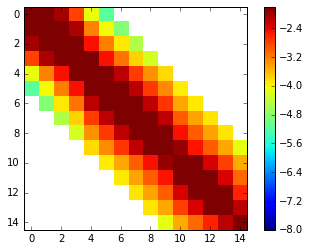

/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


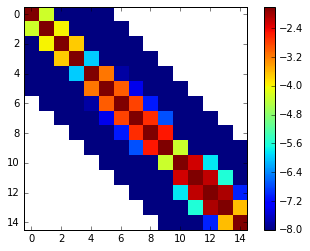

/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


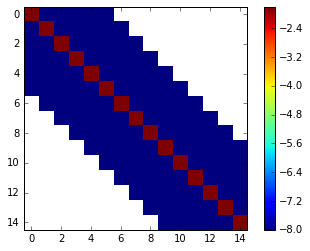

In [41]:
plt.figure()
plt.imshow(np.log(interp_matrix10)[0:15,0:15],vmin=-8,vmax=-1.8,interpolation='none')#,vmin=-20,vmax=1)
plt.imshow(np.log(-interp_matrix10)[0:15,0:15],vmin=-8,vmax=-1.8,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.log(interp_matrix100)[0:15,0:15],vmin=-8,vmax=-1.8,interpolation='none')
plt.imshow(np.log(-interp_matrix100)[0:15,0:15],vmin=-8,vmax=-1.8,interpolation='none')
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(np.log(interp_matrix1000)[0:15,0:15],vmin=-8,vmax=-1.8,interpolation='none')#,vmin=-20,vmax=1)
plt.imshow(np.log(-interp_matrix1000)[0:15,0:15],vmin=-8,vmax=-1.8,interpolation='none')
plt.colorbar()
plt.show()

/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


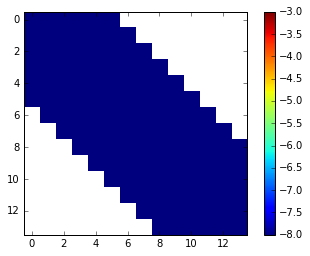

/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


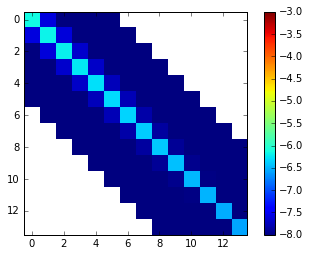

/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


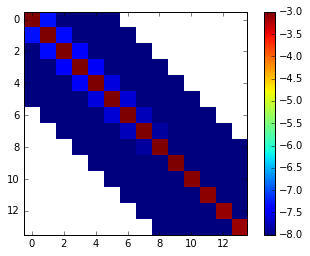

In [42]:
plt.figure()
plt.imshow(np.log(interp_matrix10)[-15:-1,-15:-1],vmin=-8,vmax=-3,interpolation='none')#,vmin=-20,vmax=1)
plt.imshow(np.log(-interp_matrix10)[-15:-1,-15:-1],vmin=-8,vmax=-3,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.log(interp_matrix100)[-15:-1,-15:-1],vmin=-8,vmax=-3,interpolation='none')
plt.imshow(np.log(-interp_matrix100)[-15:-1,-15:-1],vmin=-8,vmax=-3,interpolation='none')
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(np.log(interp_matrix1000)[-15:-1,-15:-1],vmin=-8,vmax=-3,interpolation='none')
plt.imshow(np.log(-interp_matrix1000)[-15:-1,-15:-1],vmin=-8,vmax=-3,interpolation='none')
plt.colorbar()
plt.show()

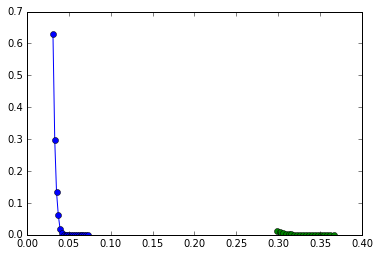

In [43]:
plt.plot(zs[0:20],abs(interp_matrix10[0,0:20]),marker='o')
plt.plot(zs[100:120],abs(interp_matrix10[100,100:120]),marker='o')

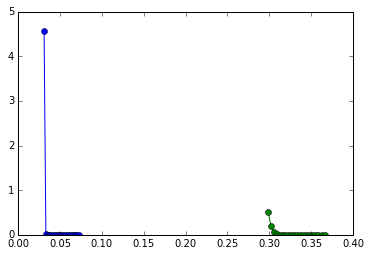

In [44]:
plt.plot(zs[0:20],abs(interp_matrix100[0,0:20]),marker='o')
plt.plot(zs[100:120],abs(interp_matrix100[100,100:120]),marker='o')

#plt.plot(abs(spline[0,0:20]),marker='^')
# plt.plot(spline[1,1:42],marker='^')
# plt.plot(spline[100,100:240],marker='^')

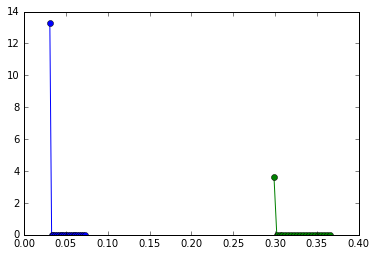

In [45]:
plt.plot(zs[0:20],abs(interp_matrix1000[0,0:20]),marker='o')
plt.plot(zs[100:120],abs(interp_matrix1000[100,100:120]),marker='o')

In [46]:
## Appending the first file with zeros to make all files the same size

# path
# fname = 'class_z000z020_cl.dat'
# cl = np.loadtxt(path + fname)
# fname = 'class_z010z030_cl.dat'
# clall = np.loadtxt(path + fname)
# clnew = np.zeros_like(clall)


# for i in range(cl.shape[1]):
#     clnew[:cl.shape[0], i] = cl[:, i]
    
# path
# fname = 'class_z000z020_cl.dat'
# # np.savetxt(path + fname, clnew)
# clcheck = np.loadtxt(path + fname)
# clcheck.shape

In [47]:
from BispectraMain import dNdz_LSST, simple_bias, gal_clus 

def simple_kernel(x,xmax):
    return (xmax-x)/x/xmax

In [48]:
LSST_bin = 'all'

In [49]:
W_g = gal_clus(b=simple_bias,bin_num=LSST_bin,cosmo=data, dNdz=dNdz_LSST)

using z-bin None norm 65.6723025802


In [50]:
W_l = simple_kernel

In [51]:
def Cl_psidelta(chi,z,L,cls,cosmo=data):
    return -cosmo.lens_prefac*(chi/L)**2*(1.+z)*cls/(L*(L+1.)/2./np.pi)

# lens_prefac is 1.5*self.H_0**2.*self.Omega_m0/(const.LIGHT_SPEED**2)

In [52]:
L_index = np.arange(0,100)
print(L_index)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]


In [53]:
clgg = []
clkk = []
clkg = []

for L_ind in [0,3,5,10,50,100,500,1000]:
    print(L_ind)
    LL = L[L_ind]
    matrix          = get_matrix_at_L(L_ind)
    weighted_matrix1 = W_g(chi1,zs1)*W_g(chi2,zs2)*matrix/(L[L_ind]*(L[L_ind]+1.)/2./np.pi)#Cl_psidelta(chi1,zs1,L[L_ind],matrix,cosmo=data)
    weighted_matrix2 = data.lens_prefac*chi1**2*(1.+zs1)*W_l(chi1,data.chi_cmb)*W_g(chi2,zs2)*matrix/(L[L_ind]*(L[L_ind]+1.)/2./np.pi)
    weighted_matrix3 = (data.lens_prefac*chi1**2*(1.+zs1))**2*W_l(chi1,data.chi_cmb)*W_l(chi1,data.chi_cmb)*matrix/(L[L_ind]*(L[L_ind]+1.)/2./np.pi)
    
    
    res1=[]
    res2=[]
    res3=[]
    for ii in range(len(chi)):
        res1+=[np.trapz(weighted_matrix1[ii],chi)]
        res2+=[np.trapz(weighted_matrix2[ii],chi)]
        res3+=[np.trapz(weighted_matrix3[ii],chi)]
    
    clgg+=[np.trapz(res1,chi)]
    clkk+=[np.trapz(res3,chi)]
    clkg+=[np.trapz(res2,chi)]
    
clgg = np.asarray(clgg)
clkk = np.asarray(clkk)
clkg = np.asarray(clkg)

0
0.970, 0.970, 0.970, 0.950
(0.96999999999999997, 0.97099999999999997)
0
(0, 0, (array([0]),))
0
0.970, 0.968, 0.970, 0.950
(0.96799999999999997, 0.97099999999999997)
0
(0, 1, (array([1]),))
0
0.970, 0.966, 0.970, 0.950
(0.96599999999999997, 0.97099999999999997)
0
(0, 2, (array([2]),))
0
0.970, 0.964, 0.970, 0.950
(0.96399999999999997, 0.97099999999999997)
0
(0, 3, (array([3]),))
0
0.970, 0.962, 0.970, 0.950
(0.96199999999999997, 0.97099999999999997)
0
(0, 4, (array([4]),))
0
0.970, 0.960, 0.970, 0.950
(0.95999999999999996, 0.97099999999999997)
0
(0, 5, (array([5]),))
0
0.968, 0.968, 0.970, 0.950
(0.96799999999999997, 0.97099999999999997)
0
(1, 1, (array([11]),))
0
0.968, 0.966, 0.970, 0.950
(0.96599999999999997, 0.97099999999999997)
0
(1, 2, (array([12]),))
0
0.968, 0.964, 0.970, 0.950
(0.96399999999999997, 0.97099999999999997)
0
(1, 3, (array([13]),))
0
0.968, 0.962, 0.970, 0.950
(0.96199999999999997, 0.97099999999999997)
0
(1, 4, (array([14]),))
0
0.968, 0.960, 0.970, 0.950
(0.9599

0
(1, 6, (array([16]),))
0.936, 0.936, 0.940, 0.920
(0.93599999999999994, 0.94099999999999995)
3
(2, 2, (array([21]),))
0
0.936, 0.934, 0.940, 0.920
(0.93399999999999994, 0.94099999999999995)
3
(2, 3, (array([22]),))
0
0.936, 0.932, 0.940, 0.920
(0.93199999999999994, 0.94099999999999995)
3
(2, 4, (array([23]),))
0
0.936, 0.930, 0.940, 0.920
(0.92999999999999994, 0.94099999999999995)
3
(2, 5, (array([24]),))
0
0.936, 0.928, 0.940, 0.920
(0.92799999999999994, 0.94099999999999995)
3
(2, 6, (array([25]),))
0
0.936, 0.926, 0.940, 0.920
(0.92599999999999993, 0.94099999999999995)
3
(2, 7, (array([26]),))
0
0.934, 0.934, 0.940, 0.920
(0.93399999999999994, 0.94099999999999995)
3
(3, 3, (array([30]),))
0
0.934, 0.932, 0.940, 0.920
(0.93199999999999994, 0.94099999999999995)
3
(3, 4, (array([31]),))
0
0.934, 0.930, 0.940, 0.920
(0.92999999999999994, 0.94099999999999995)
3
(3, 5, (array([32]),))
0
0.934, 0.928, 0.940, 0.920
(0.92799999999999994, 0.94099999999999995)
3
(3, 6, (array([33]),))
0
0.934

0
(1, 6, (array([16]),))
0.906, 0.906, 0.910, 0.890
(0.90599999999999992, 0.91100000000000003)
6
(2, 2, (array([21]),))
0
0.906, 0.904, 0.910, 0.890
(0.90399999999999991, 0.91100000000000003)
6
(2, 3, (array([22]),))
0
0.906, 0.902, 0.910, 0.890
(0.90199999999999991, 0.91100000000000003)
6
(2, 4, (array([23]),))
0
0.906, 0.900, 0.910, 0.890
(0.89999999999999991, 0.91100000000000003)
6
(2, 5, (array([24]),))
0
0.906, 0.898, 0.910, 0.890
(0.89799999999999991, 0.91100000000000003)
6
(2, 6, (array([25]),))
0
0.906, 0.896, 0.910, 0.890
(0.89599999999999991, 0.91100000000000003)
6
(2, 7, (array([26]),))
0
0.904, 0.904, 0.910, 0.890
(0.90399999999999991, 0.91100000000000003)
6
(3, 3, (array([30]),))
0
0.904, 0.902, 0.910, 0.890
(0.90199999999999991, 0.91100000000000003)
6
(3, 4, (array([31]),))
0
0.904, 0.900, 0.910, 0.890
(0.89999999999999991, 0.91100000000000003)
6
(3, 5, (array([32]),))
0
0.904, 0.898, 0.910, 0.890
(0.89799999999999991, 0.91100000000000003)
6
(3, 6, (array([33]),))
0
0.904

0
(1, 6, (array([16]),))
0.866, 0.866, 0.870, 0.850
(0.86599999999999988, 0.871)
10
(2, 2, (array([21]),))
0
0.866, 0.864, 0.870, 0.850
(0.86399999999999988, 0.871)
10
(2, 3, (array([22]),))
0
0.866, 0.862, 0.870, 0.850
(0.86199999999999988, 0.871)
10
(2, 4, (array([23]),))
0
0.866, 0.860, 0.870, 0.850
(0.85999999999999988, 0.871)
10
(2, 5, (array([24]),))
0
0.866, 0.858, 0.870, 0.850
(0.85799999999999987, 0.871)
10
(2, 6, (array([25]),))
0
0.866, 0.856, 0.870, 0.850
(0.85599999999999987, 0.871)
10
(2, 7, (array([26]),))
0
0.864, 0.864, 0.870, 0.850
(0.86399999999999988, 0.871)
10
(3, 3, (array([30]),))
0
0.864, 0.862, 0.870, 0.850
(0.86199999999999988, 0.871)
10
(3, 4, (array([31]),))
0
0.864, 0.860, 0.870, 0.850
(0.85999999999999988, 0.871)
10
(3, 5, (array([32]),))
0
0.864, 0.858, 0.870, 0.850
(0.85799999999999987, 0.871)
10
(3, 6, (array([33]),))
0
0.864, 0.856, 0.870, 0.850
(0.85599999999999987, 0.871)
10
(3, 7, (array([34]),))
0
0.864, 0.854, 0.870, 0.850
(0.85399999999999987, 0.

0
(1, 6, (array([16]),))
0.826, 0.826, 0.830, 0.810
(0.82599999999999985, 0.83099999999999996)
14
(2, 2, (array([21]),))
0
0.826, 0.824, 0.830, 0.810
(0.82399999999999984, 0.83099999999999996)
14
(2, 3, (array([22]),))
0
0.826, 0.822, 0.830, 0.810
(0.82199999999999984, 0.83099999999999996)
14
(2, 4, (array([23]),))
0
0.826, 0.820, 0.830, 0.810
(0.81999999999999984, 0.83099999999999996)
14
(2, 5, (array([24]),))
0
0.826, 0.818, 0.830, 0.810
(0.81799999999999984, 0.83099999999999996)
14
(2, 6, (array([25]),))
0
0.826, 0.816, 0.830, 0.810
(0.81599999999999984, 0.83099999999999996)
14
(2, 7, (array([26]),))
0
0.824, 0.824, 0.830, 0.810
(0.82399999999999984, 0.83099999999999996)
14
(3, 3, (array([30]),))
0
0.824, 0.822, 0.830, 0.810
(0.82199999999999984, 0.83099999999999996)
14
(3, 4, (array([31]),))
0
0.824, 0.820, 0.830, 0.810
(0.81999999999999984, 0.83099999999999996)
14
(3, 5, (array([32]),))
0
0.824, 0.818, 0.830, 0.810
(0.81799999999999984, 0.83099999999999996)
14
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.786, 0.786, 0.790, 0.770
(0.78599999999999981, 0.79100000000000004)
18
(2, 2, (array([21]),))
0
0.786, 0.784, 0.790, 0.770
(0.78399999999999981, 0.79100000000000004)
18
(2, 3, (array([22]),))
0
0.786, 0.782, 0.790, 0.770
(0.78199999999999981, 0.79100000000000004)
18
(2, 4, (array([23]),))
0
0.786, 0.780, 0.790, 0.770
(0.7799999999999998, 0.79100000000000004)
18
(2, 5, (array([24]),))
0
0.786, 0.778, 0.790, 0.770
(0.7779999999999998, 0.79100000000000004)
18
(2, 6, (array([25]),))
0
0.786, 0.776, 0.790, 0.770
(0.7759999999999998, 0.79100000000000004)
18
(2, 7, (array([26]),))
0
0.784, 0.784, 0.790, 0.770
(0.78399999999999981, 0.79100000000000004)
18
(3, 3, (array([30]),))
0
0.784, 0.782, 0.790, 0.770
(0.78199999999999981, 0.79100000000000004)
18
(3, 4, (array([31]),))
0
0.784, 0.780, 0.790, 0.770
(0.7799999999999998, 0.79100000000000004)
18
(3, 5, (array([32]),))
0
0.784, 0.778, 0.790, 0.770
(0.7779999999999998, 0.79100000000000004)
18
(3, 6, (array([33]),))
0


0
(1, 6, (array([16]),))
0.746, 0.746, 0.750, 0.730
(0.74599999999999977, 0.751)
22
(2, 2, (array([21]),))
0
0.746, 0.744, 0.750, 0.730
(0.74399999999999977, 0.751)
22
(2, 3, (array([22]),))
0
0.746, 0.742, 0.750, 0.730
(0.74199999999999977, 0.751)
22
(2, 4, (array([23]),))
0
0.746, 0.740, 0.750, 0.730
(0.73999999999999977, 0.751)
22
(2, 5, (array([24]),))
0
0.746, 0.738, 0.750, 0.730
(0.73799999999999977, 0.751)
22
(2, 6, (array([25]),))
0
0.746, 0.736, 0.750, 0.730
(0.73599999999999977, 0.751)
22
(2, 7, (array([26]),))
0
0.744, 0.744, 0.750, 0.730
(0.74399999999999977, 0.751)
22
(3, 3, (array([30]),))
0
0.744, 0.742, 0.750, 0.730
(0.74199999999999977, 0.751)
22
(3, 4, (array([31]),))
0
0.744, 0.740, 0.750, 0.730
(0.73999999999999977, 0.751)
22
(3, 5, (array([32]),))
0
0.744, 0.738, 0.750, 0.730
(0.73799999999999977, 0.751)
22
(3, 6, (array([33]),))
0
0.744, 0.736, 0.750, 0.730
(0.73599999999999977, 0.751)
22
(3, 7, (array([34]),))
0
0.744, 0.734, 0.750, 0.730
(0.73399999999999976, 0.

0
(1, 6, (array([16]),))
0.706, 0.706, 0.710, 0.690
(0.70599999999999974, 0.71099999999999997)
26
(2, 2, (array([21]),))
0
0.706, 0.704, 0.710, 0.690
(0.70399999999999974, 0.71099999999999997)
26
(2, 3, (array([22]),))
0
0.706, 0.702, 0.710, 0.690
(0.70199999999999974, 0.71099999999999997)
26
(2, 4, (array([23]),))
0
0.706, 0.700, 0.710, 0.690
(0.69999999999999973, 0.71099999999999997)
26
(2, 5, (array([24]),))
0
0.706, 0.698, 0.710, 0.690
(0.69799999999999973, 0.71099999999999997)
26
(2, 6, (array([25]),))
0
0.706, 0.696, 0.710, 0.690
(0.69599999999999973, 0.71099999999999997)
26
(2, 7, (array([26]),))
0
0.704, 0.704, 0.710, 0.690
(0.70399999999999974, 0.71099999999999997)
26
(3, 3, (array([30]),))
0
0.704, 0.702, 0.710, 0.690
(0.70199999999999974, 0.71099999999999997)
26
(3, 4, (array([31]),))
0
0.704, 0.700, 0.710, 0.690
(0.69999999999999973, 0.71099999999999997)
26
(3, 5, (array([32]),))
0
0.704, 0.698, 0.710, 0.690
(0.69799999999999973, 0.71099999999999997)
26
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.666, 0.666, 0.670, 0.650
(0.6659999999999997, 0.67100000000000004)
30
(2, 2, (array([21]),))
0
0.666, 0.664, 0.670, 0.650
(0.6639999999999997, 0.67100000000000004)
30
(2, 3, (array([22]),))
0
0.666, 0.662, 0.670, 0.650
(0.6619999999999997, 0.67100000000000004)
30
(2, 4, (array([23]),))
0
0.666, 0.660, 0.670, 0.650
(0.6599999999999997, 0.67100000000000004)
30
(2, 5, (array([24]),))
0
0.666, 0.658, 0.670, 0.650
(0.6579999999999997, 0.67100000000000004)
30
(2, 6, (array([25]),))
0
0.666, 0.656, 0.670, 0.650
(0.65599999999999969, 0.67100000000000004)
30
(2, 7, (array([26]),))
0
0.664, 0.664, 0.670, 0.650
(0.6639999999999997, 0.67100000000000004)
30
(3, 3, (array([30]),))
0
0.664, 0.662, 0.670, 0.650
(0.6619999999999997, 0.67100000000000004)
30
(3, 4, (array([31]),))
0
0.664, 0.660, 0.670, 0.650
(0.6599999999999997, 0.67100000000000004)
30
(3, 5, (array([32]),))
0
0.664, 0.658, 0.670, 0.650
(0.6579999999999997, 0.67100000000000004)
30
(3, 6, (array([33]),))
0
0.66

0
(1, 6, (array([16]),))
0.626, 0.626, 0.630, 0.610
(0.62599999999999967, 0.63100000000000001)
34
(2, 2, (array([21]),))
0
0.626, 0.624, 0.630, 0.610
(0.62399999999999967, 0.63100000000000001)
34
(2, 3, (array([22]),))
0
0.626, 0.622, 0.630, 0.610
(0.62199999999999966, 0.63100000000000001)
34
(2, 4, (array([23]),))
0
0.626, 0.620, 0.630, 0.610
(0.61999999999999966, 0.63100000000000001)
34
(2, 5, (array([24]),))
0
0.626, 0.618, 0.630, 0.610
(0.61799999999999966, 0.63100000000000001)
34
(2, 6, (array([25]),))
0
0.626, 0.616, 0.630, 0.610
(0.61599999999999966, 0.63100000000000001)
34
(2, 7, (array([26]),))
0
0.624, 0.624, 0.630, 0.610
(0.62399999999999967, 0.63100000000000001)
34
(3, 3, (array([30]),))
0
0.624, 0.622, 0.630, 0.610
(0.62199999999999966, 0.63100000000000001)
34
(3, 4, (array([31]),))
0
0.624, 0.620, 0.630, 0.610
(0.61999999999999966, 0.63100000000000001)
34
(3, 5, (array([32]),))
0
0.624, 0.618, 0.630, 0.610
(0.61799999999999966, 0.63100000000000001)
34
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.586, 0.586, 0.590, 0.570
(0.58599999999999963, 0.59099999999999997)
38
(2, 2, (array([21]),))
0
0.586, 0.584, 0.590, 0.570
(0.58399999999999963, 0.59099999999999997)
38
(2, 3, (array([22]),))
0
0.586, 0.582, 0.590, 0.570
(0.58199999999999963, 0.59099999999999997)
38
(2, 4, (array([23]),))
0
0.586, 0.580, 0.590, 0.570
(0.57999999999999963, 0.59099999999999997)
38
(2, 5, (array([24]),))
0
0.586, 0.578, 0.590, 0.570
(0.57799999999999963, 0.59099999999999997)
38
(2, 6, (array([25]),))
0
0.586, 0.576, 0.590, 0.570
(0.57599999999999962, 0.59099999999999997)
38
(2, 7, (array([26]),))
0
0.584, 0.584, 0.590, 0.570
(0.58399999999999963, 0.59099999999999997)
38
(3, 3, (array([30]),))
0
0.584, 0.582, 0.590, 0.570
(0.58199999999999963, 0.59099999999999997)
38
(3, 4, (array([31]),))
0
0.584, 0.580, 0.590, 0.570
(0.57999999999999963, 0.59099999999999997)
38
(3, 5, (array([32]),))
0
0.584, 0.578, 0.590, 0.570
(0.57799999999999963, 0.59099999999999997)
38
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.546, 0.546, 0.550, 0.530
(0.5459999999999996, 0.55100000000000005)
42
(2, 2, (array([21]),))
0
0.546, 0.544, 0.550, 0.530
(0.54399999999999959, 0.55100000000000005)
42
(2, 3, (array([22]),))
0
0.546, 0.542, 0.550, 0.530
(0.54199999999999959, 0.55100000000000005)
42
(2, 4, (array([23]),))
0
0.546, 0.540, 0.550, 0.530
(0.53999999999999959, 0.55100000000000005)
42
(2, 5, (array([24]),))
0
0.546, 0.538, 0.550, 0.530
(0.53799999999999959, 0.55100000000000005)
42
(2, 6, (array([25]),))
0
0.546, 0.536, 0.550, 0.530
(0.53599999999999959, 0.55100000000000005)
42
(2, 7, (array([26]),))
0
0.544, 0.544, 0.550, 0.530
(0.54399999999999959, 0.55100000000000005)
42
(3, 3, (array([30]),))
0
0.544, 0.542, 0.550, 0.530
(0.54199999999999959, 0.55100000000000005)
42
(3, 4, (array([31]),))
0
0.544, 0.540, 0.550, 0.530
(0.53999999999999959, 0.55100000000000005)
42
(3, 5, (array([32]),))
0
0.544, 0.538, 0.550, 0.530
(0.53799999999999959, 0.55100000000000005)
42
(3, 6, (array([33]),)

0
(1, 6, (array([16]),))
0.506, 0.506, 0.510, 0.490
(0.50599999999999956, 0.51100000000000001)
46
(2, 2, (array([21]),))
0
0.506, 0.504, 0.510, 0.490
(0.50399999999999956, 0.51100000000000001)
46
(2, 3, (array([22]),))
0
0.506, 0.502, 0.510, 0.490
(0.50199999999999956, 0.51100000000000001)
46
(2, 4, (array([23]),))
0
0.506, 0.500, 0.510, 0.490
(0.49999999999999956, 0.51100000000000001)
46
(2, 5, (array([24]),))
0
0.506, 0.498, 0.510, 0.490
(0.49799999999999955, 0.51100000000000001)
46
(2, 6, (array([25]),))
0
0.506, 0.496, 0.510, 0.490
(0.49599999999999955, 0.51100000000000001)
46
(2, 7, (array([26]),))
0
0.504, 0.504, 0.510, 0.490
(0.50399999999999956, 0.51100000000000001)
46
(3, 3, (array([30]),))
0
0.504, 0.502, 0.510, 0.490
(0.50199999999999956, 0.51100000000000001)
46
(3, 4, (array([31]),))
0
0.504, 0.500, 0.510, 0.490
(0.49999999999999956, 0.51100000000000001)
46
(3, 5, (array([32]),))
0
0.504, 0.498, 0.510, 0.490
(0.49799999999999955, 0.51100000000000001)
46
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.466, 0.466, 0.470, 0.450
(0.46599999999999953, 0.47099999999999997)
50
(2, 2, (array([21]),))
0
0.466, 0.464, 0.470, 0.450
(0.46399999999999952, 0.47099999999999997)
50
(2, 3, (array([22]),))
0
0.466, 0.462, 0.470, 0.450
(0.46199999999999952, 0.47099999999999997)
50
(2, 4, (array([23]),))
0
0.466, 0.460, 0.470, 0.450
(0.45999999999999952, 0.47099999999999997)
50
(2, 5, (array([24]),))
0
0.466, 0.458, 0.470, 0.450
(0.45799999999999952, 0.47099999999999997)
50
(2, 6, (array([25]),))
0
0.466, 0.456, 0.470, 0.450
(0.45599999999999952, 0.47099999999999997)
50
(2, 7, (array([26]),))
0
0.464, 0.464, 0.470, 0.450
(0.46399999999999952, 0.47099999999999997)
50
(3, 3, (array([30]),))
0
0.464, 0.462, 0.470, 0.450
(0.46199999999999952, 0.47099999999999997)
50
(3, 4, (array([31]),))
0
0.464, 0.460, 0.470, 0.450
(0.45999999999999952, 0.47099999999999997)
50
(3, 5, (array([32]),))
0
0.464, 0.458, 0.470, 0.450
(0.45799999999999952, 0.47099999999999997)
50
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.426, 0.426, 0.430, 0.410
(0.42599999999999949, 0.43099999999999999)
54
(2, 2, (array([21]),))
0
0.426, 0.424, 0.430, 0.410
(0.42399999999999949, 0.43099999999999999)
54
(2, 3, (array([22]),))
0
0.426, 0.422, 0.430, 0.410
(0.42199999999999949, 0.43099999999999999)
54
(2, 4, (array([23]),))
0
0.426, 0.420, 0.430, 0.410
(0.41999999999999948, 0.43099999999999999)
54
(2, 5, (array([24]),))
0
0.426, 0.418, 0.430, 0.410
(0.41799999999999948, 0.43099999999999999)
54
(2, 6, (array([25]),))
0
0.426, 0.416, 0.430, 0.410
(0.41599999999999948, 0.43099999999999999)
54
(2, 7, (array([26]),))
0
0.424, 0.424, 0.430, 0.410
(0.42399999999999949, 0.43099999999999999)
54
(3, 3, (array([30]),))
0
0.424, 0.422, 0.430, 0.410
(0.42199999999999949, 0.43099999999999999)
54
(3, 4, (array([31]),))
0
0.424, 0.420, 0.430, 0.410
(0.41999999999999948, 0.43099999999999999)
54
(3, 5, (array([32]),))
0
0.424, 0.418, 0.430, 0.410
(0.41799999999999948, 0.43099999999999999)
54
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.386, 0.386, 0.390, 0.370
(0.38599999999999945, 0.39100000000000001)
58
(2, 2, (array([21]),))
0
0.386, 0.384, 0.390, 0.370
(0.38399999999999945, 0.39100000000000001)
58
(2, 3, (array([22]),))
0
0.386, 0.382, 0.390, 0.370
(0.38199999999999945, 0.39100000000000001)
58
(2, 4, (array([23]),))
0
0.386, 0.380, 0.390, 0.370
(0.37999999999999945, 0.39100000000000001)
58
(2, 5, (array([24]),))
0
0.386, 0.378, 0.390, 0.370
(0.37799999999999945, 0.39100000000000001)
58
(2, 6, (array([25]),))
0
0.386, 0.376, 0.390, 0.370
(0.37599999999999945, 0.39100000000000001)
58
(2, 7, (array([26]),))
0
0.384, 0.384, 0.390, 0.370
(0.38399999999999945, 0.39100000000000001)
58
(3, 3, (array([30]),))
0
0.384, 0.382, 0.390, 0.370
(0.38199999999999945, 0.39100000000000001)
58
(3, 4, (array([31]),))
0
0.384, 0.380, 0.390, 0.370
(0.37999999999999945, 0.39100000000000001)
58
(3, 5, (array([32]),))
0
0.384, 0.378, 0.390, 0.370
(0.37799999999999945, 0.39100000000000001)
58
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.346, 0.346, 0.350, 0.330
(0.34599999999999942, 0.35099999999999998)
62
(2, 2, (array([21]),))
0
0.346, 0.344, 0.350, 0.330
(0.34399999999999942, 0.35099999999999998)
62
(2, 3, (array([22]),))
0
0.346, 0.342, 0.350, 0.330
(0.34199999999999942, 0.35099999999999998)
62
(2, 4, (array([23]),))
0
0.346, 0.340, 0.350, 0.330
(0.33999999999999941, 0.35099999999999998)
62
(2, 5, (array([24]),))
0
0.346, 0.338, 0.350, 0.330
(0.33799999999999941, 0.35099999999999998)
62
(2, 6, (array([25]),))
0
0.346, 0.336, 0.350, 0.330
(0.33599999999999941, 0.35099999999999998)
62
(2, 7, (array([26]),))
0
0.344, 0.344, 0.350, 0.330
(0.34399999999999942, 0.35099999999999998)
62
(3, 3, (array([30]),))
0
0.344, 0.342, 0.350, 0.330
(0.34199999999999942, 0.35099999999999998)
62
(3, 4, (array([31]),))
0
0.344, 0.340, 0.350, 0.330
(0.33999999999999941, 0.35099999999999998)
62
(3, 5, (array([32]),))
0
0.344, 0.338, 0.350, 0.330
(0.33799999999999941, 0.35099999999999998)
62
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.306, 0.306, 0.310, 0.290
(0.30599999999999938, 0.311)
66
(2, 2, (array([21]),))
0
0.306, 0.304, 0.310, 0.290
(0.30399999999999938, 0.311)
66
(2, 3, (array([22]),))
0
0.306, 0.302, 0.310, 0.290
(0.30199999999999938, 0.311)
66
(2, 4, (array([23]),))
0
0.306, 0.300, 0.310, 0.290
(0.29999999999999938, 0.311)
66
(2, 5, (array([24]),))
0
0.306, 0.298, 0.310, 0.290
(0.29799999999999938, 0.311)
66
(2, 6, (array([25]),))
0
0.306, 0.296, 0.310, 0.290
(0.29599999999999937, 0.311)
66
(2, 7, (array([26]),))
0
0.304, 0.304, 0.310, 0.290
(0.30399999999999938, 0.311)
66
(3, 3, (array([30]),))
0
0.304, 0.302, 0.310, 0.290
(0.30199999999999938, 0.311)
66
(3, 4, (array([31]),))
0
0.304, 0.300, 0.310, 0.290
(0.29999999999999938, 0.311)
66
(3, 5, (array([32]),))
0
0.304, 0.298, 0.310, 0.290
(0.29799999999999938, 0.311)
66
(3, 6, (array([33]),))
0
0.304, 0.296, 0.310, 0.290
(0.29599999999999937, 0.311)
66
(3, 7, (array([34]),))
0
0.304, 0.294, 0.310, 0.290
(0.29399999999999937, 0.

0
(1, 6, (array([16]),))
0.266, 0.266, 0.270, 0.250
(0.26599999999999935, 0.27100000000000002)
70
(2, 2, (array([21]),))
0
0.266, 0.264, 0.270, 0.250
(0.26399999999999935, 0.27100000000000002)
70
(2, 3, (array([22]),))
0
0.266, 0.262, 0.270, 0.250
(0.26199999999999934, 0.27100000000000002)
70
(2, 4, (array([23]),))
0
0.266, 0.260, 0.270, 0.250
(0.25999999999999934, 0.27100000000000002)
70
(2, 5, (array([24]),))
0
0.266, 0.258, 0.270, 0.250
(0.25799999999999934, 0.27100000000000002)
70
(2, 6, (array([25]),))
0
0.266, 0.256, 0.270, 0.250
(0.25599999999999934, 0.27100000000000002)
70
(2, 7, (array([26]),))
0
0.264, 0.264, 0.270, 0.250
(0.26399999999999935, 0.27100000000000002)
70
(3, 3, (array([30]),))
0
0.264, 0.262, 0.270, 0.250
(0.26199999999999934, 0.27100000000000002)
70
(3, 4, (array([31]),))
0
0.264, 0.260, 0.270, 0.250
(0.25999999999999934, 0.27100000000000002)
70
(3, 5, (array([32]),))
0
0.264, 0.258, 0.270, 0.250
(0.25799999999999934, 0.27100000000000002)
70
(3, 6, (array([33]),

0
(1, 6, (array([16]),))
0.226, 0.226, 0.230, 0.210
(0.22599999999999931, 0.23100000000000001)
74
(2, 2, (array([21]),))
0
0.226, 0.224, 0.230, 0.210
(0.22399999999999931, 0.23100000000000001)
74
(2, 3, (array([22]),))
0
0.226, 0.222, 0.230, 0.210
(0.22199999999999931, 0.23100000000000001)
74
(2, 4, (array([23]),))
0
0.226, 0.220, 0.230, 0.210
(0.21999999999999931, 0.23100000000000001)
74
(2, 5, (array([24]),))
0
0.226, 0.218, 0.230, 0.210
(0.21799999999999931, 0.23100000000000001)
74
(2, 6, (array([25]),))
0
0.226, 0.216, 0.230, 0.210
(0.2159999999999993, 0.23100000000000001)
74
(2, 7, (array([26]),))
0
0.224, 0.224, 0.230, 0.210
(0.22399999999999931, 0.23100000000000001)
74
(3, 3, (array([30]),))
0
0.224, 0.222, 0.230, 0.210
(0.22199999999999931, 0.23100000000000001)
74
(3, 4, (array([31]),))
0
0.224, 0.220, 0.230, 0.210
(0.21999999999999931, 0.23100000000000001)
74
(3, 5, (array([32]),))
0
0.224, 0.218, 0.230, 0.210
(0.21799999999999931, 0.23100000000000001)
74
(3, 6, (array([33]),)

0
(1, 6, (array([16]),))
0.186, 0.186, 0.190, 0.170
(0.18599999999999928, 0.191)
78
(2, 2, (array([21]),))
0
0.186, 0.184, 0.190, 0.170
(0.18399999999999928, 0.191)
78
(2, 3, (array([22]),))
0
0.186, 0.182, 0.190, 0.170
(0.18199999999999927, 0.191)
78
(2, 4, (array([23]),))
0
0.186, 0.180, 0.190, 0.170
(0.17999999999999927, 0.191)
78
(2, 5, (array([24]),))
0
0.186, 0.178, 0.190, 0.170
(0.17799999999999927, 0.191)
78
(2, 6, (array([25]),))
0
0.186, 0.176, 0.190, 0.170
(0.17599999999999927, 0.191)
78
(2, 7, (array([26]),))
0
0.184, 0.184, 0.190, 0.170
(0.18399999999999928, 0.191)
78
(3, 3, (array([30]),))
0
0.184, 0.182, 0.190, 0.170
(0.18199999999999927, 0.191)
78
(3, 4, (array([31]),))
0
0.184, 0.180, 0.190, 0.170
(0.17999999999999927, 0.191)
78
(3, 5, (array([32]),))
0
0.184, 0.178, 0.190, 0.170
(0.17799999999999927, 0.191)
78
(3, 6, (array([33]),))
0
0.184, 0.176, 0.190, 0.170
(0.17599999999999927, 0.191)
78
(3, 7, (array([34]),))
0
0.184, 0.174, 0.190, 0.170
(0.17399999999999927, 0.

3
(1, 6, (array([16]),))
0.956, 0.956, 0.960, 0.940
(0.95599999999999996, 0.96099999999999997)
1
(2, 2, (array([21]),))
3
0.956, 0.954, 0.960, 0.940
(0.95399999999999996, 0.96099999999999997)
1
(2, 3, (array([22]),))
3
0.956, 0.952, 0.960, 0.940
(0.95199999999999996, 0.96099999999999997)
1
(2, 4, (array([23]),))
3
0.956, 0.950, 0.960, 0.940
(0.94999999999999996, 0.96099999999999997)
1
(2, 5, (array([24]),))
3
0.956, 0.948, 0.960, 0.940
(0.94799999999999995, 0.96099999999999997)
1
(2, 6, (array([25]),))
3
0.956, 0.946, 0.960, 0.940
(0.94599999999999995, 0.96099999999999997)
1
(2, 7, (array([26]),))
3
0.954, 0.954, 0.960, 0.940
(0.95399999999999996, 0.96099999999999997)
1
(3, 3, (array([30]),))
3
0.954, 0.952, 0.960, 0.940
(0.95199999999999996, 0.96099999999999997)
1
(3, 4, (array([31]),))
3
0.954, 0.950, 0.960, 0.940
(0.94999999999999996, 0.96099999999999997)
1
(3, 5, (array([32]),))
3
0.954, 0.948, 0.960, 0.940
(0.94799999999999995, 0.96099999999999997)
1
(3, 6, (array([33]),))
3
0.954

3
(1, 6, (array([16]),))
0.916, 0.916, 0.920, 0.900
(0.91599999999999993, 0.92100000000000004)
5
(2, 2, (array([21]),))
3
0.916, 0.914, 0.920, 0.900
(0.91399999999999992, 0.92100000000000004)
5
(2, 3, (array([22]),))
3
0.916, 0.912, 0.920, 0.900
(0.91199999999999992, 0.92100000000000004)
5
(2, 4, (array([23]),))
3
0.916, 0.910, 0.920, 0.900
(0.90999999999999992, 0.92100000000000004)
5
(2, 5, (array([24]),))
3
0.916, 0.908, 0.920, 0.900
(0.90799999999999992, 0.92100000000000004)
5
(2, 6, (array([25]),))
3
0.916, 0.906, 0.920, 0.900
(0.90599999999999992, 0.92100000000000004)
5
(2, 7, (array([26]),))
3
0.914, 0.914, 0.920, 0.900
(0.91399999999999992, 0.92100000000000004)
5
(3, 3, (array([30]),))
3
0.914, 0.912, 0.920, 0.900
(0.91199999999999992, 0.92100000000000004)
5
(3, 4, (array([31]),))
3
0.914, 0.910, 0.920, 0.900
(0.90999999999999992, 0.92100000000000004)
5
(3, 5, (array([32]),))
3
0.914, 0.908, 0.920, 0.900
(0.90799999999999992, 0.92100000000000004)
5
(3, 6, (array([33]),))
3
0.914

3
(1, 6, (array([16]),))
0.876, 0.876, 0.880, 0.860
(0.87599999999999989, 0.88100000000000001)
9
(2, 2, (array([21]),))
3
0.876, 0.874, 0.880, 0.860
(0.87399999999999989, 0.88100000000000001)
9
(2, 3, (array([22]),))
3
0.876, 0.872, 0.880, 0.860
(0.87199999999999989, 0.88100000000000001)
9
(2, 4, (array([23]),))
3
0.876, 0.870, 0.880, 0.860
(0.86999999999999988, 0.88100000000000001)
9
(2, 5, (array([24]),))
3
0.876, 0.868, 0.880, 0.860
(0.86799999999999988, 0.88100000000000001)
9
(2, 6, (array([25]),))
3
0.876, 0.866, 0.880, 0.860
(0.86599999999999988, 0.88100000000000001)
9
(2, 7, (array([26]),))
3
0.874, 0.874, 0.880, 0.860
(0.87399999999999989, 0.88100000000000001)
9
(3, 3, (array([30]),))
3
0.874, 0.872, 0.880, 0.860
(0.87199999999999989, 0.88100000000000001)
9
(3, 4, (array([31]),))
3
0.874, 0.870, 0.880, 0.860
(0.86999999999999988, 0.88100000000000001)
9
(3, 5, (array([32]),))
3
0.874, 0.868, 0.880, 0.860
(0.86799999999999988, 0.88100000000000001)
9
(3, 6, (array([33]),))
3
0.874

3
(1, 6, (array([16]),))
0.836, 0.836, 0.840, 0.820
(0.83599999999999985, 0.84099999999999997)
13
(2, 2, (array([21]),))
3
0.836, 0.834, 0.840, 0.820
(0.83399999999999985, 0.84099999999999997)
13
(2, 3, (array([22]),))
3
0.836, 0.832, 0.840, 0.820
(0.83199999999999985, 0.84099999999999997)
13
(2, 4, (array([23]),))
3
0.836, 0.830, 0.840, 0.820
(0.82999999999999985, 0.84099999999999997)
13
(2, 5, (array([24]),))
3
0.836, 0.828, 0.840, 0.820
(0.82799999999999985, 0.84099999999999997)
13
(2, 6, (array([25]),))
3
0.836, 0.826, 0.840, 0.820
(0.82599999999999985, 0.84099999999999997)
13
(2, 7, (array([26]),))
3
0.834, 0.834, 0.840, 0.820
(0.83399999999999985, 0.84099999999999997)
13
(3, 3, (array([30]),))
3
0.834, 0.832, 0.840, 0.820
(0.83199999999999985, 0.84099999999999997)
13
(3, 4, (array([31]),))
3
0.834, 0.830, 0.840, 0.820
(0.82999999999999985, 0.84099999999999997)
13
(3, 5, (array([32]),))
3
0.834, 0.828, 0.840, 0.820
(0.82799999999999985, 0.84099999999999997)
13
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.796, 0.796, 0.800, 0.780
(0.79599999999999982, 0.80100000000000005)
17
(2, 2, (array([21]),))
3
0.796, 0.794, 0.800, 0.780
(0.79399999999999982, 0.80100000000000005)
17
(2, 3, (array([22]),))
3
0.796, 0.792, 0.800, 0.780
(0.79199999999999982, 0.80100000000000005)
17
(2, 4, (array([23]),))
3
0.796, 0.790, 0.800, 0.780
(0.78999999999999981, 0.80100000000000005)
17
(2, 5, (array([24]),))
3
0.796, 0.788, 0.800, 0.780
(0.78799999999999981, 0.80100000000000005)
17
(2, 6, (array([25]),))
3
0.796, 0.786, 0.800, 0.780
(0.78599999999999981, 0.80100000000000005)
17
(2, 7, (array([26]),))
3
0.794, 0.794, 0.800, 0.780
(0.79399999999999982, 0.80100000000000005)
17
(3, 3, (array([30]),))
3
0.794, 0.792, 0.800, 0.780
(0.79199999999999982, 0.80100000000000005)
17
(3, 4, (array([31]),))
3
0.794, 0.790, 0.800, 0.780
(0.78999999999999981, 0.80100000000000005)
17
(3, 5, (array([32]),))
3
0.794, 0.788, 0.800, 0.780
(0.78799999999999981, 0.80100000000000005)
17
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.756, 0.756, 0.760, 0.740
(0.75599999999999978, 0.76100000000000001)
21
(2, 2, (array([21]),))
3
0.756, 0.754, 0.760, 0.740
(0.75399999999999978, 0.76100000000000001)
21
(2, 3, (array([22]),))
3
0.756, 0.752, 0.760, 0.740
(0.75199999999999978, 0.76100000000000001)
21
(2, 4, (array([23]),))
3
0.756, 0.750, 0.760, 0.740
(0.74999999999999978, 0.76100000000000001)
21
(2, 5, (array([24]),))
3
0.756, 0.748, 0.760, 0.740
(0.74799999999999978, 0.76100000000000001)
21
(2, 6, (array([25]),))
3
0.756, 0.746, 0.760, 0.740
(0.74599999999999977, 0.76100000000000001)
21
(2, 7, (array([26]),))
3
0.754, 0.754, 0.760, 0.740
(0.75399999999999978, 0.76100000000000001)
21
(3, 3, (array([30]),))
3
0.754, 0.752, 0.760, 0.740
(0.75199999999999978, 0.76100000000000001)
21
(3, 4, (array([31]),))
3
0.754, 0.750, 0.760, 0.740
(0.74999999999999978, 0.76100000000000001)
21
(3, 5, (array([32]),))
3
0.754, 0.748, 0.760, 0.740
(0.74799999999999978, 0.76100000000000001)
21
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.716, 0.716, 0.720, 0.700
(0.71599999999999975, 0.72099999999999997)
25
(2, 2, (array([21]),))
3
0.716, 0.714, 0.720, 0.700
(0.71399999999999975, 0.72099999999999997)
25
(2, 3, (array([22]),))
3
0.716, 0.712, 0.720, 0.700
(0.71199999999999974, 0.72099999999999997)
25
(2, 4, (array([23]),))
3
0.716, 0.710, 0.720, 0.700
(0.70999999999999974, 0.72099999999999997)
25
(2, 5, (array([24]),))
3
0.716, 0.708, 0.720, 0.700
(0.70799999999999974, 0.72099999999999997)
25
(2, 6, (array([25]),))
3
0.716, 0.706, 0.720, 0.700
(0.70599999999999974, 0.72099999999999997)
25
(2, 7, (array([26]),))
3
0.714, 0.714, 0.720, 0.700
(0.71399999999999975, 0.72099999999999997)
25
(3, 3, (array([30]),))
3
0.714, 0.712, 0.720, 0.700
(0.71199999999999974, 0.72099999999999997)
25
(3, 4, (array([31]),))
3
0.714, 0.710, 0.720, 0.700
(0.70999999999999974, 0.72099999999999997)
25
(3, 5, (array([32]),))
3
0.714, 0.708, 0.720, 0.700
(0.70799999999999974, 0.72099999999999997)
25
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.676, 0.676, 0.680, 0.660
(0.67599999999999971, 0.68100000000000005)
29
(2, 2, (array([21]),))
3
0.676, 0.674, 0.680, 0.660
(0.67399999999999971, 0.68100000000000005)
29
(2, 3, (array([22]),))
3
0.676, 0.672, 0.680, 0.660
(0.67199999999999971, 0.68100000000000005)
29
(2, 4, (array([23]),))
3
0.676, 0.670, 0.680, 0.660
(0.66999999999999971, 0.68100000000000005)
29
(2, 5, (array([24]),))
3
0.676, 0.668, 0.680, 0.660
(0.66799999999999971, 0.68100000000000005)
29
(2, 6, (array([25]),))
3
0.676, 0.666, 0.680, 0.660
(0.6659999999999997, 0.68100000000000005)
29
(2, 7, (array([26]),))
3
0.674, 0.674, 0.680, 0.660
(0.67399999999999971, 0.68100000000000005)
29
(3, 3, (array([30]),))
3
0.674, 0.672, 0.680, 0.660
(0.67199999999999971, 0.68100000000000005)
29
(3, 4, (array([31]),))
3
0.674, 0.670, 0.680, 0.660
(0.66999999999999971, 0.68100000000000005)
29
(3, 5, (array([32]),))
3
0.674, 0.668, 0.680, 0.660
(0.66799999999999971, 0.68100000000000005)
29
(3, 6, (array([33]),)

3
(1, 6, (array([16]),))
0.636, 0.636, 0.640, 0.620
(0.63599999999999968, 0.64100000000000001)
33
(2, 2, (array([21]),))
3
0.636, 0.634, 0.640, 0.620
(0.63399999999999967, 0.64100000000000001)
33
(2, 3, (array([22]),))
3
0.636, 0.632, 0.640, 0.620
(0.63199999999999967, 0.64100000000000001)
33
(2, 4, (array([23]),))
3
0.636, 0.630, 0.640, 0.620
(0.62999999999999967, 0.64100000000000001)
33
(2, 5, (array([24]),))
3
0.636, 0.628, 0.640, 0.620
(0.62799999999999967, 0.64100000000000001)
33
(2, 6, (array([25]),))
3
0.636, 0.626, 0.640, 0.620
(0.62599999999999967, 0.64100000000000001)
33
(2, 7, (array([26]),))
3
0.634, 0.634, 0.640, 0.620
(0.63399999999999967, 0.64100000000000001)
33
(3, 3, (array([30]),))
3
0.634, 0.632, 0.640, 0.620
(0.63199999999999967, 0.64100000000000001)
33
(3, 4, (array([31]),))
3
0.634, 0.630, 0.640, 0.620
(0.62999999999999967, 0.64100000000000001)
33
(3, 5, (array([32]),))
3
0.634, 0.628, 0.640, 0.620
(0.62799999999999967, 0.64100000000000001)
33
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.596, 0.596, 0.600, 0.580
(0.59599999999999964, 0.60099999999999998)
37
(2, 2, (array([21]),))
3
0.596, 0.594, 0.600, 0.580
(0.59399999999999964, 0.60099999999999998)
37
(2, 3, (array([22]),))
3
0.596, 0.592, 0.600, 0.580
(0.59199999999999964, 0.60099999999999998)
37
(2, 4, (array([23]),))
3
0.596, 0.590, 0.600, 0.580
(0.58999999999999964, 0.60099999999999998)
37
(2, 5, (array([24]),))
3
0.596, 0.588, 0.600, 0.580
(0.58799999999999963, 0.60099999999999998)
37
(2, 6, (array([25]),))
3
0.596, 0.586, 0.600, 0.580
(0.58599999999999963, 0.60099999999999998)
37
(2, 7, (array([26]),))
3
0.594, 0.594, 0.600, 0.580
(0.59399999999999964, 0.60099999999999998)
37
(3, 3, (array([30]),))
3
0.594, 0.592, 0.600, 0.580
(0.59199999999999964, 0.60099999999999998)
37
(3, 4, (array([31]),))
3
0.594, 0.590, 0.600, 0.580
(0.58999999999999964, 0.60099999999999998)
37
(3, 5, (array([32]),))
3
0.594, 0.588, 0.600, 0.580
(0.58799999999999963, 0.60099999999999998)
37
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.556, 0.556, 0.560, 0.540
(0.55599999999999961, 0.56100000000000005)
41
(2, 2, (array([21]),))
3
0.556, 0.554, 0.560, 0.540
(0.5539999999999996, 0.56100000000000005)
41
(2, 3, (array([22]),))
3
0.556, 0.552, 0.560, 0.540
(0.5519999999999996, 0.56100000000000005)
41
(2, 4, (array([23]),))
3
0.556, 0.550, 0.560, 0.540
(0.5499999999999996, 0.56100000000000005)
41
(2, 5, (array([24]),))
3
0.556, 0.548, 0.560, 0.540
(0.5479999999999996, 0.56100000000000005)
41
(2, 6, (array([25]),))
3
0.556, 0.546, 0.560, 0.540
(0.5459999999999996, 0.56100000000000005)
41
(2, 7, (array([26]),))
3
0.554, 0.554, 0.560, 0.540
(0.5539999999999996, 0.56100000000000005)
41
(3, 3, (array([30]),))
3
0.554, 0.552, 0.560, 0.540
(0.5519999999999996, 0.56100000000000005)
41
(3, 4, (array([31]),))
3
0.554, 0.550, 0.560, 0.540
(0.5499999999999996, 0.56100000000000005)
41
(3, 5, (array([32]),))
3
0.554, 0.548, 0.560, 0.540
(0.5479999999999996, 0.56100000000000005)
41
(3, 6, (array([33]),))
3
0.55

3
(1, 6, (array([16]),))
0.516, 0.516, 0.520, 0.500
(0.51599999999999957, 0.52100000000000002)
45
(2, 2, (array([21]),))
3
0.516, 0.514, 0.520, 0.500
(0.51399999999999957, 0.52100000000000002)
45
(2, 3, (array([22]),))
3
0.516, 0.512, 0.520, 0.500
(0.51199999999999957, 0.52100000000000002)
45
(2, 4, (array([23]),))
3
0.516, 0.510, 0.520, 0.500
(0.50999999999999956, 0.52100000000000002)
45
(2, 5, (array([24]),))
3
0.516, 0.508, 0.520, 0.500
(0.50799999999999956, 0.52100000000000002)
45
(2, 6, (array([25]),))
3
0.516, 0.506, 0.520, 0.500
(0.50599999999999956, 0.52100000000000002)
45
(2, 7, (array([26]),))
3
0.514, 0.514, 0.520, 0.500
(0.51399999999999957, 0.52100000000000002)
45
(3, 3, (array([30]),))
3
0.514, 0.512, 0.520, 0.500
(0.51199999999999957, 0.52100000000000002)
45
(3, 4, (array([31]),))
3
0.514, 0.510, 0.520, 0.500
(0.50999999999999956, 0.52100000000000002)
45
(3, 5, (array([32]),))
3
0.514, 0.508, 0.520, 0.500
(0.50799999999999956, 0.52100000000000002)
45
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.476, 0.476, 0.480, 0.460
(0.47599999999999953, 0.48099999999999998)
49
(2, 2, (array([21]),))
3
0.476, 0.474, 0.480, 0.460
(0.47399999999999953, 0.48099999999999998)
49
(2, 3, (array([22]),))
3
0.476, 0.472, 0.480, 0.460
(0.47199999999999953, 0.48099999999999998)
49
(2, 4, (array([23]),))
3
0.476, 0.470, 0.480, 0.460
(0.46999999999999953, 0.48099999999999998)
49
(2, 5, (array([24]),))
3
0.476, 0.468, 0.480, 0.460
(0.46799999999999953, 0.48099999999999998)
49
(2, 6, (array([25]),))
3
0.476, 0.466, 0.480, 0.460
(0.46599999999999953, 0.48099999999999998)
49
(2, 7, (array([26]),))
3
0.474, 0.474, 0.480, 0.460
(0.47399999999999953, 0.48099999999999998)
49
(3, 3, (array([30]),))
3
0.474, 0.472, 0.480, 0.460
(0.47199999999999953, 0.48099999999999998)
49
(3, 4, (array([31]),))
3
0.474, 0.470, 0.480, 0.460
(0.46999999999999953, 0.48099999999999998)
49
(3, 5, (array([32]),))
3
0.474, 0.468, 0.480, 0.460
(0.46799999999999953, 0.48099999999999998)
49
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.436, 0.436, 0.440, 0.420
(0.4359999999999995, 0.441)
53
(2, 2, (array([21]),))
3
0.436, 0.434, 0.440, 0.420
(0.4339999999999995, 0.441)
53
(2, 3, (array([22]),))
3
0.436, 0.432, 0.440, 0.420
(0.4319999999999995, 0.441)
53
(2, 4, (array([23]),))
3
0.436, 0.430, 0.440, 0.420
(0.42999999999999949, 0.441)
53
(2, 5, (array([24]),))
3
0.436, 0.428, 0.440, 0.420
(0.42799999999999949, 0.441)
53
(2, 6, (array([25]),))
3
0.436, 0.426, 0.440, 0.420
(0.42599999999999949, 0.441)
53
(2, 7, (array([26]),))
3
0.434, 0.434, 0.440, 0.420
(0.4339999999999995, 0.441)
53
(3, 3, (array([30]),))
3
0.434, 0.432, 0.440, 0.420
(0.4319999999999995, 0.441)
53
(3, 4, (array([31]),))
3
0.434, 0.430, 0.440, 0.420
(0.42999999999999949, 0.441)
53
(3, 5, (array([32]),))
3
0.434, 0.428, 0.440, 0.420
(0.42799999999999949, 0.441)
53
(3, 6, (array([33]),))
3
0.434, 0.426, 0.440, 0.420
(0.42599999999999949, 0.441)
53
(3, 7, (array([34]),))
3
0.434, 0.424, 0.440, 0.420
(0.42399999999999949, 0.441)


3
(1, 6, (array([16]),))
0.396, 0.396, 0.400, 0.380
(0.39599999999999946, 0.40100000000000002)
57
(2, 2, (array([21]),))
3
0.396, 0.394, 0.400, 0.380
(0.39399999999999946, 0.40100000000000002)
57
(2, 3, (array([22]),))
3
0.396, 0.392, 0.400, 0.380
(0.39199999999999946, 0.40100000000000002)
57
(2, 4, (array([23]),))
3
0.396, 0.390, 0.400, 0.380
(0.38999999999999946, 0.40100000000000002)
57
(2, 5, (array([24]),))
3
0.396, 0.388, 0.400, 0.380
(0.38799999999999946, 0.40100000000000002)
57
(2, 6, (array([25]),))
3
0.396, 0.386, 0.400, 0.380
(0.38599999999999945, 0.40100000000000002)
57
(2, 7, (array([26]),))
3
0.394, 0.394, 0.400, 0.380
(0.39399999999999946, 0.40100000000000002)
57
(3, 3, (array([30]),))
3
0.394, 0.392, 0.400, 0.380
(0.39199999999999946, 0.40100000000000002)
57
(3, 4, (array([31]),))
3
0.394, 0.390, 0.400, 0.380
(0.38999999999999946, 0.40100000000000002)
57
(3, 5, (array([32]),))
3
0.394, 0.388, 0.400, 0.380
(0.38799999999999946, 0.40100000000000002)
57
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.356, 0.356, 0.360, 0.340
(0.35599999999999943, 0.36099999999999999)
61
(2, 2, (array([21]),))
3
0.356, 0.354, 0.360, 0.340
(0.35399999999999943, 0.36099999999999999)
61
(2, 3, (array([22]),))
3
0.356, 0.352, 0.360, 0.340
(0.35199999999999942, 0.36099999999999999)
61
(2, 4, (array([23]),))
3
0.356, 0.350, 0.360, 0.340
(0.34999999999999942, 0.36099999999999999)
61
(2, 5, (array([24]),))
3
0.356, 0.348, 0.360, 0.340
(0.34799999999999942, 0.36099999999999999)
61
(2, 6, (array([25]),))
3
0.356, 0.346, 0.360, 0.340
(0.34599999999999942, 0.36099999999999999)
61
(2, 7, (array([26]),))
3
0.354, 0.354, 0.360, 0.340
(0.35399999999999943, 0.36099999999999999)
61
(3, 3, (array([30]),))
3
0.354, 0.352, 0.360, 0.340
(0.35199999999999942, 0.36099999999999999)
61
(3, 4, (array([31]),))
3
0.354, 0.350, 0.360, 0.340
(0.34999999999999942, 0.36099999999999999)
61
(3, 5, (array([32]),))
3
0.354, 0.348, 0.360, 0.340
(0.34799999999999942, 0.36099999999999999)
61
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.316, 0.316, 0.320, 0.300
(0.31599999999999939, 0.32100000000000001)
65
(2, 2, (array([21]),))
3
0.316, 0.314, 0.320, 0.300
(0.31399999999999939, 0.32100000000000001)
65
(2, 3, (array([22]),))
3
0.316, 0.312, 0.320, 0.300
(0.31199999999999939, 0.32100000000000001)
65
(2, 4, (array([23]),))
3
0.316, 0.310, 0.320, 0.300
(0.30999999999999939, 0.32100000000000001)
65
(2, 5, (array([24]),))
3
0.316, 0.308, 0.320, 0.300
(0.30799999999999939, 0.32100000000000001)
65
(2, 6, (array([25]),))
3
0.316, 0.306, 0.320, 0.300
(0.30599999999999938, 0.32100000000000001)
65
(2, 7, (array([26]),))
3
0.314, 0.314, 0.320, 0.300
(0.31399999999999939, 0.32100000000000001)
65
(3, 3, (array([30]),))
3
0.314, 0.312, 0.320, 0.300
(0.31199999999999939, 0.32100000000000001)
65
(3, 4, (array([31]),))
3
0.314, 0.310, 0.320, 0.300
(0.30999999999999939, 0.32100000000000001)
65
(3, 5, (array([32]),))
3
0.314, 0.308, 0.320, 0.300
(0.30799999999999939, 0.32100000000000001)
65
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.276, 0.276, 0.280, 0.260
(0.27599999999999936, 0.28100000000000003)
69
(2, 2, (array([21]),))
3
0.276, 0.274, 0.280, 0.260
(0.27399999999999936, 0.28100000000000003)
69
(2, 3, (array([22]),))
3
0.276, 0.272, 0.280, 0.260
(0.27199999999999935, 0.28100000000000003)
69
(2, 4, (array([23]),))
3
0.276, 0.270, 0.280, 0.260
(0.26999999999999935, 0.28100000000000003)
69
(2, 5, (array([24]),))
3
0.276, 0.268, 0.280, 0.260
(0.26799999999999935, 0.28100000000000003)
69
(2, 6, (array([25]),))
3
0.276, 0.266, 0.280, 0.260
(0.26599999999999935, 0.28100000000000003)
69
(2, 7, (array([26]),))
3
0.274, 0.274, 0.280, 0.260
(0.27399999999999936, 0.28100000000000003)
69
(3, 3, (array([30]),))
3
0.274, 0.272, 0.280, 0.260
(0.27199999999999935, 0.28100000000000003)
69
(3, 4, (array([31]),))
3
0.274, 0.270, 0.280, 0.260
(0.26999999999999935, 0.28100000000000003)
69
(3, 5, (array([32]),))
3
0.274, 0.268, 0.280, 0.260
(0.26799999999999935, 0.28100000000000003)
69
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.236, 0.236, 0.240, 0.220
(0.23599999999999932, 0.24099999999999999)
73
(2, 2, (array([21]),))
3
0.236, 0.234, 0.240, 0.220
(0.23399999999999932, 0.24099999999999999)
73
(2, 3, (array([22]),))
3
0.236, 0.232, 0.240, 0.220
(0.23199999999999932, 0.24099999999999999)
73
(2, 4, (array([23]),))
3
0.236, 0.230, 0.240, 0.220
(0.22999999999999932, 0.24099999999999999)
73
(2, 5, (array([24]),))
3
0.236, 0.228, 0.240, 0.220
(0.22799999999999931, 0.24099999999999999)
73
(2, 6, (array([25]),))
3
0.236, 0.226, 0.240, 0.220
(0.22599999999999931, 0.24099999999999999)
73
(2, 7, (array([26]),))
3
0.234, 0.234, 0.240, 0.220
(0.23399999999999932, 0.24099999999999999)
73
(3, 3, (array([30]),))
3
0.234, 0.232, 0.240, 0.220
(0.23199999999999932, 0.24099999999999999)
73
(3, 4, (array([31]),))
3
0.234, 0.230, 0.240, 0.220
(0.22999999999999932, 0.24099999999999999)
73
(3, 5, (array([32]),))
3
0.234, 0.228, 0.240, 0.220
(0.22799999999999931, 0.24099999999999999)
73
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.206, 0.206, 0.210, 0.190
(0.20599999999999929, 0.21099999999999999)
76
(2, 2, (array([21]),))
3
0.206, 0.204, 0.210, 0.190
(0.20399999999999929, 0.21099999999999999)
76
(2, 3, (array([22]),))
3
0.206, 0.202, 0.210, 0.190
(0.20199999999999929, 0.21099999999999999)
76
(2, 4, (array([23]),))
3
0.206, 0.200, 0.210, 0.190
(0.19999999999999929, 0.21099999999999999)
76
(2, 5, (array([24]),))
3
0.206, 0.198, 0.210, 0.190
(0.19799999999999929, 0.21099999999999999)
76
(2, 6, (array([25]),))
3
0.206, 0.196, 0.210, 0.190
(0.19599999999999929, 0.21099999999999999)
76
(2, 7, (array([26]),))
3
0.204, 0.204, 0.210, 0.190
(0.20399999999999929, 0.21099999999999999)
76
(3, 3, (array([30]),))
3
0.204, 0.202, 0.210, 0.190
(0.20199999999999929, 0.21099999999999999)
76
(3, 4, (array([31]),))
3
0.204, 0.200, 0.210, 0.190
(0.19999999999999929, 0.21099999999999999)
76
(3, 5, (array([32]),))
3
0.204, 0.198, 0.210, 0.190
(0.19799999999999929, 0.21099999999999999)
76
(3, 6, (array([33]),

3
(1, 6, (array([16]),))
0.166, 0.166, 0.170, 0.150
(0.16599999999999926, 0.17100000000000001)
80
(2, 2, (array([21]),))
3
0.166, 0.164, 0.170, 0.150
(0.16399999999999926, 0.17100000000000001)
80
(2, 3, (array([22]),))
3
0.166, 0.162, 0.170, 0.150
(0.16199999999999926, 0.17100000000000001)
80
(2, 4, (array([23]),))
3
0.166, 0.160, 0.170, 0.150
(0.15999999999999925, 0.17100000000000001)
80
(2, 5, (array([24]),))
3
0.166, 0.158, 0.170, 0.150
(0.15799999999999925, 0.17100000000000001)
80
(2, 6, (array([25]),))
3
0.166, 0.156, 0.170, 0.150
(0.15599999999999925, 0.17100000000000001)
80
(2, 7, (array([26]),))
3
0.164, 0.164, 0.170, 0.150
(0.16399999999999926, 0.17100000000000001)
80
(3, 3, (array([30]),))
3
0.164, 0.162, 0.170, 0.150
(0.16199999999999926, 0.17100000000000001)
80
(3, 4, (array([31]),))
3
0.164, 0.160, 0.170, 0.150
(0.15999999999999925, 0.17100000000000001)
80
(3, 5, (array([32]),))
3
0.164, 0.158, 0.170, 0.150
(0.15799999999999925, 0.17100000000000001)
80
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.936, 0.936, 0.940, 0.920
(0.93599999999999994, 0.94099999999999995)
3
(2, 2, (array([21]),))
5
0.936, 0.934, 0.940, 0.920
(0.93399999999999994, 0.94099999999999995)
3
(2, 3, (array([22]),))
5
0.936, 0.932, 0.940, 0.920
(0.93199999999999994, 0.94099999999999995)
3
(2, 4, (array([23]),))
5
0.936, 0.930, 0.940, 0.920
(0.92999999999999994, 0.94099999999999995)
3
(2, 5, (array([24]),))
5
0.936, 0.928, 0.940, 0.920
(0.92799999999999994, 0.94099999999999995)
3
(2, 6, (array([25]),))
5
0.936, 0.926, 0.940, 0.920
(0.92599999999999993, 0.94099999999999995)
3
(2, 7, (array([26]),))
5
0.934, 0.934, 0.940, 0.920
(0.93399999999999994, 0.94099999999999995)
3
(3, 3, (array([30]),))
5
0.934, 0.932, 0.940, 0.920
(0.93199999999999994, 0.94099999999999995)
3
(3, 4, (array([31]),))
5
0.934, 0.930, 0.940, 0.920
(0.92999999999999994, 0.94099999999999995)
3
(3, 5, (array([32]),))
5
0.934, 0.928, 0.940, 0.920
(0.92799999999999994, 0.94099999999999995)
3
(3, 6, (array([33]),))
5
0.934

5
(1, 6, (array([16]),))
0.896, 0.896, 0.900, 0.880
(0.89599999999999991, 0.90100000000000002)
7
(2, 2, (array([21]),))
5
0.896, 0.894, 0.900, 0.880
(0.89399999999999991, 0.90100000000000002)
7
(2, 3, (array([22]),))
5
0.896, 0.892, 0.900, 0.880
(0.8919999999999999, 0.90100000000000002)
7
(2, 4, (array([23]),))
5
0.896, 0.890, 0.900, 0.880
(0.8899999999999999, 0.90100000000000002)
7
(2, 5, (array([24]),))
5
0.896, 0.888, 0.900, 0.880
(0.8879999999999999, 0.90100000000000002)
7
(2, 6, (array([25]),))
5
0.896, 0.886, 0.900, 0.880
(0.8859999999999999, 0.90100000000000002)
7
(2, 7, (array([26]),))
5
0.894, 0.894, 0.900, 0.880
(0.89399999999999991, 0.90100000000000002)
7
(3, 3, (array([30]),))
5
0.894, 0.892, 0.900, 0.880
(0.8919999999999999, 0.90100000000000002)
7
(3, 4, (array([31]),))
5
0.894, 0.890, 0.900, 0.880
(0.8899999999999999, 0.90100000000000002)
7
(3, 5, (array([32]),))
5
0.894, 0.888, 0.900, 0.880
(0.8879999999999999, 0.90100000000000002)
7
(3, 6, (array([33]),))
5
0.894, 0.886

5
(1, 6, (array([16]),))
0.856, 0.856, 0.860, 0.840
(0.85599999999999987, 0.86099999999999999)
11
(2, 2, (array([21]),))
5
0.856, 0.854, 0.860, 0.840
(0.85399999999999987, 0.86099999999999999)
11
(2, 3, (array([22]),))
5
0.856, 0.852, 0.860, 0.840
(0.85199999999999987, 0.86099999999999999)
11
(2, 4, (array([23]),))
5
0.856, 0.850, 0.860, 0.840
(0.84999999999999987, 0.86099999999999999)
11
(2, 5, (array([24]),))
5
0.856, 0.848, 0.860, 0.840
(0.84799999999999986, 0.86099999999999999)
11
(2, 6, (array([25]),))
5
0.856, 0.846, 0.860, 0.840
(0.84599999999999986, 0.86099999999999999)
11
(2, 7, (array([26]),))
5
0.854, 0.854, 0.860, 0.840
(0.85399999999999987, 0.86099999999999999)
11
(3, 3, (array([30]),))
5
0.854, 0.852, 0.860, 0.840
(0.85199999999999987, 0.86099999999999999)
11
(3, 4, (array([31]),))
5
0.854, 0.850, 0.860, 0.840
(0.84999999999999987, 0.86099999999999999)
11
(3, 5, (array([32]),))
5
0.854, 0.848, 0.860, 0.840
(0.84799999999999986, 0.86099999999999999)
11
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.816, 0.816, 0.820, 0.800
(0.81599999999999984, 0.82099999999999995)
15
(2, 2, (array([21]),))
5
0.816, 0.814, 0.820, 0.800
(0.81399999999999983, 0.82099999999999995)
15
(2, 3, (array([22]),))
5
0.816, 0.812, 0.820, 0.800
(0.81199999999999983, 0.82099999999999995)
15
(2, 4, (array([23]),))
5
0.816, 0.810, 0.820, 0.800
(0.80999999999999983, 0.82099999999999995)
15
(2, 5, (array([24]),))
5
0.816, 0.808, 0.820, 0.800
(0.80799999999999983, 0.82099999999999995)
15
(2, 6, (array([25]),))
5
0.816, 0.806, 0.820, 0.800
(0.80599999999999983, 0.82099999999999995)
15
(2, 7, (array([26]),))
5
0.814, 0.814, 0.820, 0.800
(0.81399999999999983, 0.82099999999999995)
15
(3, 3, (array([30]),))
5
0.814, 0.812, 0.820, 0.800
(0.81199999999999983, 0.82099999999999995)
15
(3, 4, (array([31]),))
5
0.814, 0.810, 0.820, 0.800
(0.80999999999999983, 0.82099999999999995)
15
(3, 5, (array([32]),))
5
0.814, 0.808, 0.820, 0.800
(0.80799999999999983, 0.82099999999999995)
15
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.776, 0.776, 0.780, 0.760
(0.7759999999999998, 0.78100000000000003)
19
(2, 2, (array([21]),))
5
0.776, 0.774, 0.780, 0.760
(0.7739999999999998, 0.78100000000000003)
19
(2, 3, (array([22]),))
5
0.776, 0.772, 0.780, 0.760
(0.7719999999999998, 0.78100000000000003)
19
(2, 4, (array([23]),))
5
0.776, 0.770, 0.780, 0.760
(0.7699999999999998, 0.78100000000000003)
19
(2, 5, (array([24]),))
5
0.776, 0.768, 0.780, 0.760
(0.76799999999999979, 0.78100000000000003)
19
(2, 6, (array([25]),))
5
0.776, 0.766, 0.780, 0.760
(0.76599999999999979, 0.78100000000000003)
19
(2, 7, (array([26]),))
5
0.774, 0.774, 0.780, 0.760
(0.7739999999999998, 0.78100000000000003)
19
(3, 3, (array([30]),))
5
0.774, 0.772, 0.780, 0.760
(0.7719999999999998, 0.78100000000000003)
19
(3, 4, (array([31]),))
5
0.774, 0.770, 0.780, 0.760
(0.7699999999999998, 0.78100000000000003)
19
(3, 5, (array([32]),))
5
0.774, 0.768, 0.780, 0.760
(0.76799999999999979, 0.78100000000000003)
19
(3, 6, (array([33]),))
5
0.

5
(1, 6, (array([16]),))
0.736, 0.736, 0.740, 0.720
(0.73599999999999977, 0.74099999999999999)
23
(2, 2, (array([21]),))
5
0.736, 0.734, 0.740, 0.720
(0.73399999999999976, 0.74099999999999999)
23
(2, 3, (array([22]),))
5
0.736, 0.732, 0.740, 0.720
(0.73199999999999976, 0.74099999999999999)
23
(2, 4, (array([23]),))
5
0.736, 0.730, 0.740, 0.720
(0.72999999999999976, 0.74099999999999999)
23
(2, 5, (array([24]),))
5
0.736, 0.728, 0.740, 0.720
(0.72799999999999976, 0.74099999999999999)
23
(2, 6, (array([25]),))
5
0.736, 0.726, 0.740, 0.720
(0.72599999999999976, 0.74099999999999999)
23
(2, 7, (array([26]),))
5
0.734, 0.734, 0.740, 0.720
(0.73399999999999976, 0.74099999999999999)
23
(3, 3, (array([30]),))
5
0.734, 0.732, 0.740, 0.720
(0.73199999999999976, 0.74099999999999999)
23
(3, 4, (array([31]),))
5
0.734, 0.730, 0.740, 0.720
(0.72999999999999976, 0.74099999999999999)
23
(3, 5, (array([32]),))
5
0.734, 0.728, 0.740, 0.720
(0.72799999999999976, 0.74099999999999999)
23
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.696, 0.696, 0.700, 0.680
(0.69599999999999973, 0.70099999999999996)
27
(2, 2, (array([21]),))
5
0.696, 0.694, 0.700, 0.680
(0.69399999999999973, 0.70099999999999996)
27
(2, 3, (array([22]),))
5
0.696, 0.692, 0.700, 0.680
(0.69199999999999973, 0.70099999999999996)
27
(2, 4, (array([23]),))
5
0.696, 0.690, 0.700, 0.680
(0.68999999999999972, 0.70099999999999996)
27
(2, 5, (array([24]),))
5
0.696, 0.688, 0.700, 0.680
(0.68799999999999972, 0.70099999999999996)
27
(2, 6, (array([25]),))
5
0.696, 0.686, 0.700, 0.680
(0.68599999999999972, 0.70099999999999996)
27
(2, 7, (array([26]),))
5
0.694, 0.694, 0.700, 0.680
(0.69399999999999973, 0.70099999999999996)
27
(3, 3, (array([30]),))
5
0.694, 0.692, 0.700, 0.680
(0.69199999999999973, 0.70099999999999996)
27
(3, 4, (array([31]),))
5
0.694, 0.690, 0.700, 0.680
(0.68999999999999972, 0.70099999999999996)
27
(3, 5, (array([32]),))
5
0.694, 0.688, 0.700, 0.680
(0.68799999999999972, 0.70099999999999996)
27
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.656, 0.656, 0.660, 0.640
(0.65599999999999969, 0.66100000000000003)
31
(2, 2, (array([21]),))
5
0.656, 0.654, 0.660, 0.640
(0.65399999999999969, 0.66100000000000003)
31
(2, 3, (array([22]),))
5
0.656, 0.652, 0.660, 0.640
(0.65199999999999969, 0.66100000000000003)
31
(2, 4, (array([23]),))
5
0.656, 0.650, 0.660, 0.640
(0.64999999999999969, 0.66100000000000003)
31
(2, 5, (array([24]),))
5
0.656, 0.648, 0.660, 0.640
(0.64799999999999969, 0.66100000000000003)
31
(2, 6, (array([25]),))
5
0.656, 0.646, 0.660, 0.640
(0.64599999999999969, 0.66100000000000003)
31
(2, 7, (array([26]),))
5
0.654, 0.654, 0.660, 0.640
(0.65399999999999969, 0.66100000000000003)
31
(3, 3, (array([30]),))
5
0.654, 0.652, 0.660, 0.640
(0.65199999999999969, 0.66100000000000003)
31
(3, 4, (array([31]),))
5
0.654, 0.650, 0.660, 0.640
(0.64999999999999969, 0.66100000000000003)
31
(3, 5, (array([32]),))
5
0.654, 0.648, 0.660, 0.640
(0.64799999999999969, 0.66100000000000003)
31
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.616, 0.616, 0.620, 0.600
(0.61599999999999966, 0.621)
35
(2, 2, (array([21]),))
5
0.616, 0.614, 0.620, 0.600
(0.61399999999999966, 0.621)
35
(2, 3, (array([22]),))
5
0.616, 0.612, 0.620, 0.600
(0.61199999999999966, 0.621)
35
(2, 4, (array([23]),))
5
0.616, 0.610, 0.620, 0.600
(0.60999999999999965, 0.621)
35
(2, 5, (array([24]),))
5
0.616, 0.608, 0.620, 0.600
(0.60799999999999965, 0.621)
35
(2, 6, (array([25]),))
5
0.616, 0.606, 0.620, 0.600
(0.60599999999999965, 0.621)
35
(2, 7, (array([26]),))
5
0.614, 0.614, 0.620, 0.600
(0.61399999999999966, 0.621)
35
(3, 3, (array([30]),))
5
0.614, 0.612, 0.620, 0.600
(0.61199999999999966, 0.621)
35
(3, 4, (array([31]),))
5
0.614, 0.610, 0.620, 0.600
(0.60999999999999965, 0.621)
35
(3, 5, (array([32]),))
5
0.614, 0.608, 0.620, 0.600
(0.60799999999999965, 0.621)
35
(3, 6, (array([33]),))
5
0.614, 0.606, 0.620, 0.600
(0.60599999999999965, 0.621)
35
(3, 7, (array([34]),))
5
0.614, 0.604, 0.620, 0.600
(0.60399999999999965, 0.

5
(1, 6, (array([16]),))
0.576, 0.576, 0.580, 0.560
(0.57599999999999962, 0.58099999999999996)
39
(2, 2, (array([21]),))
5
0.576, 0.574, 0.580, 0.560
(0.57399999999999962, 0.58099999999999996)
39
(2, 3, (array([22]),))
5
0.576, 0.572, 0.580, 0.560
(0.57199999999999962, 0.58099999999999996)
39
(2, 4, (array([23]),))
5
0.576, 0.570, 0.580, 0.560
(0.56999999999999962, 0.58099999999999996)
39
(2, 5, (array([24]),))
5
0.576, 0.568, 0.580, 0.560
(0.56799999999999962, 0.58099999999999996)
39
(2, 6, (array([25]),))
5
0.576, 0.566, 0.580, 0.560
(0.56599999999999961, 0.58099999999999996)
39
(2, 7, (array([26]),))
5
0.574, 0.574, 0.580, 0.560
(0.57399999999999962, 0.58099999999999996)
39
(3, 3, (array([30]),))
5
0.574, 0.572, 0.580, 0.560
(0.57199999999999962, 0.58099999999999996)
39
(3, 4, (array([31]),))
5
0.574, 0.570, 0.580, 0.560
(0.56999999999999962, 0.58099999999999996)
39
(3, 5, (array([32]),))
5
0.574, 0.568, 0.580, 0.560
(0.56799999999999962, 0.58099999999999996)
39
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.536, 0.536, 0.540, 0.520
(0.53599999999999959, 0.54100000000000004)
43
(2, 2, (array([21]),))
5
0.536, 0.534, 0.540, 0.520
(0.53399999999999959, 0.54100000000000004)
43
(2, 3, (array([22]),))
5
0.536, 0.532, 0.540, 0.520
(0.53199999999999958, 0.54100000000000004)
43
(2, 4, (array([23]),))
5
0.536, 0.530, 0.540, 0.520
(0.52999999999999958, 0.54100000000000004)
43
(2, 5, (array([24]),))
5
0.536, 0.528, 0.540, 0.520
(0.52799999999999958, 0.54100000000000004)
43
(2, 6, (array([25]),))
5
0.536, 0.526, 0.540, 0.520
(0.52599999999999958, 0.54100000000000004)
43
(2, 7, (array([26]),))
5
0.534, 0.534, 0.540, 0.520
(0.53399999999999959, 0.54100000000000004)
43
(3, 3, (array([30]),))
5
0.534, 0.532, 0.540, 0.520
(0.53199999999999958, 0.54100000000000004)
43
(3, 4, (array([31]),))
5
0.534, 0.530, 0.540, 0.520
(0.52999999999999958, 0.54100000000000004)
43
(3, 5, (array([32]),))
5
0.534, 0.528, 0.540, 0.520
(0.52799999999999958, 0.54100000000000004)
43
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.496, 0.496, 0.500, 0.480
(0.49599999999999955, 0.501)
47
(2, 2, (array([21]),))
5
0.496, 0.494, 0.500, 0.480
(0.49399999999999955, 0.501)
47
(2, 3, (array([22]),))
5
0.496, 0.492, 0.500, 0.480
(0.49199999999999955, 0.501)
47
(2, 4, (array([23]),))
5
0.496, 0.490, 0.500, 0.480
(0.48999999999999955, 0.501)
47
(2, 5, (array([24]),))
5
0.496, 0.488, 0.500, 0.480
(0.48799999999999955, 0.501)
47
(2, 6, (array([25]),))
5
0.496, 0.486, 0.500, 0.480
(0.48599999999999954, 0.501)
47
(2, 7, (array([26]),))
5
0.494, 0.494, 0.500, 0.480
(0.49399999999999955, 0.501)
47
(3, 3, (array([30]),))
5
0.494, 0.492, 0.500, 0.480
(0.49199999999999955, 0.501)
47
(3, 4, (array([31]),))
5
0.494, 0.490, 0.500, 0.480
(0.48999999999999955, 0.501)
47
(3, 5, (array([32]),))
5
0.494, 0.488, 0.500, 0.480
(0.48799999999999955, 0.501)
47
(3, 6, (array([33]),))
5
0.494, 0.486, 0.500, 0.480
(0.48599999999999954, 0.501)
47
(3, 7, (array([34]),))
5
0.494, 0.484, 0.500, 0.480
(0.48399999999999954, 0.

5
(1, 6, (array([16]),))
0.456, 0.456, 0.460, 0.440
(0.45599999999999952, 0.46100000000000002)
51
(2, 2, (array([21]),))
5
0.456, 0.454, 0.460, 0.440
(0.45399999999999952, 0.46100000000000002)
51
(2, 3, (array([22]),))
5
0.456, 0.452, 0.460, 0.440
(0.45199999999999951, 0.46100000000000002)
51
(2, 4, (array([23]),))
5
0.456, 0.450, 0.460, 0.440
(0.44999999999999951, 0.46100000000000002)
51
(2, 5, (array([24]),))
5
0.456, 0.448, 0.460, 0.440
(0.44799999999999951, 0.46100000000000002)
51
(2, 6, (array([25]),))
5
0.456, 0.446, 0.460, 0.440
(0.44599999999999951, 0.46100000000000002)
51
(2, 7, (array([26]),))
5
0.454, 0.454, 0.460, 0.440
(0.45399999999999952, 0.46100000000000002)
51
(3, 3, (array([30]),))
5
0.454, 0.452, 0.460, 0.440
(0.45199999999999951, 0.46100000000000002)
51
(3, 4, (array([31]),))
5
0.454, 0.450, 0.460, 0.440
(0.44999999999999951, 0.46100000000000002)
51
(3, 5, (array([32]),))
5
0.454, 0.448, 0.460, 0.440
(0.44799999999999951, 0.46100000000000002)
51
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.416, 0.416, 0.420, 0.400
(0.41599999999999948, 0.42099999999999999)
55
(2, 2, (array([21]),))
5
0.416, 0.414, 0.420, 0.400
(0.41399999999999948, 0.42099999999999999)
55
(2, 3, (array([22]),))
5
0.416, 0.412, 0.420, 0.400
(0.41199999999999948, 0.42099999999999999)
55
(2, 4, (array([23]),))
5
0.416, 0.410, 0.420, 0.400
(0.40999999999999948, 0.42099999999999999)
55
(2, 5, (array([24]),))
5
0.416, 0.408, 0.420, 0.400
(0.40799999999999947, 0.42099999999999999)
55
(2, 6, (array([25]),))
5
0.416, 0.406, 0.420, 0.400
(0.40599999999999947, 0.42099999999999999)
55
(2, 7, (array([26]),))
5
0.414, 0.414, 0.420, 0.400
(0.41399999999999948, 0.42099999999999999)
55
(3, 3, (array([30]),))
5
0.414, 0.412, 0.420, 0.400
(0.41199999999999948, 0.42099999999999999)
55
(3, 4, (array([31]),))
5
0.414, 0.410, 0.420, 0.400
(0.40999999999999948, 0.42099999999999999)
55
(3, 5, (array([32]),))
5
0.414, 0.408, 0.420, 0.400
(0.40799999999999947, 0.42099999999999999)
55
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.376, 0.376, 0.380, 0.360
(0.37599999999999945, 0.38100000000000001)
59
(2, 2, (array([21]),))
5
0.376, 0.374, 0.380, 0.360
(0.37399999999999944, 0.38100000000000001)
59
(2, 3, (array([22]),))
5
0.376, 0.372, 0.380, 0.360
(0.37199999999999944, 0.38100000000000001)
59
(2, 4, (array([23]),))
5
0.376, 0.370, 0.380, 0.360
(0.36999999999999944, 0.38100000000000001)
59
(2, 5, (array([24]),))
5
0.376, 0.368, 0.380, 0.360
(0.36799999999999944, 0.38100000000000001)
59
(2, 6, (array([25]),))
5
0.376, 0.366, 0.380, 0.360
(0.36599999999999944, 0.38100000000000001)
59
(2, 7, (array([26]),))
5
0.374, 0.374, 0.380, 0.360
(0.37399999999999944, 0.38100000000000001)
59
(3, 3, (array([30]),))
5
0.374, 0.372, 0.380, 0.360
(0.37199999999999944, 0.38100000000000001)
59
(3, 4, (array([31]),))
5
0.374, 0.370, 0.380, 0.360
(0.36999999999999944, 0.38100000000000001)
59
(3, 5, (array([32]),))
5
0.374, 0.368, 0.380, 0.360
(0.36799999999999944, 0.38100000000000001)
59
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.336, 0.336, 0.340, 0.320
(0.33599999999999941, 0.34100000000000003)
63
(2, 2, (array([21]),))
5
0.336, 0.334, 0.340, 0.320
(0.33399999999999941, 0.34100000000000003)
63
(2, 3, (array([22]),))
5
0.336, 0.332, 0.340, 0.320
(0.33199999999999941, 0.34100000000000003)
63
(2, 4, (array([23]),))
5
0.336, 0.330, 0.340, 0.320
(0.3299999999999994, 0.34100000000000003)
63
(2, 5, (array([24]),))
5
0.336, 0.328, 0.340, 0.320
(0.3279999999999994, 0.34100000000000003)
63
(2, 6, (array([25]),))
5
0.336, 0.326, 0.340, 0.320
(0.3259999999999994, 0.34100000000000003)
63
(2, 7, (array([26]),))
5
0.334, 0.334, 0.340, 0.320
(0.33399999999999941, 0.34100000000000003)
63
(3, 3, (array([30]),))
5
0.334, 0.332, 0.340, 0.320
(0.33199999999999941, 0.34100000000000003)
63
(3, 4, (array([31]),))
5
0.334, 0.330, 0.340, 0.320
(0.3299999999999994, 0.34100000000000003)
63
(3, 5, (array([32]),))
5
0.334, 0.328, 0.340, 0.320
(0.3279999999999994, 0.34100000000000003)
63
(3, 6, (array([33]),))
5


5
(1, 6, (array([16]),))
0.296, 0.296, 0.300, 0.280
(0.29599999999999937, 0.30099999999999999)
67
(2, 2, (array([21]),))
5
0.296, 0.294, 0.300, 0.280
(0.29399999999999937, 0.30099999999999999)
67
(2, 3, (array([22]),))
5
0.296, 0.292, 0.300, 0.280
(0.29199999999999937, 0.30099999999999999)
67
(2, 4, (array([23]),))
5
0.296, 0.290, 0.300, 0.280
(0.28999999999999937, 0.30099999999999999)
67
(2, 5, (array([24]),))
5
0.296, 0.288, 0.300, 0.280
(0.28799999999999937, 0.30099999999999999)
67
(2, 6, (array([25]),))
5
0.296, 0.286, 0.300, 0.280
(0.28599999999999937, 0.30099999999999999)
67
(2, 7, (array([26]),))
5
0.294, 0.294, 0.300, 0.280
(0.29399999999999937, 0.30099999999999999)
67
(3, 3, (array([30]),))
5
0.294, 0.292, 0.300, 0.280
(0.29199999999999937, 0.30099999999999999)
67
(3, 4, (array([31]),))
5
0.294, 0.290, 0.300, 0.280
(0.28999999999999937, 0.30099999999999999)
67
(3, 5, (array([32]),))
5
0.294, 0.288, 0.300, 0.280
(0.28799999999999937, 0.30099999999999999)
67
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.266, 0.266, 0.270, 0.250
(0.26599999999999935, 0.27100000000000002)
70
(2, 2, (array([21]),))
5
0.266, 0.264, 0.270, 0.250
(0.26399999999999935, 0.27100000000000002)
70
(2, 3, (array([22]),))
5
0.266, 0.262, 0.270, 0.250
(0.26199999999999934, 0.27100000000000002)
70
(2, 4, (array([23]),))
5
0.266, 0.260, 0.270, 0.250
(0.25999999999999934, 0.27100000000000002)
70
(2, 5, (array([24]),))
5
0.266, 0.258, 0.270, 0.250
(0.25799999999999934, 0.27100000000000002)
70
(2, 6, (array([25]),))
5
0.266, 0.256, 0.270, 0.250
(0.25599999999999934, 0.27100000000000002)
70
(2, 7, (array([26]),))
5
0.264, 0.264, 0.270, 0.250
(0.26399999999999935, 0.27100000000000002)
70
(3, 3, (array([30]),))
5
0.264, 0.262, 0.270, 0.250
(0.26199999999999934, 0.27100000000000002)
70
(3, 4, (array([31]),))
5
0.264, 0.260, 0.270, 0.250
(0.25999999999999934, 0.27100000000000002)
70
(3, 5, (array([32]),))
5
0.264, 0.258, 0.270, 0.250
(0.25799999999999934, 0.27100000000000002)
70
(3, 6, (array([33]),

5
(1, 6, (array([16]),))
0.226, 0.226, 0.230, 0.210
(0.22599999999999931, 0.23100000000000001)
74
(2, 2, (array([21]),))
5
0.226, 0.224, 0.230, 0.210
(0.22399999999999931, 0.23100000000000001)
74
(2, 3, (array([22]),))
5
0.226, 0.222, 0.230, 0.210
(0.22199999999999931, 0.23100000000000001)
74
(2, 4, (array([23]),))
5
0.226, 0.220, 0.230, 0.210
(0.21999999999999931, 0.23100000000000001)
74
(2, 5, (array([24]),))
5
0.226, 0.218, 0.230, 0.210
(0.21799999999999931, 0.23100000000000001)
74
(2, 6, (array([25]),))
5
0.226, 0.216, 0.230, 0.210
(0.2159999999999993, 0.23100000000000001)
74
(2, 7, (array([26]),))
5
0.224, 0.224, 0.230, 0.210
(0.22399999999999931, 0.23100000000000001)
74
(3, 3, (array([30]),))
5
0.224, 0.222, 0.230, 0.210
(0.22199999999999931, 0.23100000000000001)
74
(3, 4, (array([31]),))
5
0.224, 0.220, 0.230, 0.210
(0.21999999999999931, 0.23100000000000001)
74
(3, 5, (array([32]),))
5
0.224, 0.218, 0.230, 0.210
(0.21799999999999931, 0.23100000000000001)
74
(3, 6, (array([33]),)

5
(1, 6, (array([16]),))
0.186, 0.186, 0.190, 0.170
(0.18599999999999928, 0.191)
78
(2, 2, (array([21]),))
5
0.186, 0.184, 0.190, 0.170
(0.18399999999999928, 0.191)
78
(2, 3, (array([22]),))
5
0.186, 0.182, 0.190, 0.170
(0.18199999999999927, 0.191)
78
(2, 4, (array([23]),))
5
0.186, 0.180, 0.190, 0.170
(0.17999999999999927, 0.191)
78
(2, 5, (array([24]),))
5
0.186, 0.178, 0.190, 0.170
(0.17799999999999927, 0.191)
78
(2, 6, (array([25]),))
5
0.186, 0.176, 0.190, 0.170
(0.17599999999999927, 0.191)
78
(2, 7, (array([26]),))
5
0.184, 0.184, 0.190, 0.170
(0.18399999999999928, 0.191)
78
(3, 3, (array([30]),))
5
0.184, 0.182, 0.190, 0.170
(0.18199999999999927, 0.191)
78
(3, 4, (array([31]),))
5
0.184, 0.180, 0.190, 0.170
(0.17999999999999927, 0.191)
78
(3, 5, (array([32]),))
5
0.184, 0.178, 0.190, 0.170
(0.17799999999999927, 0.191)
78
(3, 6, (array([33]),))
5
0.184, 0.176, 0.190, 0.170
(0.17599999999999927, 0.191)
78
(3, 7, (array([34]),))
5
0.184, 0.174, 0.190, 0.170
(0.17399999999999927, 0.

10
(1, 6, (array([16]),))
0.956, 0.956, 0.960, 0.940
(0.95599999999999996, 0.96099999999999997)
1
(2, 2, (array([21]),))
10
0.956, 0.954, 0.960, 0.940
(0.95399999999999996, 0.96099999999999997)
1
(2, 3, (array([22]),))
10
0.956, 0.952, 0.960, 0.940
(0.95199999999999996, 0.96099999999999997)
1
(2, 4, (array([23]),))
10
0.956, 0.950, 0.960, 0.940
(0.94999999999999996, 0.96099999999999997)
1
(2, 5, (array([24]),))
10
0.956, 0.948, 0.960, 0.940
(0.94799999999999995, 0.96099999999999997)
1
(2, 6, (array([25]),))
10
0.956, 0.946, 0.960, 0.940
(0.94599999999999995, 0.96099999999999997)
1
(2, 7, (array([26]),))
10
0.954, 0.954, 0.960, 0.940
(0.95399999999999996, 0.96099999999999997)
1
(3, 3, (array([30]),))
10
0.954, 0.952, 0.960, 0.940
(0.95199999999999996, 0.96099999999999997)
1
(3, 4, (array([31]),))
10
0.954, 0.950, 0.960, 0.940
(0.94999999999999996, 0.96099999999999997)
1
(3, 5, (array([32]),))
10
0.954, 0.948, 0.960, 0.940
(0.94799999999999995, 0.96099999999999997)
1
(3, 6, (array([33]),

10
(1, 6, (array([16]),))
0.916, 0.916, 0.920, 0.900
(0.91599999999999993, 0.92100000000000004)
5
(2, 2, (array([21]),))
10
0.916, 0.914, 0.920, 0.900
(0.91399999999999992, 0.92100000000000004)
5
(2, 3, (array([22]),))
10
0.916, 0.912, 0.920, 0.900
(0.91199999999999992, 0.92100000000000004)
5
(2, 4, (array([23]),))
10
0.916, 0.910, 0.920, 0.900
(0.90999999999999992, 0.92100000000000004)
5
(2, 5, (array([24]),))
10
0.916, 0.908, 0.920, 0.900
(0.90799999999999992, 0.92100000000000004)
5
(2, 6, (array([25]),))
10
0.916, 0.906, 0.920, 0.900
(0.90599999999999992, 0.92100000000000004)
5
(2, 7, (array([26]),))
10
0.914, 0.914, 0.920, 0.900
(0.91399999999999992, 0.92100000000000004)
5
(3, 3, (array([30]),))
10
0.914, 0.912, 0.920, 0.900
(0.91199999999999992, 0.92100000000000004)
5
(3, 4, (array([31]),))
10
0.914, 0.910, 0.920, 0.900
(0.90999999999999992, 0.92100000000000004)
5
(3, 5, (array([32]),))
10
0.914, 0.908, 0.920, 0.900
(0.90799999999999992, 0.92100000000000004)
5
(3, 6, (array([33]),

10
(1, 6, (array([16]),))
0.876, 0.876, 0.880, 0.860
(0.87599999999999989, 0.88100000000000001)
9
(2, 2, (array([21]),))
10
0.876, 0.874, 0.880, 0.860
(0.87399999999999989, 0.88100000000000001)
9
(2, 3, (array([22]),))
10
0.876, 0.872, 0.880, 0.860
(0.87199999999999989, 0.88100000000000001)
9
(2, 4, (array([23]),))
10
0.876, 0.870, 0.880, 0.860
(0.86999999999999988, 0.88100000000000001)
9
(2, 5, (array([24]),))
10
0.876, 0.868, 0.880, 0.860
(0.86799999999999988, 0.88100000000000001)
9
(2, 6, (array([25]),))
10
0.876, 0.866, 0.880, 0.860
(0.86599999999999988, 0.88100000000000001)
9
(2, 7, (array([26]),))
10
0.874, 0.874, 0.880, 0.860
(0.87399999999999989, 0.88100000000000001)
9
(3, 3, (array([30]),))
10
0.874, 0.872, 0.880, 0.860
(0.87199999999999989, 0.88100000000000001)
9
(3, 4, (array([31]),))
10
0.874, 0.870, 0.880, 0.860
(0.86999999999999988, 0.88100000000000001)
9
(3, 5, (array([32]),))
10
0.874, 0.868, 0.880, 0.860
(0.86799999999999988, 0.88100000000000001)
9
(3, 6, (array([33]),

10
(1, 6, (array([16]),))
0.836, 0.836, 0.840, 0.820
(0.83599999999999985, 0.84099999999999997)
13
(2, 2, (array([21]),))
10
0.836, 0.834, 0.840, 0.820
(0.83399999999999985, 0.84099999999999997)
13
(2, 3, (array([22]),))
10
0.836, 0.832, 0.840, 0.820
(0.83199999999999985, 0.84099999999999997)
13
(2, 4, (array([23]),))
10
0.836, 0.830, 0.840, 0.820
(0.82999999999999985, 0.84099999999999997)
13
(2, 5, (array([24]),))
10
0.836, 0.828, 0.840, 0.820
(0.82799999999999985, 0.84099999999999997)
13
(2, 6, (array([25]),))
10
0.836, 0.826, 0.840, 0.820
(0.82599999999999985, 0.84099999999999997)
13
(2, 7, (array([26]),))
10
0.834, 0.834, 0.840, 0.820
(0.83399999999999985, 0.84099999999999997)
13
(3, 3, (array([30]),))
10
0.834, 0.832, 0.840, 0.820
(0.83199999999999985, 0.84099999999999997)
13
(3, 4, (array([31]),))
10
0.834, 0.830, 0.840, 0.820
(0.82999999999999985, 0.84099999999999997)
13
(3, 5, (array([32]),))
10
0.834, 0.828, 0.840, 0.820
(0.82799999999999985, 0.84099999999999997)
13
(3, 6, (ar

10
(1, 6, (array([16]),))
0.796, 0.796, 0.800, 0.780
(0.79599999999999982, 0.80100000000000005)
17
(2, 2, (array([21]),))
10
0.796, 0.794, 0.800, 0.780
(0.79399999999999982, 0.80100000000000005)
17
(2, 3, (array([22]),))
10
0.796, 0.792, 0.800, 0.780
(0.79199999999999982, 0.80100000000000005)
17
(2, 4, (array([23]),))
10
0.796, 0.790, 0.800, 0.780
(0.78999999999999981, 0.80100000000000005)
17
(2, 5, (array([24]),))
10
0.796, 0.788, 0.800, 0.780
(0.78799999999999981, 0.80100000000000005)
17
(2, 6, (array([25]),))
10
0.796, 0.786, 0.800, 0.780
(0.78599999999999981, 0.80100000000000005)
17
(2, 7, (array([26]),))
10
0.794, 0.794, 0.800, 0.780
(0.79399999999999982, 0.80100000000000005)
17
(3, 3, (array([30]),))
10
0.794, 0.792, 0.800, 0.780
(0.79199999999999982, 0.80100000000000005)
17
(3, 4, (array([31]),))
10
0.794, 0.790, 0.800, 0.780
(0.78999999999999981, 0.80100000000000005)
17
(3, 5, (array([32]),))
10
0.794, 0.788, 0.800, 0.780
(0.78799999999999981, 0.80100000000000005)
17
(3, 6, (ar

10
(1, 6, (array([16]),))
0.756, 0.756, 0.760, 0.740
(0.75599999999999978, 0.76100000000000001)
21
(2, 2, (array([21]),))
10
0.756, 0.754, 0.760, 0.740
(0.75399999999999978, 0.76100000000000001)
21
(2, 3, (array([22]),))
10
0.756, 0.752, 0.760, 0.740
(0.75199999999999978, 0.76100000000000001)
21
(2, 4, (array([23]),))
10
0.756, 0.750, 0.760, 0.740
(0.74999999999999978, 0.76100000000000001)
21
(2, 5, (array([24]),))
10
0.756, 0.748, 0.760, 0.740
(0.74799999999999978, 0.76100000000000001)
21
(2, 6, (array([25]),))
10
0.756, 0.746, 0.760, 0.740
(0.74599999999999977, 0.76100000000000001)
21
(2, 7, (array([26]),))
10
0.754, 0.754, 0.760, 0.740
(0.75399999999999978, 0.76100000000000001)
21
(3, 3, (array([30]),))
10
0.754, 0.752, 0.760, 0.740
(0.75199999999999978, 0.76100000000000001)
21
(3, 4, (array([31]),))
10
0.754, 0.750, 0.760, 0.740
(0.74999999999999978, 0.76100000000000001)
21
(3, 5, (array([32]),))
10
0.754, 0.748, 0.760, 0.740
(0.74799999999999978, 0.76100000000000001)
21
(3, 6, (ar

10
(1, 6, (array([16]),))
0.716, 0.716, 0.720, 0.700
(0.71599999999999975, 0.72099999999999997)
25
(2, 2, (array([21]),))
10
0.716, 0.714, 0.720, 0.700
(0.71399999999999975, 0.72099999999999997)
25
(2, 3, (array([22]),))
10
0.716, 0.712, 0.720, 0.700
(0.71199999999999974, 0.72099999999999997)
25
(2, 4, (array([23]),))
10
0.716, 0.710, 0.720, 0.700
(0.70999999999999974, 0.72099999999999997)
25
(2, 5, (array([24]),))
10
0.716, 0.708, 0.720, 0.700
(0.70799999999999974, 0.72099999999999997)
25
(2, 6, (array([25]),))
10
0.716, 0.706, 0.720, 0.700
(0.70599999999999974, 0.72099999999999997)
25
(2, 7, (array([26]),))
10
0.714, 0.714, 0.720, 0.700
(0.71399999999999975, 0.72099999999999997)
25
(3, 3, (array([30]),))
10
0.714, 0.712, 0.720, 0.700
(0.71199999999999974, 0.72099999999999997)
25
(3, 4, (array([31]),))
10
0.714, 0.710, 0.720, 0.700
(0.70999999999999974, 0.72099999999999997)
25
(3, 5, (array([32]),))
10
0.714, 0.708, 0.720, 0.700
(0.70799999999999974, 0.72099999999999997)
25
(3, 6, (ar

10
(1, 6, (array([16]),))
0.676, 0.676, 0.680, 0.660
(0.67599999999999971, 0.68100000000000005)
29
(2, 2, (array([21]),))
10
0.676, 0.674, 0.680, 0.660
(0.67399999999999971, 0.68100000000000005)
29
(2, 3, (array([22]),))
10
0.676, 0.672, 0.680, 0.660
(0.67199999999999971, 0.68100000000000005)
29
(2, 4, (array([23]),))
10
0.676, 0.670, 0.680, 0.660
(0.66999999999999971, 0.68100000000000005)
29
(2, 5, (array([24]),))
10
0.676, 0.668, 0.680, 0.660
(0.66799999999999971, 0.68100000000000005)
29
(2, 6, (array([25]),))
10
0.676, 0.666, 0.680, 0.660
(0.6659999999999997, 0.68100000000000005)
29
(2, 7, (array([26]),))
10
0.674, 0.674, 0.680, 0.660
(0.67399999999999971, 0.68100000000000005)
29
(3, 3, (array([30]),))
10
0.674, 0.672, 0.680, 0.660
(0.67199999999999971, 0.68100000000000005)
29
(3, 4, (array([31]),))
10
0.674, 0.670, 0.680, 0.660
(0.66999999999999971, 0.68100000000000005)
29
(3, 5, (array([32]),))
10
0.674, 0.668, 0.680, 0.660
(0.66799999999999971, 0.68100000000000005)
29
(3, 6, (arr

10
(1, 6, (array([16]),))
0.636, 0.636, 0.640, 0.620
(0.63599999999999968, 0.64100000000000001)
33
(2, 2, (array([21]),))
10
0.636, 0.634, 0.640, 0.620
(0.63399999999999967, 0.64100000000000001)
33
(2, 3, (array([22]),))
10
0.636, 0.632, 0.640, 0.620
(0.63199999999999967, 0.64100000000000001)
33
(2, 4, (array([23]),))
10
0.636, 0.630, 0.640, 0.620
(0.62999999999999967, 0.64100000000000001)
33
(2, 5, (array([24]),))
10
0.636, 0.628, 0.640, 0.620
(0.62799999999999967, 0.64100000000000001)
33
(2, 6, (array([25]),))
10
0.636, 0.626, 0.640, 0.620
(0.62599999999999967, 0.64100000000000001)
33
(2, 7, (array([26]),))
10
0.634, 0.634, 0.640, 0.620
(0.63399999999999967, 0.64100000000000001)
33
(3, 3, (array([30]),))
10
0.634, 0.632, 0.640, 0.620
(0.63199999999999967, 0.64100000000000001)
33
(3, 4, (array([31]),))
10
0.634, 0.630, 0.640, 0.620
(0.62999999999999967, 0.64100000000000001)
33
(3, 5, (array([32]),))
10
0.634, 0.628, 0.640, 0.620
(0.62799999999999967, 0.64100000000000001)
33
(3, 6, (ar

10
(1, 6, (array([16]),))
0.596, 0.596, 0.600, 0.580
(0.59599999999999964, 0.60099999999999998)
37
(2, 2, (array([21]),))
10
0.596, 0.594, 0.600, 0.580
(0.59399999999999964, 0.60099999999999998)
37
(2, 3, (array([22]),))
10
0.596, 0.592, 0.600, 0.580
(0.59199999999999964, 0.60099999999999998)
37
(2, 4, (array([23]),))
10
0.596, 0.590, 0.600, 0.580
(0.58999999999999964, 0.60099999999999998)
37
(2, 5, (array([24]),))
10
0.596, 0.588, 0.600, 0.580
(0.58799999999999963, 0.60099999999999998)
37
(2, 6, (array([25]),))
10
0.596, 0.586, 0.600, 0.580
(0.58599999999999963, 0.60099999999999998)
37
(2, 7, (array([26]),))
10
0.594, 0.594, 0.600, 0.580
(0.59399999999999964, 0.60099999999999998)
37
(3, 3, (array([30]),))
10
0.594, 0.592, 0.600, 0.580
(0.59199999999999964, 0.60099999999999998)
37
(3, 4, (array([31]),))
10
0.594, 0.590, 0.600, 0.580
(0.58999999999999964, 0.60099999999999998)
37
(3, 5, (array([32]),))
10
0.594, 0.588, 0.600, 0.580
(0.58799999999999963, 0.60099999999999998)
37
(3, 6, (ar

10
(1, 6, (array([16]),))
0.556, 0.556, 0.560, 0.540
(0.55599999999999961, 0.56100000000000005)
41
(2, 2, (array([21]),))
10
0.556, 0.554, 0.560, 0.540
(0.5539999999999996, 0.56100000000000005)
41
(2, 3, (array([22]),))
10
0.556, 0.552, 0.560, 0.540
(0.5519999999999996, 0.56100000000000005)
41
(2, 4, (array([23]),))
10
0.556, 0.550, 0.560, 0.540
(0.5499999999999996, 0.56100000000000005)
41
(2, 5, (array([24]),))
10
0.556, 0.548, 0.560, 0.540
(0.5479999999999996, 0.56100000000000005)
41
(2, 6, (array([25]),))
10
0.556, 0.546, 0.560, 0.540
(0.5459999999999996, 0.56100000000000005)
41
(2, 7, (array([26]),))
10
0.554, 0.554, 0.560, 0.540
(0.5539999999999996, 0.56100000000000005)
41
(3, 3, (array([30]),))
10
0.554, 0.552, 0.560, 0.540
(0.5519999999999996, 0.56100000000000005)
41
(3, 4, (array([31]),))
10
0.554, 0.550, 0.560, 0.540
(0.5499999999999996, 0.56100000000000005)
41
(3, 5, (array([32]),))
10
0.554, 0.548, 0.560, 0.540
(0.5479999999999996, 0.56100000000000005)
41
(3, 6, (array([33])

10
(1, 6, (array([16]),))
0.516, 0.516, 0.520, 0.500
(0.51599999999999957, 0.52100000000000002)
45
(2, 2, (array([21]),))
10
0.516, 0.514, 0.520, 0.500
(0.51399999999999957, 0.52100000000000002)
45
(2, 3, (array([22]),))
10
0.516, 0.512, 0.520, 0.500
(0.51199999999999957, 0.52100000000000002)
45
(2, 4, (array([23]),))
10
0.516, 0.510, 0.520, 0.500
(0.50999999999999956, 0.52100000000000002)
45
(2, 5, (array([24]),))
10
0.516, 0.508, 0.520, 0.500
(0.50799999999999956, 0.52100000000000002)
45
(2, 6, (array([25]),))
10
0.516, 0.506, 0.520, 0.500
(0.50599999999999956, 0.52100000000000002)
45
(2, 7, (array([26]),))
10
0.514, 0.514, 0.520, 0.500
(0.51399999999999957, 0.52100000000000002)
45
(3, 3, (array([30]),))
10
0.514, 0.512, 0.520, 0.500
(0.51199999999999957, 0.52100000000000002)
45
(3, 4, (array([31]),))
10
0.514, 0.510, 0.520, 0.500
(0.50999999999999956, 0.52100000000000002)
45
(3, 5, (array([32]),))
10
0.514, 0.508, 0.520, 0.500
(0.50799999999999956, 0.52100000000000002)
45
(3, 6, (ar

10
(1, 6, (array([16]),))
0.476, 0.476, 0.480, 0.460
(0.47599999999999953, 0.48099999999999998)
49
(2, 2, (array([21]),))
10
0.476, 0.474, 0.480, 0.460
(0.47399999999999953, 0.48099999999999998)
49
(2, 3, (array([22]),))
10
0.476, 0.472, 0.480, 0.460
(0.47199999999999953, 0.48099999999999998)
49
(2, 4, (array([23]),))
10
0.476, 0.470, 0.480, 0.460
(0.46999999999999953, 0.48099999999999998)
49
(2, 5, (array([24]),))
10
0.476, 0.468, 0.480, 0.460
(0.46799999999999953, 0.48099999999999998)
49
(2, 6, (array([25]),))
10
0.476, 0.466, 0.480, 0.460
(0.46599999999999953, 0.48099999999999998)
49
(2, 7, (array([26]),))
10
0.474, 0.474, 0.480, 0.460
(0.47399999999999953, 0.48099999999999998)
49
(3, 3, (array([30]),))
10
0.474, 0.472, 0.480, 0.460
(0.47199999999999953, 0.48099999999999998)
49
(3, 4, (array([31]),))
10
0.474, 0.470, 0.480, 0.460
(0.46999999999999953, 0.48099999999999998)
49
(3, 5, (array([32]),))
10
0.474, 0.468, 0.480, 0.460
(0.46799999999999953, 0.48099999999999998)
49
(3, 6, (ar

10
(1, 6, (array([16]),))
0.436, 0.436, 0.440, 0.420
(0.4359999999999995, 0.441)
53
(2, 2, (array([21]),))
10
0.436, 0.434, 0.440, 0.420
(0.4339999999999995, 0.441)
53
(2, 3, (array([22]),))
10
0.436, 0.432, 0.440, 0.420
(0.4319999999999995, 0.441)
53
(2, 4, (array([23]),))
10
0.436, 0.430, 0.440, 0.420
(0.42999999999999949, 0.441)
53
(2, 5, (array([24]),))
10
0.436, 0.428, 0.440, 0.420
(0.42799999999999949, 0.441)
53
(2, 6, (array([25]),))
10
0.436, 0.426, 0.440, 0.420
(0.42599999999999949, 0.441)
53
(2, 7, (array([26]),))
10
0.434, 0.434, 0.440, 0.420
(0.4339999999999995, 0.441)
53
(3, 3, (array([30]),))
10
0.434, 0.432, 0.440, 0.420
(0.4319999999999995, 0.441)
53
(3, 4, (array([31]),))
10
0.434, 0.430, 0.440, 0.420
(0.42999999999999949, 0.441)
53
(3, 5, (array([32]),))
10
0.434, 0.428, 0.440, 0.420
(0.42799999999999949, 0.441)
53
(3, 6, (array([33]),))
10
0.434, 0.426, 0.440, 0.420
(0.42599999999999949, 0.441)
53
(3, 7, (array([34]),))
10
0.434, 0.424, 0.440, 0.420
(0.42399999999999

10
(1, 6, (array([16]),))
0.396, 0.396, 0.400, 0.380
(0.39599999999999946, 0.40100000000000002)
57
(2, 2, (array([21]),))
10
0.396, 0.394, 0.400, 0.380
(0.39399999999999946, 0.40100000000000002)
57
(2, 3, (array([22]),))
10
0.396, 0.392, 0.400, 0.380
(0.39199999999999946, 0.40100000000000002)
57
(2, 4, (array([23]),))
10
0.396, 0.390, 0.400, 0.380
(0.38999999999999946, 0.40100000000000002)
57
(2, 5, (array([24]),))
10
0.396, 0.388, 0.400, 0.380
(0.38799999999999946, 0.40100000000000002)
57
(2, 6, (array([25]),))
10
0.396, 0.386, 0.400, 0.380
(0.38599999999999945, 0.40100000000000002)
57
(2, 7, (array([26]),))
10
0.394, 0.394, 0.400, 0.380
(0.39399999999999946, 0.40100000000000002)
57
(3, 3, (array([30]),))
10
0.394, 0.392, 0.400, 0.380
(0.39199999999999946, 0.40100000000000002)
57
(3, 4, (array([31]),))
10
0.394, 0.390, 0.400, 0.380
(0.38999999999999946, 0.40100000000000002)
57
(3, 5, (array([32]),))
10
0.394, 0.388, 0.400, 0.380
(0.38799999999999946, 0.40100000000000002)
57
(3, 6, (ar

10
(1, 6, (array([16]),))
0.356, 0.356, 0.360, 0.340
(0.35599999999999943, 0.36099999999999999)
61
(2, 2, (array([21]),))
10
0.356, 0.354, 0.360, 0.340
(0.35399999999999943, 0.36099999999999999)
61
(2, 3, (array([22]),))
10
0.356, 0.352, 0.360, 0.340
(0.35199999999999942, 0.36099999999999999)
61
(2, 4, (array([23]),))
10
0.356, 0.350, 0.360, 0.340
(0.34999999999999942, 0.36099999999999999)
61
(2, 5, (array([24]),))
10
0.356, 0.348, 0.360, 0.340
(0.34799999999999942, 0.36099999999999999)
61
(2, 6, (array([25]),))
10
0.356, 0.346, 0.360, 0.340
(0.34599999999999942, 0.36099999999999999)
61
(2, 7, (array([26]),))
10
0.354, 0.354, 0.360, 0.340
(0.35399999999999943, 0.36099999999999999)
61
(3, 3, (array([30]),))
10
0.354, 0.352, 0.360, 0.340
(0.35199999999999942, 0.36099999999999999)
61
(3, 4, (array([31]),))
10
0.354, 0.350, 0.360, 0.340
(0.34999999999999942, 0.36099999999999999)
61
(3, 5, (array([32]),))
10
0.354, 0.348, 0.360, 0.340
(0.34799999999999942, 0.36099999999999999)
61
(3, 6, (ar

10
(1, 6, (array([16]),))
0.316, 0.316, 0.320, 0.300
(0.31599999999999939, 0.32100000000000001)
65
(2, 2, (array([21]),))
10
0.316, 0.314, 0.320, 0.300
(0.31399999999999939, 0.32100000000000001)
65
(2, 3, (array([22]),))
10
0.316, 0.312, 0.320, 0.300
(0.31199999999999939, 0.32100000000000001)
65
(2, 4, (array([23]),))
10
0.316, 0.310, 0.320, 0.300
(0.30999999999999939, 0.32100000000000001)
65
(2, 5, (array([24]),))
10
0.316, 0.308, 0.320, 0.300
(0.30799999999999939, 0.32100000000000001)
65
(2, 6, (array([25]),))
10
0.316, 0.306, 0.320, 0.300
(0.30599999999999938, 0.32100000000000001)
65
(2, 7, (array([26]),))
10
0.314, 0.314, 0.320, 0.300
(0.31399999999999939, 0.32100000000000001)
65
(3, 3, (array([30]),))
10
0.314, 0.312, 0.320, 0.300
(0.31199999999999939, 0.32100000000000001)
65
(3, 4, (array([31]),))
10
0.314, 0.310, 0.320, 0.300
(0.30999999999999939, 0.32100000000000001)
65
(3, 5, (array([32]),))
10
0.314, 0.308, 0.320, 0.300
(0.30799999999999939, 0.32100000000000001)
65
(3, 6, (ar

10
(1, 6, (array([16]),))
0.276, 0.276, 0.280, 0.260
(0.27599999999999936, 0.28100000000000003)
69
(2, 2, (array([21]),))
10
0.276, 0.274, 0.280, 0.260
(0.27399999999999936, 0.28100000000000003)
69
(2, 3, (array([22]),))
10
0.276, 0.272, 0.280, 0.260
(0.27199999999999935, 0.28100000000000003)
69
(2, 4, (array([23]),))
10
0.276, 0.270, 0.280, 0.260
(0.26999999999999935, 0.28100000000000003)
69
(2, 5, (array([24]),))
10
0.276, 0.268, 0.280, 0.260
(0.26799999999999935, 0.28100000000000003)
69
(2, 6, (array([25]),))
10
0.276, 0.266, 0.280, 0.260
(0.26599999999999935, 0.28100000000000003)
69
(2, 7, (array([26]),))
10
0.274, 0.274, 0.280, 0.260
(0.27399999999999936, 0.28100000000000003)
69
(3, 3, (array([30]),))
10
0.274, 0.272, 0.280, 0.260
(0.27199999999999935, 0.28100000000000003)
69
(3, 4, (array([31]),))
10
0.274, 0.270, 0.280, 0.260
(0.26999999999999935, 0.28100000000000003)
69
(3, 5, (array([32]),))
10
0.274, 0.268, 0.280, 0.260
(0.26799999999999935, 0.28100000000000003)
69
(3, 6, (ar

10
(1, 6, (array([16]),))
0.236, 0.236, 0.240, 0.220
(0.23599999999999932, 0.24099999999999999)
73
(2, 2, (array([21]),))
10
0.236, 0.234, 0.240, 0.220
(0.23399999999999932, 0.24099999999999999)
73
(2, 3, (array([22]),))
10
0.236, 0.232, 0.240, 0.220
(0.23199999999999932, 0.24099999999999999)
73
(2, 4, (array([23]),))
10
0.236, 0.230, 0.240, 0.220
(0.22999999999999932, 0.24099999999999999)
73
(2, 5, (array([24]),))
10
0.236, 0.228, 0.240, 0.220
(0.22799999999999931, 0.24099999999999999)
73
(2, 6, (array([25]),))
10
0.236, 0.226, 0.240, 0.220
(0.22599999999999931, 0.24099999999999999)
73
(2, 7, (array([26]),))
10
0.234, 0.234, 0.240, 0.220
(0.23399999999999932, 0.24099999999999999)
73
(3, 3, (array([30]),))
10
0.234, 0.232, 0.240, 0.220
(0.23199999999999932, 0.24099999999999999)
73
(3, 4, (array([31]),))
10
0.234, 0.230, 0.240, 0.220
(0.22999999999999932, 0.24099999999999999)
73
(3, 5, (array([32]),))
10
0.234, 0.228, 0.240, 0.220
(0.22799999999999931, 0.24099999999999999)
73
(3, 6, (ar

10
(1, 6, (array([16]),))
0.196, 0.196, 0.200, 0.180
(0.19599999999999929, 0.20100000000000001)
77
(2, 2, (array([21]),))
10
0.196, 0.194, 0.200, 0.180
(0.19399999999999928, 0.20100000000000001)
77
(2, 3, (array([22]),))
10
0.196, 0.192, 0.200, 0.180
(0.19199999999999928, 0.20100000000000001)
77
(2, 4, (array([23]),))
10
0.196, 0.190, 0.200, 0.180
(0.18999999999999928, 0.20100000000000001)
77
(2, 5, (array([24]),))
10
0.196, 0.188, 0.200, 0.180
(0.18799999999999928, 0.20100000000000001)
77
(2, 6, (array([25]),))
10
0.196, 0.186, 0.200, 0.180
(0.18599999999999928, 0.20100000000000001)
77
(2, 7, (array([26]),))
10
0.194, 0.194, 0.200, 0.180
(0.19399999999999928, 0.20100000000000001)
77
(3, 3, (array([30]),))
10
0.194, 0.192, 0.200, 0.180
(0.19199999999999928, 0.20100000000000001)
77
(3, 4, (array([31]),))
10
0.194, 0.190, 0.200, 0.180
(0.18999999999999928, 0.20100000000000001)
77
(3, 5, (array([32]),))
10
0.194, 0.188, 0.200, 0.180
(0.18799999999999928, 0.20100000000000001)
77
(3, 6, (ar

0.970, 0.970, 0.970, 0.950
(0.96999999999999997, 0.97099999999999997)
0
(0, 0, (array([0]),))
50
0.970, 0.968, 0.970, 0.950
(0.96799999999999997, 0.97099999999999997)
0
(0, 1, (array([1]),))
50
0.970, 0.966, 0.970, 0.950
(0.96599999999999997, 0.97099999999999997)
0
(0, 2, (array([2]),))
50
0.970, 0.964, 0.970, 0.950
(0.96399999999999997, 0.97099999999999997)
0
(0, 3, (array([3]),))
50
0.970, 0.962, 0.970, 0.950
(0.96199999999999997, 0.97099999999999997)
0
(0, 4, (array([4]),))
50
0.970, 0.960, 0.970, 0.950
(0.95999999999999996, 0.97099999999999997)
0
(0, 5, (array([5]),))
50
0.968, 0.968, 0.970, 0.950
(0.96799999999999997, 0.97099999999999997)
0
(1, 1, (array([11]),))
50
0.968, 0.966, 0.970, 0.950
(0.96599999999999997, 0.97099999999999997)
0
(1, 2, (array([12]),))
50
0.968, 0.964, 0.970, 0.950
(0.96399999999999997, 0.97099999999999997)
0
(1, 3, (array([13]),))
50
0.968, 0.962, 0.970, 0.950
(0.96199999999999997, 0.97099999999999997)
0
(1, 4, (array([14]),))
50
0.968, 0.960, 0.970, 0.950

50
(1, 6, (array([16]),))
0.926, 0.926, 0.930, 0.910
(0.92599999999999993, 0.93100000000000005)
4
(2, 2, (array([21]),))
50
0.926, 0.924, 0.930, 0.910
(0.92399999999999993, 0.93100000000000005)
4
(2, 3, (array([22]),))
50
0.926, 0.922, 0.930, 0.910
(0.92199999999999993, 0.93100000000000005)
4
(2, 4, (array([23]),))
50
0.926, 0.920, 0.930, 0.910
(0.91999999999999993, 0.93100000000000005)
4
(2, 5, (array([24]),))
50
0.926, 0.918, 0.930, 0.910
(0.91799999999999993, 0.93100000000000005)
4
(2, 6, (array([25]),))
50
0.926, 0.916, 0.930, 0.910
(0.91599999999999993, 0.93100000000000005)
4
(2, 7, (array([26]),))
50
0.924, 0.924, 0.930, 0.910
(0.92399999999999993, 0.93100000000000005)
4
(3, 3, (array([30]),))
50
0.924, 0.922, 0.930, 0.910
(0.92199999999999993, 0.93100000000000005)
4
(3, 4, (array([31]),))
50
0.924, 0.920, 0.930, 0.910
(0.91999999999999993, 0.93100000000000005)
4
(3, 5, (array([32]),))
50
0.924, 0.918, 0.930, 0.910
(0.91799999999999993, 0.93100000000000005)
4
(3, 6, (array([33]),

50
(1, 6, (array([16]),))
0.886, 0.886, 0.890, 0.870
(0.8859999999999999, 0.89100000000000001)
8
(2, 2, (array([21]),))
50
0.886, 0.884, 0.890, 0.870
(0.8839999999999999, 0.89100000000000001)
8
(2, 3, (array([22]),))
50
0.886, 0.882, 0.890, 0.870
(0.8819999999999999, 0.89100000000000001)
8
(2, 4, (array([23]),))
50
0.886, 0.880, 0.890, 0.870
(0.87999999999999989, 0.89100000000000001)
8
(2, 5, (array([24]),))
50
0.886, 0.878, 0.890, 0.870
(0.87799999999999989, 0.89100000000000001)
8
(2, 6, (array([25]),))
50
0.886, 0.876, 0.890, 0.870
(0.87599999999999989, 0.89100000000000001)
8
(2, 7, (array([26]),))
50
0.884, 0.884, 0.890, 0.870
(0.8839999999999999, 0.89100000000000001)
8
(3, 3, (array([30]),))
50
0.884, 0.882, 0.890, 0.870
(0.8819999999999999, 0.89100000000000001)
8
(3, 4, (array([31]),))
50
0.884, 0.880, 0.890, 0.870
(0.87999999999999989, 0.89100000000000001)
8
(3, 5, (array([32]),))
50
0.884, 0.878, 0.890, 0.870
(0.87799999999999989, 0.89100000000000001)
8
(3, 6, (array([33]),))
50

50
(1, 6, (array([16]),))
0.846, 0.846, 0.850, 0.830
(0.84599999999999986, 0.85099999999999998)
12
(2, 2, (array([21]),))
50
0.846, 0.844, 0.850, 0.830
(0.84399999999999986, 0.85099999999999998)
12
(2, 3, (array([22]),))
50
0.846, 0.842, 0.850, 0.830
(0.84199999999999986, 0.85099999999999998)
12
(2, 4, (array([23]),))
50
0.846, 0.840, 0.850, 0.830
(0.83999999999999986, 0.85099999999999998)
12
(2, 5, (array([24]),))
50
0.846, 0.838, 0.850, 0.830
(0.83799999999999986, 0.85099999999999998)
12
(2, 6, (array([25]),))
50
0.846, 0.836, 0.850, 0.830
(0.83599999999999985, 0.85099999999999998)
12
(2, 7, (array([26]),))
50
0.844, 0.844, 0.850, 0.830
(0.84399999999999986, 0.85099999999999998)
12
(3, 3, (array([30]),))
50
0.844, 0.842, 0.850, 0.830
(0.84199999999999986, 0.85099999999999998)
12
(3, 4, (array([31]),))
50
0.844, 0.840, 0.850, 0.830
(0.83999999999999986, 0.85099999999999998)
12
(3, 5, (array([32]),))
50
0.844, 0.838, 0.850, 0.830
(0.83799999999999986, 0.85099999999999998)
12
(3, 6, (ar

50
(1, 6, (array([16]),))
0.806, 0.806, 0.810, 0.790
(0.80599999999999983, 0.81100000000000005)
16
(2, 2, (array([21]),))
50
0.806, 0.804, 0.810, 0.790
(0.80399999999999983, 0.81100000000000005)
16
(2, 3, (array([22]),))
50
0.806, 0.802, 0.810, 0.790
(0.80199999999999982, 0.81100000000000005)
16
(2, 4, (array([23]),))
50
0.806, 0.800, 0.810, 0.790
(0.79999999999999982, 0.81100000000000005)
16
(2, 5, (array([24]),))
50
0.806, 0.798, 0.810, 0.790
(0.79799999999999982, 0.81100000000000005)
16
(2, 6, (array([25]),))
50
0.806, 0.796, 0.810, 0.790
(0.79599999999999982, 0.81100000000000005)
16
(2, 7, (array([26]),))
50
0.804, 0.804, 0.810, 0.790
(0.80399999999999983, 0.81100000000000005)
16
(3, 3, (array([30]),))
50
0.804, 0.802, 0.810, 0.790
(0.80199999999999982, 0.81100000000000005)
16
(3, 4, (array([31]),))
50
0.804, 0.800, 0.810, 0.790
(0.79999999999999982, 0.81100000000000005)
16
(3, 5, (array([32]),))
50
0.804, 0.798, 0.810, 0.790
(0.79799999999999982, 0.81100000000000005)
16
(3, 6, (ar

50
(1, 6, (array([16]),))
0.766, 0.766, 0.770, 0.750
(0.76599999999999979, 0.77100000000000002)
20
(2, 2, (array([21]),))
50
0.766, 0.764, 0.770, 0.750
(0.76399999999999979, 0.77100000000000002)
20
(2, 3, (array([22]),))
50
0.766, 0.762, 0.770, 0.750
(0.76199999999999979, 0.77100000000000002)
20
(2, 4, (array([23]),))
50
0.766, 0.760, 0.770, 0.750
(0.75999999999999979, 0.77100000000000002)
20
(2, 5, (array([24]),))
50
0.766, 0.758, 0.770, 0.750
(0.75799999999999979, 0.77100000000000002)
20
(2, 6, (array([25]),))
50
0.766, 0.756, 0.770, 0.750
(0.75599999999999978, 0.77100000000000002)
20
(2, 7, (array([26]),))
50
0.764, 0.764, 0.770, 0.750
(0.76399999999999979, 0.77100000000000002)
20
(3, 3, (array([30]),))
50
0.764, 0.762, 0.770, 0.750
(0.76199999999999979, 0.77100000000000002)
20
(3, 4, (array([31]),))
50
0.764, 0.760, 0.770, 0.750
(0.75999999999999979, 0.77100000000000002)
20
(3, 5, (array([32]),))
50
0.764, 0.758, 0.770, 0.750
(0.75799999999999979, 0.77100000000000002)
20
(3, 6, (ar

50
(1, 6, (array([16]),))
0.726, 0.726, 0.730, 0.710
(0.72599999999999976, 0.73099999999999998)
24
(2, 2, (array([21]),))
50
0.726, 0.724, 0.730, 0.710
(0.72399999999999975, 0.73099999999999998)
24
(2, 3, (array([22]),))
50
0.726, 0.722, 0.730, 0.710
(0.72199999999999975, 0.73099999999999998)
24
(2, 4, (array([23]),))
50
0.726, 0.720, 0.730, 0.710
(0.71999999999999975, 0.73099999999999998)
24
(2, 5, (array([24]),))
50
0.726, 0.718, 0.730, 0.710
(0.71799999999999975, 0.73099999999999998)
24
(2, 6, (array([25]),))
50
0.726, 0.716, 0.730, 0.710
(0.71599999999999975, 0.73099999999999998)
24
(2, 7, (array([26]),))
50
0.724, 0.724, 0.730, 0.710
(0.72399999999999975, 0.73099999999999998)
24
(3, 3, (array([30]),))
50
0.724, 0.722, 0.730, 0.710
(0.72199999999999975, 0.73099999999999998)
24
(3, 4, (array([31]),))
50
0.724, 0.720, 0.730, 0.710
(0.71999999999999975, 0.73099999999999998)
24
(3, 5, (array([32]),))
50
0.724, 0.718, 0.730, 0.710
(0.71799999999999975, 0.73099999999999998)
24
(3, 6, (ar

50
(1, 6, (array([16]),))
0.686, 0.686, 0.690, 0.670
(0.68599999999999972, 0.69099999999999995)
28
(2, 2, (array([21]),))
50
0.686, 0.684, 0.690, 0.670
(0.68399999999999972, 0.69099999999999995)
28
(2, 3, (array([22]),))
50
0.686, 0.682, 0.690, 0.670
(0.68199999999999972, 0.69099999999999995)
28
(2, 4, (array([23]),))
50
0.686, 0.680, 0.690, 0.670
(0.67999999999999972, 0.69099999999999995)
28
(2, 5, (array([24]),))
50
0.686, 0.678, 0.690, 0.670
(0.67799999999999971, 0.69099999999999995)
28
(2, 6, (array([25]),))
50
0.686, 0.676, 0.690, 0.670
(0.67599999999999971, 0.69099999999999995)
28
(2, 7, (array([26]),))
50
0.684, 0.684, 0.690, 0.670
(0.68399999999999972, 0.69099999999999995)
28
(3, 3, (array([30]),))
50
0.684, 0.682, 0.690, 0.670
(0.68199999999999972, 0.69099999999999995)
28
(3, 4, (array([31]),))
50
0.684, 0.680, 0.690, 0.670
(0.67999999999999972, 0.69099999999999995)
28
(3, 5, (array([32]),))
50
0.684, 0.678, 0.690, 0.670
(0.67799999999999971, 0.69099999999999995)
28
(3, 6, (ar

50
(1, 6, (array([16]),))
0.646, 0.646, 0.650, 0.630
(0.64599999999999969, 0.65100000000000002)
32
(2, 2, (array([21]),))
50
0.646, 0.644, 0.650, 0.630
(0.64399999999999968, 0.65100000000000002)
32
(2, 3, (array([22]),))
50
0.646, 0.642, 0.650, 0.630
(0.64199999999999968, 0.65100000000000002)
32
(2, 4, (array([23]),))
50
0.646, 0.640, 0.650, 0.630
(0.63999999999999968, 0.65100000000000002)
32
(2, 5, (array([24]),))
50
0.646, 0.638, 0.650, 0.630
(0.63799999999999968, 0.65100000000000002)
32
(2, 6, (array([25]),))
50
0.646, 0.636, 0.650, 0.630
(0.63599999999999968, 0.65100000000000002)
32
(2, 7, (array([26]),))
50
0.644, 0.644, 0.650, 0.630
(0.64399999999999968, 0.65100000000000002)
32
(3, 3, (array([30]),))
50
0.644, 0.642, 0.650, 0.630
(0.64199999999999968, 0.65100000000000002)
32
(3, 4, (array([31]),))
50
0.644, 0.640, 0.650, 0.630
(0.63999999999999968, 0.65100000000000002)
32
(3, 5, (array([32]),))
50
0.644, 0.638, 0.650, 0.630
(0.63799999999999968, 0.65100000000000002)
32
(3, 6, (ar

50
(1, 6, (array([16]),))
0.606, 0.606, 0.610, 0.590
(0.60599999999999965, 0.61099999999999999)
36
(2, 2, (array([21]),))
50
0.606, 0.604, 0.610, 0.590
(0.60399999999999965, 0.61099999999999999)
36
(2, 3, (array([22]),))
50
0.606, 0.602, 0.610, 0.590
(0.60199999999999965, 0.61099999999999999)
36
(2, 4, (array([23]),))
50
0.606, 0.600, 0.610, 0.590
(0.59999999999999964, 0.61099999999999999)
36
(2, 5, (array([24]),))
50
0.606, 0.598, 0.610, 0.590
(0.59799999999999964, 0.61099999999999999)
36
(2, 6, (array([25]),))
50
0.606, 0.596, 0.610, 0.590
(0.59599999999999964, 0.61099999999999999)
36
(2, 7, (array([26]),))
50
0.604, 0.604, 0.610, 0.590
(0.60399999999999965, 0.61099999999999999)
36
(3, 3, (array([30]),))
50
0.604, 0.602, 0.610, 0.590
(0.60199999999999965, 0.61099999999999999)
36
(3, 4, (array([31]),))
50
0.604, 0.600, 0.610, 0.590
(0.59999999999999964, 0.61099999999999999)
36
(3, 5, (array([32]),))
50
0.604, 0.598, 0.610, 0.590
(0.59799999999999964, 0.61099999999999999)
36
(3, 6, (ar

50
(1, 6, (array([16]),))
0.566, 0.566, 0.570, 0.550
(0.56599999999999961, 0.57099999999999995)
40
(2, 2, (array([21]),))
50
0.566, 0.564, 0.570, 0.550
(0.56399999999999961, 0.57099999999999995)
40
(2, 3, (array([22]),))
50
0.566, 0.562, 0.570, 0.550
(0.56199999999999961, 0.57099999999999995)
40
(2, 4, (array([23]),))
50
0.566, 0.560, 0.570, 0.550
(0.55999999999999961, 0.57099999999999995)
40
(2, 5, (array([24]),))
50
0.566, 0.558, 0.570, 0.550
(0.55799999999999961, 0.57099999999999995)
40
(2, 6, (array([25]),))
50
0.566, 0.556, 0.570, 0.550
(0.55599999999999961, 0.57099999999999995)
40
(2, 7, (array([26]),))
50
0.564, 0.564, 0.570, 0.550
(0.56399999999999961, 0.57099999999999995)
40
(3, 3, (array([30]),))
50
0.564, 0.562, 0.570, 0.550
(0.56199999999999961, 0.57099999999999995)
40
(3, 4, (array([31]),))
50
0.564, 0.560, 0.570, 0.550
(0.55999999999999961, 0.57099999999999995)
40
(3, 5, (array([32]),))
50
0.564, 0.558, 0.570, 0.550
(0.55799999999999961, 0.57099999999999995)
40
(3, 6, (ar

50
(1, 6, (array([16]),))
0.526, 0.526, 0.530, 0.510
(0.52599999999999958, 0.53100000000000003)
44
(2, 2, (array([21]),))
50
0.526, 0.524, 0.530, 0.510
(0.52399999999999958, 0.53100000000000003)
44
(2, 3, (array([22]),))
50
0.526, 0.522, 0.530, 0.510
(0.52199999999999958, 0.53100000000000003)
44
(2, 4, (array([23]),))
50
0.526, 0.520, 0.530, 0.510
(0.51999999999999957, 0.53100000000000003)
44
(2, 5, (array([24]),))
50
0.526, 0.518, 0.530, 0.510
(0.51799999999999957, 0.53100000000000003)
44
(2, 6, (array([25]),))
50
0.526, 0.516, 0.530, 0.510
(0.51599999999999957, 0.53100000000000003)
44
(2, 7, (array([26]),))
50
0.524, 0.524, 0.530, 0.510
(0.52399999999999958, 0.53100000000000003)
44
(3, 3, (array([30]),))
50
0.524, 0.522, 0.530, 0.510
(0.52199999999999958, 0.53100000000000003)
44
(3, 4, (array([31]),))
50
0.524, 0.520, 0.530, 0.510
(0.51999999999999957, 0.53100000000000003)
44
(3, 5, (array([32]),))
50
0.524, 0.518, 0.530, 0.510
(0.51799999999999957, 0.53100000000000003)
44
(3, 6, (ar

50
(1, 6, (array([16]),))
0.486, 0.486, 0.490, 0.470
(0.48599999999999954, 0.49099999999999999)
48
(2, 2, (array([21]),))
50
0.486, 0.484, 0.490, 0.470
(0.48399999999999954, 0.49099999999999999)
48
(2, 3, (array([22]),))
50
0.486, 0.482, 0.490, 0.470
(0.48199999999999954, 0.49099999999999999)
48
(2, 4, (array([23]),))
50
0.486, 0.480, 0.490, 0.470
(0.47999999999999954, 0.49099999999999999)
48
(2, 5, (array([24]),))
50
0.486, 0.478, 0.490, 0.470
(0.47799999999999954, 0.49099999999999999)
48
(2, 6, (array([25]),))
50
0.486, 0.476, 0.490, 0.470
(0.47599999999999953, 0.49099999999999999)
48
(2, 7, (array([26]),))
50
0.484, 0.484, 0.490, 0.470
(0.48399999999999954, 0.49099999999999999)
48
(3, 3, (array([30]),))
50
0.484, 0.482, 0.490, 0.470
(0.48199999999999954, 0.49099999999999999)
48
(3, 4, (array([31]),))
50
0.484, 0.480, 0.490, 0.470
(0.47999999999999954, 0.49099999999999999)
48
(3, 5, (array([32]),))
50
0.484, 0.478, 0.490, 0.470
(0.47799999999999954, 0.49099999999999999)
48
(3, 6, (ar

50
(1, 6, (array([16]),))
0.446, 0.446, 0.450, 0.430
(0.44599999999999951, 0.45100000000000001)
52
(2, 2, (array([21]),))
50
0.446, 0.444, 0.450, 0.430
(0.44399999999999951, 0.45100000000000001)
52
(2, 3, (array([22]),))
50
0.446, 0.442, 0.450, 0.430
(0.4419999999999995, 0.45100000000000001)
52
(2, 4, (array([23]),))
50
0.446, 0.440, 0.450, 0.430
(0.4399999999999995, 0.45100000000000001)
52
(2, 5, (array([24]),))
50
0.446, 0.438, 0.450, 0.430
(0.4379999999999995, 0.45100000000000001)
52
(2, 6, (array([25]),))
50
0.446, 0.436, 0.450, 0.430
(0.4359999999999995, 0.45100000000000001)
52
(2, 7, (array([26]),))
50
0.444, 0.444, 0.450, 0.430
(0.44399999999999951, 0.45100000000000001)
52
(3, 3, (array([30]),))
50
0.444, 0.442, 0.450, 0.430
(0.4419999999999995, 0.45100000000000001)
52
(3, 4, (array([31]),))
50
0.444, 0.440, 0.450, 0.430
(0.4399999999999995, 0.45100000000000001)
52
(3, 5, (array([32]),))
50
0.444, 0.438, 0.450, 0.430
(0.4379999999999995, 0.45100000000000001)
52
(3, 6, (array([33

50
(1, 6, (array([16]),))
0.406, 0.406, 0.410, 0.390
(0.40599999999999947, 0.41099999999999998)
56
(2, 2, (array([21]),))
50
0.406, 0.404, 0.410, 0.390
(0.40399999999999947, 0.41099999999999998)
56
(2, 3, (array([22]),))
50
0.406, 0.402, 0.410, 0.390
(0.40199999999999947, 0.41099999999999998)
56
(2, 4, (array([23]),))
50
0.406, 0.400, 0.410, 0.390
(0.39999999999999947, 0.41099999999999998)
56
(2, 5, (array([24]),))
50
0.406, 0.398, 0.410, 0.390
(0.39799999999999947, 0.41099999999999998)
56
(2, 6, (array([25]),))
50
0.406, 0.396, 0.410, 0.390
(0.39599999999999946, 0.41099999999999998)
56
(2, 7, (array([26]),))
50
0.404, 0.404, 0.410, 0.390
(0.40399999999999947, 0.41099999999999998)
56
(3, 3, (array([30]),))
50
0.404, 0.402, 0.410, 0.390
(0.40199999999999947, 0.41099999999999998)
56
(3, 4, (array([31]),))
50
0.404, 0.400, 0.410, 0.390
(0.39999999999999947, 0.41099999999999998)
56
(3, 5, (array([32]),))
50
0.404, 0.398, 0.410, 0.390
(0.39799999999999947, 0.41099999999999998)
56
(3, 6, (ar

50
(1, 6, (array([16]),))
0.366, 0.366, 0.370, 0.350
(0.36599999999999944, 0.371)
60
(2, 2, (array([21]),))
50
0.366, 0.364, 0.370, 0.350
(0.36399999999999944, 0.371)
60
(2, 3, (array([22]),))
50
0.366, 0.362, 0.370, 0.350
(0.36199999999999943, 0.371)
60
(2, 4, (array([23]),))
50
0.366, 0.360, 0.370, 0.350
(0.35999999999999943, 0.371)
60
(2, 5, (array([24]),))
50
0.366, 0.358, 0.370, 0.350
(0.35799999999999943, 0.371)
60
(2, 6, (array([25]),))
50
0.366, 0.356, 0.370, 0.350
(0.35599999999999943, 0.371)
60
(2, 7, (array([26]),))
50
0.364, 0.364, 0.370, 0.350
(0.36399999999999944, 0.371)
60
(3, 3, (array([30]),))
50
0.364, 0.362, 0.370, 0.350
(0.36199999999999943, 0.371)
60
(3, 4, (array([31]),))
50
0.364, 0.360, 0.370, 0.350
(0.35999999999999943, 0.371)
60
(3, 5, (array([32]),))
50
0.364, 0.358, 0.370, 0.350
(0.35799999999999943, 0.371)
60
(3, 6, (array([33]),))
50
0.364, 0.356, 0.370, 0.350
(0.35599999999999943, 0.371)
60
(3, 7, (array([34]),))
50
0.364, 0.354, 0.370, 0.350
(0.353999999

50
(1, 6, (array([16]),))
0.326, 0.326, 0.330, 0.310
(0.3259999999999994, 0.33100000000000002)
64
(2, 2, (array([21]),))
50
0.326, 0.324, 0.330, 0.310
(0.3239999999999994, 0.33100000000000002)
64
(2, 3, (array([22]),))
50
0.326, 0.322, 0.330, 0.310
(0.3219999999999994, 0.33100000000000002)
64
(2, 4, (array([23]),))
50
0.326, 0.320, 0.330, 0.310
(0.3199999999999994, 0.33100000000000002)
64
(2, 5, (array([24]),))
50
0.326, 0.318, 0.330, 0.310
(0.31799999999999939, 0.33100000000000002)
64
(2, 6, (array([25]),))
50
0.326, 0.316, 0.330, 0.310
(0.31599999999999939, 0.33100000000000002)
64
(2, 7, (array([26]),))
50
0.324, 0.324, 0.330, 0.310
(0.3239999999999994, 0.33100000000000002)
64
(3, 3, (array([30]),))
50
0.324, 0.322, 0.330, 0.310
(0.3219999999999994, 0.33100000000000002)
64
(3, 4, (array([31]),))
50
0.324, 0.320, 0.330, 0.310
(0.3199999999999994, 0.33100000000000002)
64
(3, 5, (array([32]),))
50
0.324, 0.318, 0.330, 0.310
(0.31799999999999939, 0.33100000000000002)
64
(3, 6, (array([33

50
(1, 6, (array([16]),))
0.286, 0.286, 0.290, 0.270
(0.28599999999999937, 0.29099999999999998)
68
(2, 2, (array([21]),))
50
0.286, 0.284, 0.290, 0.270
(0.28399999999999936, 0.29099999999999998)
68
(2, 3, (array([22]),))
50
0.286, 0.282, 0.290, 0.270
(0.28199999999999936, 0.29099999999999998)
68
(2, 4, (array([23]),))
50
0.286, 0.280, 0.290, 0.270
(0.27999999999999936, 0.29099999999999998)
68
(2, 5, (array([24]),))
50
0.286, 0.278, 0.290, 0.270
(0.27799999999999936, 0.29099999999999998)
68
(2, 6, (array([25]),))
50
0.286, 0.276, 0.290, 0.270
(0.27599999999999936, 0.29099999999999998)
68
(2, 7, (array([26]),))
50
0.284, 0.284, 0.290, 0.270
(0.28399999999999936, 0.29099999999999998)
68
(3, 3, (array([30]),))
50
0.284, 0.282, 0.290, 0.270
(0.28199999999999936, 0.29099999999999998)
68
(3, 4, (array([31]),))
50
0.284, 0.280, 0.290, 0.270
(0.27999999999999936, 0.29099999999999998)
68
(3, 5, (array([32]),))
50
0.284, 0.278, 0.290, 0.270
(0.27799999999999936, 0.29099999999999998)
68
(3, 6, (ar

50
(1, 6, (array([16]),))
0.246, 0.246, 0.250, 0.230
(0.24599999999999933, 0.251)
72
(2, 2, (array([21]),))
50
0.246, 0.244, 0.250, 0.230
(0.24399999999999933, 0.251)
72
(2, 3, (array([22]),))
50
0.246, 0.242, 0.250, 0.230
(0.24199999999999933, 0.251)
72
(2, 4, (array([23]),))
50
0.246, 0.240, 0.250, 0.230
(0.23999999999999932, 0.251)
72
(2, 5, (array([24]),))
50
0.246, 0.238, 0.250, 0.230
(0.23799999999999932, 0.251)
72
(2, 6, (array([25]),))
50
0.246, 0.236, 0.250, 0.230
(0.23599999999999932, 0.251)
72
(2, 7, (array([26]),))
50
0.244, 0.244, 0.250, 0.230
(0.24399999999999933, 0.251)
72
(3, 3, (array([30]),))
50
0.244, 0.242, 0.250, 0.230
(0.24199999999999933, 0.251)
72
(3, 4, (array([31]),))
50
0.244, 0.240, 0.250, 0.230
(0.23999999999999932, 0.251)
72
(3, 5, (array([32]),))
50
0.244, 0.238, 0.250, 0.230
(0.23799999999999932, 0.251)
72
(3, 6, (array([33]),))
50
0.244, 0.236, 0.250, 0.230
(0.23599999999999932, 0.251)
72
(3, 7, (array([34]),))
50
0.244, 0.234, 0.250, 0.230
(0.233999999

50
(1, 6, (array([16]),))
0.206, 0.206, 0.210, 0.190
(0.20599999999999929, 0.21099999999999999)
76
(2, 2, (array([21]),))
50
0.206, 0.204, 0.210, 0.190
(0.20399999999999929, 0.21099999999999999)
76
(2, 3, (array([22]),))
50
0.206, 0.202, 0.210, 0.190
(0.20199999999999929, 0.21099999999999999)
76
(2, 4, (array([23]),))
50
0.206, 0.200, 0.210, 0.190
(0.19999999999999929, 0.21099999999999999)
76
(2, 5, (array([24]),))
50
0.206, 0.198, 0.210, 0.190
(0.19799999999999929, 0.21099999999999999)
76
(2, 6, (array([25]),))
50
0.206, 0.196, 0.210, 0.190
(0.19599999999999929, 0.21099999999999999)
76
(2, 7, (array([26]),))
50
0.204, 0.204, 0.210, 0.190
(0.20399999999999929, 0.21099999999999999)
76
(3, 3, (array([30]),))
50
0.204, 0.202, 0.210, 0.190
(0.20199999999999929, 0.21099999999999999)
76
(3, 4, (array([31]),))
50
0.204, 0.200, 0.210, 0.190
(0.19999999999999929, 0.21099999999999999)
76
(3, 5, (array([32]),))
50
0.204, 0.198, 0.210, 0.190
(0.19799999999999929, 0.21099999999999999)
76
(3, 6, (ar

50
(1, 6, (array([16]),))
0.166, 0.166, 0.170, 0.150
(0.16599999999999926, 0.17100000000000001)
80
(2, 2, (array([21]),))
50
0.166, 0.164, 0.170, 0.150
(0.16399999999999926, 0.17100000000000001)
80
(2, 3, (array([22]),))
50
0.166, 0.162, 0.170, 0.150
(0.16199999999999926, 0.17100000000000001)
80
(2, 4, (array([23]),))
50
0.166, 0.160, 0.170, 0.150
(0.15999999999999925, 0.17100000000000001)
80
(2, 5, (array([24]),))
50
0.166, 0.158, 0.170, 0.150
(0.15799999999999925, 0.17100000000000001)
80
(2, 6, (array([25]),))
50
0.166, 0.156, 0.170, 0.150
(0.15599999999999925, 0.17100000000000001)
80
(2, 7, (array([26]),))
50
0.164, 0.164, 0.170, 0.150
(0.16399999999999926, 0.17100000000000001)
80
(3, 3, (array([30]),))
50
0.164, 0.162, 0.170, 0.150
(0.16199999999999926, 0.17100000000000001)
80
(3, 4, (array([31]),))
50
0.164, 0.160, 0.170, 0.150
(0.15999999999999925, 0.17100000000000001)
80
(3, 5, (array([32]),))
50
0.164, 0.158, 0.170, 0.150
(0.15799999999999925, 0.17100000000000001)
80
(3, 6, (ar

100
(1, 6, (array([16]),))
0.936, 0.936, 0.940, 0.920
(0.93599999999999994, 0.94099999999999995)
3
(2, 2, (array([21]),))
100
0.936, 0.934, 0.940, 0.920
(0.93399999999999994, 0.94099999999999995)
3
(2, 3, (array([22]),))
100
0.936, 0.932, 0.940, 0.920
(0.93199999999999994, 0.94099999999999995)
3
(2, 4, (array([23]),))
100
0.936, 0.930, 0.940, 0.920
(0.92999999999999994, 0.94099999999999995)
3
(2, 5, (array([24]),))
100
0.936, 0.928, 0.940, 0.920
(0.92799999999999994, 0.94099999999999995)
3
(2, 6, (array([25]),))
100
0.936, 0.926, 0.940, 0.920
(0.92599999999999993, 0.94099999999999995)
3
(2, 7, (array([26]),))
100
0.934, 0.934, 0.940, 0.920
(0.93399999999999994, 0.94099999999999995)
3
(3, 3, (array([30]),))
100
0.934, 0.932, 0.940, 0.920
(0.93199999999999994, 0.94099999999999995)
3
(3, 4, (array([31]),))
100
0.934, 0.930, 0.940, 0.920
(0.92999999999999994, 0.94099999999999995)
3
(3, 5, (array([32]),))
100
0.934, 0.928, 0.940, 0.920
(0.92799999999999994, 0.94099999999999995)
3
(3, 6, (ar

100
(1, 6, (array([16]),))
0.896, 0.896, 0.900, 0.880
(0.89599999999999991, 0.90100000000000002)
7
(2, 2, (array([21]),))
100
0.896, 0.894, 0.900, 0.880
(0.89399999999999991, 0.90100000000000002)
7
(2, 3, (array([22]),))
100
0.896, 0.892, 0.900, 0.880
(0.8919999999999999, 0.90100000000000002)
7
(2, 4, (array([23]),))
100
0.896, 0.890, 0.900, 0.880
(0.8899999999999999, 0.90100000000000002)
7
(2, 5, (array([24]),))
100
0.896, 0.888, 0.900, 0.880
(0.8879999999999999, 0.90100000000000002)
7
(2, 6, (array([25]),))
100
0.896, 0.886, 0.900, 0.880
(0.8859999999999999, 0.90100000000000002)
7
(2, 7, (array([26]),))
100
0.894, 0.894, 0.900, 0.880
(0.89399999999999991, 0.90100000000000002)
7
(3, 3, (array([30]),))
100
0.894, 0.892, 0.900, 0.880
(0.8919999999999999, 0.90100000000000002)
7
(3, 4, (array([31]),))
100
0.894, 0.890, 0.900, 0.880
(0.8899999999999999, 0.90100000000000002)
7
(3, 5, (array([32]),))
100
0.894, 0.888, 0.900, 0.880
(0.8879999999999999, 0.90100000000000002)
7
(3, 6, (array([33

100
(1, 6, (array([16]),))
0.856, 0.856, 0.860, 0.840
(0.85599999999999987, 0.86099999999999999)
11
(2, 2, (array([21]),))
100
0.856, 0.854, 0.860, 0.840
(0.85399999999999987, 0.86099999999999999)
11
(2, 3, (array([22]),))
100
0.856, 0.852, 0.860, 0.840
(0.85199999999999987, 0.86099999999999999)
11
(2, 4, (array([23]),))
100
0.856, 0.850, 0.860, 0.840
(0.84999999999999987, 0.86099999999999999)
11
(2, 5, (array([24]),))
100
0.856, 0.848, 0.860, 0.840
(0.84799999999999986, 0.86099999999999999)
11
(2, 6, (array([25]),))
100
0.856, 0.846, 0.860, 0.840
(0.84599999999999986, 0.86099999999999999)
11
(2, 7, (array([26]),))
100
0.854, 0.854, 0.860, 0.840
(0.85399999999999987, 0.86099999999999999)
11
(3, 3, (array([30]),))
100
0.854, 0.852, 0.860, 0.840
(0.85199999999999987, 0.86099999999999999)
11
(3, 4, (array([31]),))
100
0.854, 0.850, 0.860, 0.840
(0.84999999999999987, 0.86099999999999999)
11
(3, 5, (array([32]),))
100
0.854, 0.848, 0.860, 0.840
(0.84799999999999986, 0.86099999999999999)
11


100
(1, 6, (array([16]),))
0.816, 0.816, 0.820, 0.800
(0.81599999999999984, 0.82099999999999995)
15
(2, 2, (array([21]),))
100
0.816, 0.814, 0.820, 0.800
(0.81399999999999983, 0.82099999999999995)
15
(2, 3, (array([22]),))
100
0.816, 0.812, 0.820, 0.800
(0.81199999999999983, 0.82099999999999995)
15
(2, 4, (array([23]),))
100
0.816, 0.810, 0.820, 0.800
(0.80999999999999983, 0.82099999999999995)
15
(2, 5, (array([24]),))
100
0.816, 0.808, 0.820, 0.800
(0.80799999999999983, 0.82099999999999995)
15
(2, 6, (array([25]),))
100
0.816, 0.806, 0.820, 0.800
(0.80599999999999983, 0.82099999999999995)
15
(2, 7, (array([26]),))
100
0.814, 0.814, 0.820, 0.800
(0.81399999999999983, 0.82099999999999995)
15
(3, 3, (array([30]),))
100
0.814, 0.812, 0.820, 0.800
(0.81199999999999983, 0.82099999999999995)
15
(3, 4, (array([31]),))
100
0.814, 0.810, 0.820, 0.800
(0.80999999999999983, 0.82099999999999995)
15
(3, 5, (array([32]),))
100
0.814, 0.808, 0.820, 0.800
(0.80799999999999983, 0.82099999999999995)
15


100
(1, 6, (array([16]),))
0.776, 0.776, 0.780, 0.760
(0.7759999999999998, 0.78100000000000003)
19
(2, 2, (array([21]),))
100
0.776, 0.774, 0.780, 0.760
(0.7739999999999998, 0.78100000000000003)
19
(2, 3, (array([22]),))
100
0.776, 0.772, 0.780, 0.760
(0.7719999999999998, 0.78100000000000003)
19
(2, 4, (array([23]),))
100
0.776, 0.770, 0.780, 0.760
(0.7699999999999998, 0.78100000000000003)
19
(2, 5, (array([24]),))
100
0.776, 0.768, 0.780, 0.760
(0.76799999999999979, 0.78100000000000003)
19
(2, 6, (array([25]),))
100
0.776, 0.766, 0.780, 0.760
(0.76599999999999979, 0.78100000000000003)
19
(2, 7, (array([26]),))
100
0.774, 0.774, 0.780, 0.760
(0.7739999999999998, 0.78100000000000003)
19
(3, 3, (array([30]),))
100
0.774, 0.772, 0.780, 0.760
(0.7719999999999998, 0.78100000000000003)
19
(3, 4, (array([31]),))
100
0.774, 0.770, 0.780, 0.760
(0.7699999999999998, 0.78100000000000003)
19
(3, 5, (array([32]),))
100
0.774, 0.768, 0.780, 0.760
(0.76799999999999979, 0.78100000000000003)
19
(3, 6, 

100
(1, 6, (array([16]),))
0.736, 0.736, 0.740, 0.720
(0.73599999999999977, 0.74099999999999999)
23
(2, 2, (array([21]),))
100
0.736, 0.734, 0.740, 0.720
(0.73399999999999976, 0.74099999999999999)
23
(2, 3, (array([22]),))
100
0.736, 0.732, 0.740, 0.720
(0.73199999999999976, 0.74099999999999999)
23
(2, 4, (array([23]),))
100
0.736, 0.730, 0.740, 0.720
(0.72999999999999976, 0.74099999999999999)
23
(2, 5, (array([24]),))
100
0.736, 0.728, 0.740, 0.720
(0.72799999999999976, 0.74099999999999999)
23
(2, 6, (array([25]),))
100
0.736, 0.726, 0.740, 0.720
(0.72599999999999976, 0.74099999999999999)
23
(2, 7, (array([26]),))
100
0.734, 0.734, 0.740, 0.720
(0.73399999999999976, 0.74099999999999999)
23
(3, 3, (array([30]),))
100
0.734, 0.732, 0.740, 0.720
(0.73199999999999976, 0.74099999999999999)
23
(3, 4, (array([31]),))
100
0.734, 0.730, 0.740, 0.720
(0.72999999999999976, 0.74099999999999999)
23
(3, 5, (array([32]),))
100
0.734, 0.728, 0.740, 0.720
(0.72799999999999976, 0.74099999999999999)
23


100
(1, 6, (array([16]),))
0.696, 0.696, 0.700, 0.680
(0.69599999999999973, 0.70099999999999996)
27
(2, 2, (array([21]),))
100
0.696, 0.694, 0.700, 0.680
(0.69399999999999973, 0.70099999999999996)
27
(2, 3, (array([22]),))
100
0.696, 0.692, 0.700, 0.680
(0.69199999999999973, 0.70099999999999996)
27
(2, 4, (array([23]),))
100
0.696, 0.690, 0.700, 0.680
(0.68999999999999972, 0.70099999999999996)
27
(2, 5, (array([24]),))
100
0.696, 0.688, 0.700, 0.680
(0.68799999999999972, 0.70099999999999996)
27
(2, 6, (array([25]),))
100
0.696, 0.686, 0.700, 0.680
(0.68599999999999972, 0.70099999999999996)
27
(2, 7, (array([26]),))
100
0.694, 0.694, 0.700, 0.680
(0.69399999999999973, 0.70099999999999996)
27
(3, 3, (array([30]),))
100
0.694, 0.692, 0.700, 0.680
(0.69199999999999973, 0.70099999999999996)
27
(3, 4, (array([31]),))
100
0.694, 0.690, 0.700, 0.680
(0.68999999999999972, 0.70099999999999996)
27
(3, 5, (array([32]),))
100
0.694, 0.688, 0.700, 0.680
(0.68799999999999972, 0.70099999999999996)
27


100
(1, 6, (array([16]),))
0.656, 0.656, 0.660, 0.640
(0.65599999999999969, 0.66100000000000003)
31
(2, 2, (array([21]),))
100
0.656, 0.654, 0.660, 0.640
(0.65399999999999969, 0.66100000000000003)
31
(2, 3, (array([22]),))
100
0.656, 0.652, 0.660, 0.640
(0.65199999999999969, 0.66100000000000003)
31
(2, 4, (array([23]),))
100
0.656, 0.650, 0.660, 0.640
(0.64999999999999969, 0.66100000000000003)
31
(2, 5, (array([24]),))
100
0.656, 0.648, 0.660, 0.640
(0.64799999999999969, 0.66100000000000003)
31
(2, 6, (array([25]),))
100
0.656, 0.646, 0.660, 0.640
(0.64599999999999969, 0.66100000000000003)
31
(2, 7, (array([26]),))
100
0.654, 0.654, 0.660, 0.640
(0.65399999999999969, 0.66100000000000003)
31
(3, 3, (array([30]),))
100
0.654, 0.652, 0.660, 0.640
(0.65199999999999969, 0.66100000000000003)
31
(3, 4, (array([31]),))
100
0.654, 0.650, 0.660, 0.640
(0.64999999999999969, 0.66100000000000003)
31
(3, 5, (array([32]),))
100
0.654, 0.648, 0.660, 0.640
(0.64799999999999969, 0.66100000000000003)
31


100
(1, 6, (array([16]),))
0.616, 0.616, 0.620, 0.600
(0.61599999999999966, 0.621)
35
(2, 2, (array([21]),))
100
0.616, 0.614, 0.620, 0.600
(0.61399999999999966, 0.621)
35
(2, 3, (array([22]),))
100
0.616, 0.612, 0.620, 0.600
(0.61199999999999966, 0.621)
35
(2, 4, (array([23]),))
100
0.616, 0.610, 0.620, 0.600
(0.60999999999999965, 0.621)
35
(2, 5, (array([24]),))
100
0.616, 0.608, 0.620, 0.600
(0.60799999999999965, 0.621)
35
(2, 6, (array([25]),))
100
0.616, 0.606, 0.620, 0.600
(0.60599999999999965, 0.621)
35
(2, 7, (array([26]),))
100
0.614, 0.614, 0.620, 0.600
(0.61399999999999966, 0.621)
35
(3, 3, (array([30]),))
100
0.614, 0.612, 0.620, 0.600
(0.61199999999999966, 0.621)
35
(3, 4, (array([31]),))
100
0.614, 0.610, 0.620, 0.600
(0.60999999999999965, 0.621)
35
(3, 5, (array([32]),))
100
0.614, 0.608, 0.620, 0.600
(0.60799999999999965, 0.621)
35
(3, 6, (array([33]),))
100
0.614, 0.606, 0.620, 0.600
(0.60599999999999965, 0.621)
35
(3, 7, (array([34]),))
100
0.614, 0.604, 0.620, 0.600


100
(1, 6, (array([16]),))
0.576, 0.576, 0.580, 0.560
(0.57599999999999962, 0.58099999999999996)
39
(2, 2, (array([21]),))
100
0.576, 0.574, 0.580, 0.560
(0.57399999999999962, 0.58099999999999996)
39
(2, 3, (array([22]),))
100
0.576, 0.572, 0.580, 0.560
(0.57199999999999962, 0.58099999999999996)
39
(2, 4, (array([23]),))
100
0.576, 0.570, 0.580, 0.560
(0.56999999999999962, 0.58099999999999996)
39
(2, 5, (array([24]),))
100
0.576, 0.568, 0.580, 0.560
(0.56799999999999962, 0.58099999999999996)
39
(2, 6, (array([25]),))
100
0.576, 0.566, 0.580, 0.560
(0.56599999999999961, 0.58099999999999996)
39
(2, 7, (array([26]),))
100
0.574, 0.574, 0.580, 0.560
(0.57399999999999962, 0.58099999999999996)
39
(3, 3, (array([30]),))
100
0.574, 0.572, 0.580, 0.560
(0.57199999999999962, 0.58099999999999996)
39
(3, 4, (array([31]),))
100
0.574, 0.570, 0.580, 0.560
(0.56999999999999962, 0.58099999999999996)
39
(3, 5, (array([32]),))
100
0.574, 0.568, 0.580, 0.560
(0.56799999999999962, 0.58099999999999996)
39


100
(1, 6, (array([16]),))
0.536, 0.536, 0.540, 0.520
(0.53599999999999959, 0.54100000000000004)
43
(2, 2, (array([21]),))
100
0.536, 0.534, 0.540, 0.520
(0.53399999999999959, 0.54100000000000004)
43
(2, 3, (array([22]),))
100
0.536, 0.532, 0.540, 0.520
(0.53199999999999958, 0.54100000000000004)
43
(2, 4, (array([23]),))
100
0.536, 0.530, 0.540, 0.520
(0.52999999999999958, 0.54100000000000004)
43
(2, 5, (array([24]),))
100
0.536, 0.528, 0.540, 0.520
(0.52799999999999958, 0.54100000000000004)
43
(2, 6, (array([25]),))
100
0.536, 0.526, 0.540, 0.520
(0.52599999999999958, 0.54100000000000004)
43
(2, 7, (array([26]),))
100
0.534, 0.534, 0.540, 0.520
(0.53399999999999959, 0.54100000000000004)
43
(3, 3, (array([30]),))
100
0.534, 0.532, 0.540, 0.520
(0.53199999999999958, 0.54100000000000004)
43
(3, 4, (array([31]),))
100
0.534, 0.530, 0.540, 0.520
(0.52999999999999958, 0.54100000000000004)
43
(3, 5, (array([32]),))
100
0.534, 0.528, 0.540, 0.520
(0.52799999999999958, 0.54100000000000004)
43


100
(1, 6, (array([16]),))
0.496, 0.496, 0.500, 0.480
(0.49599999999999955, 0.501)
47
(2, 2, (array([21]),))
100
0.496, 0.494, 0.500, 0.480
(0.49399999999999955, 0.501)
47
(2, 3, (array([22]),))
100
0.496, 0.492, 0.500, 0.480
(0.49199999999999955, 0.501)
47
(2, 4, (array([23]),))
100
0.496, 0.490, 0.500, 0.480
(0.48999999999999955, 0.501)
47
(2, 5, (array([24]),))
100
0.496, 0.488, 0.500, 0.480
(0.48799999999999955, 0.501)
47
(2, 6, (array([25]),))
100
0.496, 0.486, 0.500, 0.480
(0.48599999999999954, 0.501)
47
(2, 7, (array([26]),))
100
0.494, 0.494, 0.500, 0.480
(0.49399999999999955, 0.501)
47
(3, 3, (array([30]),))
100
0.494, 0.492, 0.500, 0.480
(0.49199999999999955, 0.501)
47
(3, 4, (array([31]),))
100
0.494, 0.490, 0.500, 0.480
(0.48999999999999955, 0.501)
47
(3, 5, (array([32]),))
100
0.494, 0.488, 0.500, 0.480
(0.48799999999999955, 0.501)
47
(3, 6, (array([33]),))
100
0.494, 0.486, 0.500, 0.480
(0.48599999999999954, 0.501)
47
(3, 7, (array([34]),))
100
0.494, 0.484, 0.500, 0.480


100
(1, 6, (array([16]),))
0.456, 0.456, 0.460, 0.440
(0.45599999999999952, 0.46100000000000002)
51
(2, 2, (array([21]),))
100
0.456, 0.454, 0.460, 0.440
(0.45399999999999952, 0.46100000000000002)
51
(2, 3, (array([22]),))
100
0.456, 0.452, 0.460, 0.440
(0.45199999999999951, 0.46100000000000002)
51
(2, 4, (array([23]),))
100
0.456, 0.450, 0.460, 0.440
(0.44999999999999951, 0.46100000000000002)
51
(2, 5, (array([24]),))
100
0.456, 0.448, 0.460, 0.440
(0.44799999999999951, 0.46100000000000002)
51
(2, 6, (array([25]),))
100
0.456, 0.446, 0.460, 0.440
(0.44599999999999951, 0.46100000000000002)
51
(2, 7, (array([26]),))
100
0.454, 0.454, 0.460, 0.440
(0.45399999999999952, 0.46100000000000002)
51
(3, 3, (array([30]),))
100
0.454, 0.452, 0.460, 0.440
(0.45199999999999951, 0.46100000000000002)
51
(3, 4, (array([31]),))
100
0.454, 0.450, 0.460, 0.440
(0.44999999999999951, 0.46100000000000002)
51
(3, 5, (array([32]),))
100
0.454, 0.448, 0.460, 0.440
(0.44799999999999951, 0.46100000000000002)
51


100
(1, 6, (array([16]),))
0.416, 0.416, 0.420, 0.400
(0.41599999999999948, 0.42099999999999999)
55
(2, 2, (array([21]),))
100
0.416, 0.414, 0.420, 0.400
(0.41399999999999948, 0.42099999999999999)
55
(2, 3, (array([22]),))
100
0.416, 0.412, 0.420, 0.400
(0.41199999999999948, 0.42099999999999999)
55
(2, 4, (array([23]),))
100
0.416, 0.410, 0.420, 0.400
(0.40999999999999948, 0.42099999999999999)
55
(2, 5, (array([24]),))
100
0.416, 0.408, 0.420, 0.400
(0.40799999999999947, 0.42099999999999999)
55
(2, 6, (array([25]),))
100
0.416, 0.406, 0.420, 0.400
(0.40599999999999947, 0.42099999999999999)
55
(2, 7, (array([26]),))
100
0.414, 0.414, 0.420, 0.400
(0.41399999999999948, 0.42099999999999999)
55
(3, 3, (array([30]),))
100
0.414, 0.412, 0.420, 0.400
(0.41199999999999948, 0.42099999999999999)
55
(3, 4, (array([31]),))
100
0.414, 0.410, 0.420, 0.400
(0.40999999999999948, 0.42099999999999999)
55
(3, 5, (array([32]),))
100
0.414, 0.408, 0.420, 0.400
(0.40799999999999947, 0.42099999999999999)
55


100
(1, 6, (array([16]),))
0.376, 0.376, 0.380, 0.360
(0.37599999999999945, 0.38100000000000001)
59
(2, 2, (array([21]),))
100
0.376, 0.374, 0.380, 0.360
(0.37399999999999944, 0.38100000000000001)
59
(2, 3, (array([22]),))
100
0.376, 0.372, 0.380, 0.360
(0.37199999999999944, 0.38100000000000001)
59
(2, 4, (array([23]),))
100
0.376, 0.370, 0.380, 0.360
(0.36999999999999944, 0.38100000000000001)
59
(2, 5, (array([24]),))
100
0.376, 0.368, 0.380, 0.360
(0.36799999999999944, 0.38100000000000001)
59
(2, 6, (array([25]),))
100
0.376, 0.366, 0.380, 0.360
(0.36599999999999944, 0.38100000000000001)
59
(2, 7, (array([26]),))
100
0.374, 0.374, 0.380, 0.360
(0.37399999999999944, 0.38100000000000001)
59
(3, 3, (array([30]),))
100
0.374, 0.372, 0.380, 0.360
(0.37199999999999944, 0.38100000000000001)
59
(3, 4, (array([31]),))
100
0.374, 0.370, 0.380, 0.360
(0.36999999999999944, 0.38100000000000001)
59
(3, 5, (array([32]),))
100
0.374, 0.368, 0.380, 0.360
(0.36799999999999944, 0.38100000000000001)
59


100
(1, 6, (array([16]),))
0.336, 0.336, 0.340, 0.320
(0.33599999999999941, 0.34100000000000003)
63
(2, 2, (array([21]),))
100
0.336, 0.334, 0.340, 0.320
(0.33399999999999941, 0.34100000000000003)
63
(2, 3, (array([22]),))
100
0.336, 0.332, 0.340, 0.320
(0.33199999999999941, 0.34100000000000003)
63
(2, 4, (array([23]),))
100
0.336, 0.330, 0.340, 0.320
(0.3299999999999994, 0.34100000000000003)
63
(2, 5, (array([24]),))
100
0.336, 0.328, 0.340, 0.320
(0.3279999999999994, 0.34100000000000003)
63
(2, 6, (array([25]),))
100
0.336, 0.326, 0.340, 0.320
(0.3259999999999994, 0.34100000000000003)
63
(2, 7, (array([26]),))
100
0.334, 0.334, 0.340, 0.320
(0.33399999999999941, 0.34100000000000003)
63
(3, 3, (array([30]),))
100
0.334, 0.332, 0.340, 0.320
(0.33199999999999941, 0.34100000000000003)
63
(3, 4, (array([31]),))
100
0.334, 0.330, 0.340, 0.320
(0.3299999999999994, 0.34100000000000003)
63
(3, 5, (array([32]),))
100
0.334, 0.328, 0.340, 0.320
(0.3279999999999994, 0.34100000000000003)
63
(3, 6

100
(1, 6, (array([16]),))
0.296, 0.296, 0.300, 0.280
(0.29599999999999937, 0.30099999999999999)
67
(2, 2, (array([21]),))
100
0.296, 0.294, 0.300, 0.280
(0.29399999999999937, 0.30099999999999999)
67
(2, 3, (array([22]),))
100
0.296, 0.292, 0.300, 0.280
(0.29199999999999937, 0.30099999999999999)
67
(2, 4, (array([23]),))
100
0.296, 0.290, 0.300, 0.280
(0.28999999999999937, 0.30099999999999999)
67
(2, 5, (array([24]),))
100
0.296, 0.288, 0.300, 0.280
(0.28799999999999937, 0.30099999999999999)
67
(2, 6, (array([25]),))
100
0.296, 0.286, 0.300, 0.280
(0.28599999999999937, 0.30099999999999999)
67
(2, 7, (array([26]),))
100
0.294, 0.294, 0.300, 0.280
(0.29399999999999937, 0.30099999999999999)
67
(3, 3, (array([30]),))
100
0.294, 0.292, 0.300, 0.280
(0.29199999999999937, 0.30099999999999999)
67
(3, 4, (array([31]),))
100
0.294, 0.290, 0.300, 0.280
(0.28999999999999937, 0.30099999999999999)
67
(3, 5, (array([32]),))
100
0.294, 0.288, 0.300, 0.280
(0.28799999999999937, 0.30099999999999999)
67


100
(1, 6, (array([16]),))
0.256, 0.256, 0.260, 0.240
(0.25599999999999934, 0.26100000000000001)
71
(2, 2, (array([21]),))
100
0.256, 0.254, 0.260, 0.240
(0.25399999999999934, 0.26100000000000001)
71
(2, 3, (array([22]),))
100
0.256, 0.252, 0.260, 0.240
(0.25199999999999934, 0.26100000000000001)
71
(2, 4, (array([23]),))
100
0.256, 0.250, 0.260, 0.240
(0.24999999999999933, 0.26100000000000001)
71
(2, 5, (array([24]),))
100
0.256, 0.248, 0.260, 0.240
(0.24799999999999933, 0.26100000000000001)
71
(2, 6, (array([25]),))
100
0.256, 0.246, 0.260, 0.240
(0.24599999999999933, 0.26100000000000001)
71
(2, 7, (array([26]),))
100
0.254, 0.254, 0.260, 0.240
(0.25399999999999934, 0.26100000000000001)
71
(3, 3, (array([30]),))
100
0.254, 0.252, 0.260, 0.240
(0.25199999999999934, 0.26100000000000001)
71
(3, 4, (array([31]),))
100
0.254, 0.250, 0.260, 0.240
(0.24999999999999933, 0.26100000000000001)
71
(3, 5, (array([32]),))
100
0.254, 0.248, 0.260, 0.240
(0.24799999999999933, 0.26100000000000001)
71


100
(1, 6, (array([16]),))
0.216, 0.216, 0.220, 0.200
(0.2159999999999993, 0.221)
75
(2, 2, (array([21]),))
100
0.216, 0.214, 0.220, 0.200
(0.2139999999999993, 0.221)
75
(2, 3, (array([22]),))
100
0.216, 0.212, 0.220, 0.200
(0.2119999999999993, 0.221)
75
(2, 4, (array([23]),))
100
0.216, 0.210, 0.220, 0.200
(0.2099999999999993, 0.221)
75
(2, 5, (array([24]),))
100
0.216, 0.208, 0.220, 0.200
(0.2079999999999993, 0.221)
75
(2, 6, (array([25]),))
100
0.216, 0.206, 0.220, 0.200
(0.20599999999999929, 0.221)
75
(2, 7, (array([26]),))
100
0.214, 0.214, 0.220, 0.200
(0.2139999999999993, 0.221)
75
(3, 3, (array([30]),))
100
0.214, 0.212, 0.220, 0.200
(0.2119999999999993, 0.221)
75
(3, 4, (array([31]),))
100
0.214, 0.210, 0.220, 0.200
(0.2099999999999993, 0.221)
75
(3, 5, (array([32]),))
100
0.214, 0.208, 0.220, 0.200
(0.2079999999999993, 0.221)
75
(3, 6, (array([33]),))
100
0.214, 0.206, 0.220, 0.200
(0.20599999999999929, 0.221)
75
(3, 7, (array([34]),))
100
0.214, 0.204, 0.220, 0.200
(0.203999

100
(1, 6, (array([16]),))
0.176, 0.176, 0.180, 0.160
(0.17599999999999927, 0.18099999999999999)
79
(2, 2, (array([21]),))
100
0.176, 0.174, 0.180, 0.160
(0.17399999999999927, 0.18099999999999999)
79
(2, 3, (array([22]),))
100
0.176, 0.172, 0.180, 0.160
(0.17199999999999926, 0.18099999999999999)
79
(2, 4, (array([23]),))
100
0.176, 0.170, 0.180, 0.160
(0.16999999999999926, 0.18099999999999999)
79
(2, 5, (array([24]),))
100
0.176, 0.168, 0.180, 0.160
(0.16799999999999926, 0.18099999999999999)
79
(2, 6, (array([25]),))
100
0.176, 0.166, 0.180, 0.160
(0.16599999999999926, 0.18099999999999999)
79
(2, 7, (array([26]),))
100
0.174, 0.174, 0.180, 0.160
(0.17399999999999927, 0.18099999999999999)
79
(3, 3, (array([30]),))
100
0.174, 0.172, 0.180, 0.160
(0.17199999999999926, 0.18099999999999999)
79
(3, 4, (array([31]),))
100
0.174, 0.170, 0.180, 0.160
(0.16999999999999926, 0.18099999999999999)
79
(3, 5, (array([32]),))
100
0.174, 0.168, 0.180, 0.160
(0.16799999999999926, 0.18099999999999999)
79


500
(1, 6, (array([16]),))
0.956, 0.956, 0.960, 0.940
(0.95599999999999996, 0.96099999999999997)
1
(2, 2, (array([21]),))
500
0.956, 0.954, 0.960, 0.940
(0.95399999999999996, 0.96099999999999997)
1
(2, 3, (array([22]),))
500
0.956, 0.952, 0.960, 0.940
(0.95199999999999996, 0.96099999999999997)
1
(2, 4, (array([23]),))
500
0.956, 0.950, 0.960, 0.940
(0.94999999999999996, 0.96099999999999997)
1
(2, 5, (array([24]),))
500
0.956, 0.948, 0.960, 0.940
(0.94799999999999995, 0.96099999999999997)
1
(2, 6, (array([25]),))
500
0.956, 0.946, 0.960, 0.940
(0.94599999999999995, 0.96099999999999997)
1
(2, 7, (array([26]),))
500
0.954, 0.954, 0.960, 0.940
(0.95399999999999996, 0.96099999999999997)
1
(3, 3, (array([30]),))
500
0.954, 0.952, 0.960, 0.940
(0.95199999999999996, 0.96099999999999997)
1
(3, 4, (array([31]),))
500
0.954, 0.950, 0.960, 0.940
(0.94999999999999996, 0.96099999999999997)
1
(3, 5, (array([32]),))
500
0.954, 0.948, 0.960, 0.940
(0.94799999999999995, 0.96099999999999997)
1
(3, 6, (ar

500
(1, 6, (array([16]),))
0.916, 0.916, 0.920, 0.900
(0.91599999999999993, 0.92100000000000004)
5
(2, 2, (array([21]),))
500
0.916, 0.914, 0.920, 0.900
(0.91399999999999992, 0.92100000000000004)
5
(2, 3, (array([22]),))
500
0.916, 0.912, 0.920, 0.900
(0.91199999999999992, 0.92100000000000004)
5
(2, 4, (array([23]),))
500
0.916, 0.910, 0.920, 0.900
(0.90999999999999992, 0.92100000000000004)
5
(2, 5, (array([24]),))
500
0.916, 0.908, 0.920, 0.900
(0.90799999999999992, 0.92100000000000004)
5
(2, 6, (array([25]),))
500
0.916, 0.906, 0.920, 0.900
(0.90599999999999992, 0.92100000000000004)
5
(2, 7, (array([26]),))
500
0.914, 0.914, 0.920, 0.900
(0.91399999999999992, 0.92100000000000004)
5
(3, 3, (array([30]),))
500
0.914, 0.912, 0.920, 0.900
(0.91199999999999992, 0.92100000000000004)
5
(3, 4, (array([31]),))
500
0.914, 0.910, 0.920, 0.900
(0.90999999999999992, 0.92100000000000004)
5
(3, 5, (array([32]),))
500
0.914, 0.908, 0.920, 0.900
(0.90799999999999992, 0.92100000000000004)
5
(3, 6, (ar

500
(1, 6, (array([16]),))
0.876, 0.876, 0.880, 0.860
(0.87599999999999989, 0.88100000000000001)
9
(2, 2, (array([21]),))
500
0.876, 0.874, 0.880, 0.860
(0.87399999999999989, 0.88100000000000001)
9
(2, 3, (array([22]),))
500
0.876, 0.872, 0.880, 0.860
(0.87199999999999989, 0.88100000000000001)
9
(2, 4, (array([23]),))
500
0.876, 0.870, 0.880, 0.860
(0.86999999999999988, 0.88100000000000001)
9
(2, 5, (array([24]),))
500
0.876, 0.868, 0.880, 0.860
(0.86799999999999988, 0.88100000000000001)
9
(2, 6, (array([25]),))
500
0.876, 0.866, 0.880, 0.860
(0.86599999999999988, 0.88100000000000001)
9
(2, 7, (array([26]),))
500
0.874, 0.874, 0.880, 0.860
(0.87399999999999989, 0.88100000000000001)
9
(3, 3, (array([30]),))
500
0.874, 0.872, 0.880, 0.860
(0.87199999999999989, 0.88100000000000001)
9
(3, 4, (array([31]),))
500
0.874, 0.870, 0.880, 0.860
(0.86999999999999988, 0.88100000000000001)
9
(3, 5, (array([32]),))
500
0.874, 0.868, 0.880, 0.860
(0.86799999999999988, 0.88100000000000001)
9
(3, 6, (ar

500
(1, 6, (array([16]),))
0.836, 0.836, 0.840, 0.820
(0.83599999999999985, 0.84099999999999997)
13
(2, 2, (array([21]),))
500
0.836, 0.834, 0.840, 0.820
(0.83399999999999985, 0.84099999999999997)
13
(2, 3, (array([22]),))
500
0.836, 0.832, 0.840, 0.820
(0.83199999999999985, 0.84099999999999997)
13
(2, 4, (array([23]),))
500
0.836, 0.830, 0.840, 0.820
(0.82999999999999985, 0.84099999999999997)
13
(2, 5, (array([24]),))
500
0.836, 0.828, 0.840, 0.820
(0.82799999999999985, 0.84099999999999997)
13
(2, 6, (array([25]),))
500
0.836, 0.826, 0.840, 0.820
(0.82599999999999985, 0.84099999999999997)
13
(2, 7, (array([26]),))
500
0.834, 0.834, 0.840, 0.820
(0.83399999999999985, 0.84099999999999997)
13
(3, 3, (array([30]),))
500
0.834, 0.832, 0.840, 0.820
(0.83199999999999985, 0.84099999999999997)
13
(3, 4, (array([31]),))
500
0.834, 0.830, 0.840, 0.820
(0.82999999999999985, 0.84099999999999997)
13
(3, 5, (array([32]),))
500
0.834, 0.828, 0.840, 0.820
(0.82799999999999985, 0.84099999999999997)
13


500
(1, 6, (array([16]),))
0.796, 0.796, 0.800, 0.780
(0.79599999999999982, 0.80100000000000005)
17
(2, 2, (array([21]),))
500
0.796, 0.794, 0.800, 0.780
(0.79399999999999982, 0.80100000000000005)
17
(2, 3, (array([22]),))
500
0.796, 0.792, 0.800, 0.780
(0.79199999999999982, 0.80100000000000005)
17
(2, 4, (array([23]),))
500
0.796, 0.790, 0.800, 0.780
(0.78999999999999981, 0.80100000000000005)
17
(2, 5, (array([24]),))
500
0.796, 0.788, 0.800, 0.780
(0.78799999999999981, 0.80100000000000005)
17
(2, 6, (array([25]),))
500
0.796, 0.786, 0.800, 0.780
(0.78599999999999981, 0.80100000000000005)
17
(2, 7, (array([26]),))
500
0.794, 0.794, 0.800, 0.780
(0.79399999999999982, 0.80100000000000005)
17
(3, 3, (array([30]),))
500
0.794, 0.792, 0.800, 0.780
(0.79199999999999982, 0.80100000000000005)
17
(3, 4, (array([31]),))
500
0.794, 0.790, 0.800, 0.780
(0.78999999999999981, 0.80100000000000005)
17
(3, 5, (array([32]),))
500
0.794, 0.788, 0.800, 0.780
(0.78799999999999981, 0.80100000000000005)
17


500
(1, 6, (array([16]),))
0.756, 0.756, 0.760, 0.740
(0.75599999999999978, 0.76100000000000001)
21
(2, 2, (array([21]),))
500
0.756, 0.754, 0.760, 0.740
(0.75399999999999978, 0.76100000000000001)
21
(2, 3, (array([22]),))
500
0.756, 0.752, 0.760, 0.740
(0.75199999999999978, 0.76100000000000001)
21
(2, 4, (array([23]),))
500
0.756, 0.750, 0.760, 0.740
(0.74999999999999978, 0.76100000000000001)
21
(2, 5, (array([24]),))
500
0.756, 0.748, 0.760, 0.740
(0.74799999999999978, 0.76100000000000001)
21
(2, 6, (array([25]),))
500
0.756, 0.746, 0.760, 0.740
(0.74599999999999977, 0.76100000000000001)
21
(2, 7, (array([26]),))
500
0.754, 0.754, 0.760, 0.740
(0.75399999999999978, 0.76100000000000001)
21
(3, 3, (array([30]),))
500
0.754, 0.752, 0.760, 0.740
(0.75199999999999978, 0.76100000000000001)
21
(3, 4, (array([31]),))
500
0.754, 0.750, 0.760, 0.740
(0.74999999999999978, 0.76100000000000001)
21
(3, 5, (array([32]),))
500
0.754, 0.748, 0.760, 0.740
(0.74799999999999978, 0.76100000000000001)
21


500
(1, 6, (array([16]),))
0.716, 0.716, 0.720, 0.700
(0.71599999999999975, 0.72099999999999997)
25
(2, 2, (array([21]),))
500
0.716, 0.714, 0.720, 0.700
(0.71399999999999975, 0.72099999999999997)
25
(2, 3, (array([22]),))
500
0.716, 0.712, 0.720, 0.700
(0.71199999999999974, 0.72099999999999997)
25
(2, 4, (array([23]),))
500
0.716, 0.710, 0.720, 0.700
(0.70999999999999974, 0.72099999999999997)
25
(2, 5, (array([24]),))
500
0.716, 0.708, 0.720, 0.700
(0.70799999999999974, 0.72099999999999997)
25
(2, 6, (array([25]),))
500
0.716, 0.706, 0.720, 0.700
(0.70599999999999974, 0.72099999999999997)
25
(2, 7, (array([26]),))
500
0.714, 0.714, 0.720, 0.700
(0.71399999999999975, 0.72099999999999997)
25
(3, 3, (array([30]),))
500
0.714, 0.712, 0.720, 0.700
(0.71199999999999974, 0.72099999999999997)
25
(3, 4, (array([31]),))
500
0.714, 0.710, 0.720, 0.700
(0.70999999999999974, 0.72099999999999997)
25
(3, 5, (array([32]),))
500
0.714, 0.708, 0.720, 0.700
(0.70799999999999974, 0.72099999999999997)
25


500
(1, 6, (array([16]),))
0.676, 0.676, 0.680, 0.660
(0.67599999999999971, 0.68100000000000005)
29
(2, 2, (array([21]),))
500
0.676, 0.674, 0.680, 0.660
(0.67399999999999971, 0.68100000000000005)
29
(2, 3, (array([22]),))
500
0.676, 0.672, 0.680, 0.660
(0.67199999999999971, 0.68100000000000005)
29
(2, 4, (array([23]),))
500
0.676, 0.670, 0.680, 0.660
(0.66999999999999971, 0.68100000000000005)
29
(2, 5, (array([24]),))
500
0.676, 0.668, 0.680, 0.660
(0.66799999999999971, 0.68100000000000005)
29
(2, 6, (array([25]),))
500
0.676, 0.666, 0.680, 0.660
(0.6659999999999997, 0.68100000000000005)
29
(2, 7, (array([26]),))
500
0.674, 0.674, 0.680, 0.660
(0.67399999999999971, 0.68100000000000005)
29
(3, 3, (array([30]),))
500
0.674, 0.672, 0.680, 0.660
(0.67199999999999971, 0.68100000000000005)
29
(3, 4, (array([31]),))
500
0.674, 0.670, 0.680, 0.660
(0.66999999999999971, 0.68100000000000005)
29
(3, 5, (array([32]),))
500
0.674, 0.668, 0.680, 0.660
(0.66799999999999971, 0.68100000000000005)
29
(

500
(1, 6, (array([16]),))
0.636, 0.636, 0.640, 0.620
(0.63599999999999968, 0.64100000000000001)
33
(2, 2, (array([21]),))
500
0.636, 0.634, 0.640, 0.620
(0.63399999999999967, 0.64100000000000001)
33
(2, 3, (array([22]),))
500
0.636, 0.632, 0.640, 0.620
(0.63199999999999967, 0.64100000000000001)
33
(2, 4, (array([23]),))
500
0.636, 0.630, 0.640, 0.620
(0.62999999999999967, 0.64100000000000001)
33
(2, 5, (array([24]),))
500
0.636, 0.628, 0.640, 0.620
(0.62799999999999967, 0.64100000000000001)
33
(2, 6, (array([25]),))
500
0.636, 0.626, 0.640, 0.620
(0.62599999999999967, 0.64100000000000001)
33
(2, 7, (array([26]),))
500
0.634, 0.634, 0.640, 0.620
(0.63399999999999967, 0.64100000000000001)
33
(3, 3, (array([30]),))
500
0.634, 0.632, 0.640, 0.620
(0.63199999999999967, 0.64100000000000001)
33
(3, 4, (array([31]),))
500
0.634, 0.630, 0.640, 0.620
(0.62999999999999967, 0.64100000000000001)
33
(3, 5, (array([32]),))
500
0.634, 0.628, 0.640, 0.620
(0.62799999999999967, 0.64100000000000001)
33


500
(1, 6, (array([16]),))
0.596, 0.596, 0.600, 0.580
(0.59599999999999964, 0.60099999999999998)
37
(2, 2, (array([21]),))
500
0.596, 0.594, 0.600, 0.580
(0.59399999999999964, 0.60099999999999998)
37
(2, 3, (array([22]),))
500
0.596, 0.592, 0.600, 0.580
(0.59199999999999964, 0.60099999999999998)
37
(2, 4, (array([23]),))
500
0.596, 0.590, 0.600, 0.580
(0.58999999999999964, 0.60099999999999998)
37
(2, 5, (array([24]),))
500
0.596, 0.588, 0.600, 0.580
(0.58799999999999963, 0.60099999999999998)
37
(2, 6, (array([25]),))
500
0.596, 0.586, 0.600, 0.580
(0.58599999999999963, 0.60099999999999998)
37
(2, 7, (array([26]),))
500
0.594, 0.594, 0.600, 0.580
(0.59399999999999964, 0.60099999999999998)
37
(3, 3, (array([30]),))
500
0.594, 0.592, 0.600, 0.580
(0.59199999999999964, 0.60099999999999998)
37
(3, 4, (array([31]),))
500
0.594, 0.590, 0.600, 0.580
(0.58999999999999964, 0.60099999999999998)
37
(3, 5, (array([32]),))
500
0.594, 0.588, 0.600, 0.580
(0.58799999999999963, 0.60099999999999998)
37


500
(1, 6, (array([16]),))
0.556, 0.556, 0.560, 0.540
(0.55599999999999961, 0.56100000000000005)
41
(2, 2, (array([21]),))
500
0.556, 0.554, 0.560, 0.540
(0.5539999999999996, 0.56100000000000005)
41
(2, 3, (array([22]),))
500
0.556, 0.552, 0.560, 0.540
(0.5519999999999996, 0.56100000000000005)
41
(2, 4, (array([23]),))
500
0.556, 0.550, 0.560, 0.540
(0.5499999999999996, 0.56100000000000005)
41
(2, 5, (array([24]),))
500
0.556, 0.548, 0.560, 0.540
(0.5479999999999996, 0.56100000000000005)
41
(2, 6, (array([25]),))
500
0.556, 0.546, 0.560, 0.540
(0.5459999999999996, 0.56100000000000005)
41
(2, 7, (array([26]),))
500
0.554, 0.554, 0.560, 0.540
(0.5539999999999996, 0.56100000000000005)
41
(3, 3, (array([30]),))
500
0.554, 0.552, 0.560, 0.540
(0.5519999999999996, 0.56100000000000005)
41
(3, 4, (array([31]),))
500
0.554, 0.550, 0.560, 0.540
(0.5499999999999996, 0.56100000000000005)
41
(3, 5, (array([32]),))
500
0.554, 0.548, 0.560, 0.540
(0.5479999999999996, 0.56100000000000005)
41
(3, 6, (a

500
(1, 6, (array([16]),))
0.516, 0.516, 0.520, 0.500
(0.51599999999999957, 0.52100000000000002)
45
(2, 2, (array([21]),))
500
0.516, 0.514, 0.520, 0.500
(0.51399999999999957, 0.52100000000000002)
45
(2, 3, (array([22]),))
500
0.516, 0.512, 0.520, 0.500
(0.51199999999999957, 0.52100000000000002)
45
(2, 4, (array([23]),))
500
0.516, 0.510, 0.520, 0.500
(0.50999999999999956, 0.52100000000000002)
45
(2, 5, (array([24]),))
500
0.516, 0.508, 0.520, 0.500
(0.50799999999999956, 0.52100000000000002)
45
(2, 6, (array([25]),))
500
0.516, 0.506, 0.520, 0.500
(0.50599999999999956, 0.52100000000000002)
45
(2, 7, (array([26]),))
500
0.514, 0.514, 0.520, 0.500
(0.51399999999999957, 0.52100000000000002)
45
(3, 3, (array([30]),))
500
0.514, 0.512, 0.520, 0.500
(0.51199999999999957, 0.52100000000000002)
45
(3, 4, (array([31]),))
500
0.514, 0.510, 0.520, 0.500
(0.50999999999999956, 0.52100000000000002)
45
(3, 5, (array([32]),))
500
0.514, 0.508, 0.520, 0.500
(0.50799999999999956, 0.52100000000000002)
45


500
(1, 6, (array([16]),))
0.476, 0.476, 0.480, 0.460
(0.47599999999999953, 0.48099999999999998)
49
(2, 2, (array([21]),))
500
0.476, 0.474, 0.480, 0.460
(0.47399999999999953, 0.48099999999999998)
49
(2, 3, (array([22]),))
500
0.476, 0.472, 0.480, 0.460
(0.47199999999999953, 0.48099999999999998)
49
(2, 4, (array([23]),))
500
0.476, 0.470, 0.480, 0.460
(0.46999999999999953, 0.48099999999999998)
49
(2, 5, (array([24]),))
500
0.476, 0.468, 0.480, 0.460
(0.46799999999999953, 0.48099999999999998)
49
(2, 6, (array([25]),))
500
0.476, 0.466, 0.480, 0.460
(0.46599999999999953, 0.48099999999999998)
49
(2, 7, (array([26]),))
500
0.474, 0.474, 0.480, 0.460
(0.47399999999999953, 0.48099999999999998)
49
(3, 3, (array([30]),))
500
0.474, 0.472, 0.480, 0.460
(0.47199999999999953, 0.48099999999999998)
49
(3, 4, (array([31]),))
500
0.474, 0.470, 0.480, 0.460
(0.46999999999999953, 0.48099999999999998)
49
(3, 5, (array([32]),))
500
0.474, 0.468, 0.480, 0.460
(0.46799999999999953, 0.48099999999999998)
49


500
(1, 6, (array([16]),))
0.436, 0.436, 0.440, 0.420
(0.4359999999999995, 0.441)
53
(2, 2, (array([21]),))
500
0.436, 0.434, 0.440, 0.420
(0.4339999999999995, 0.441)
53
(2, 3, (array([22]),))
500
0.436, 0.432, 0.440, 0.420
(0.4319999999999995, 0.441)
53
(2, 4, (array([23]),))
500
0.436, 0.430, 0.440, 0.420
(0.42999999999999949, 0.441)
53
(2, 5, (array([24]),))
500
0.436, 0.428, 0.440, 0.420
(0.42799999999999949, 0.441)
53
(2, 6, (array([25]),))
500
0.436, 0.426, 0.440, 0.420
(0.42599999999999949, 0.441)
53
(2, 7, (array([26]),))
500
0.434, 0.434, 0.440, 0.420
(0.4339999999999995, 0.441)
53
(3, 3, (array([30]),))
500
0.434, 0.432, 0.440, 0.420
(0.4319999999999995, 0.441)
53
(3, 4, (array([31]),))
500
0.434, 0.430, 0.440, 0.420
(0.42999999999999949, 0.441)
53
(3, 5, (array([32]),))
500
0.434, 0.428, 0.440, 0.420
(0.42799999999999949, 0.441)
53
(3, 6, (array([33]),))
500
0.434, 0.426, 0.440, 0.420
(0.42599999999999949, 0.441)
53
(3, 7, (array([34]),))
500
0.434, 0.424, 0.440, 0.420
(0.42

500
(1, 6, (array([16]),))
0.396, 0.396, 0.400, 0.380
(0.39599999999999946, 0.40100000000000002)
57
(2, 2, (array([21]),))
500
0.396, 0.394, 0.400, 0.380
(0.39399999999999946, 0.40100000000000002)
57
(2, 3, (array([22]),))
500
0.396, 0.392, 0.400, 0.380
(0.39199999999999946, 0.40100000000000002)
57
(2, 4, (array([23]),))
500
0.396, 0.390, 0.400, 0.380
(0.38999999999999946, 0.40100000000000002)
57
(2, 5, (array([24]),))
500
0.396, 0.388, 0.400, 0.380
(0.38799999999999946, 0.40100000000000002)
57
(2, 6, (array([25]),))
500
0.396, 0.386, 0.400, 0.380
(0.38599999999999945, 0.40100000000000002)
57
(2, 7, (array([26]),))
500
0.394, 0.394, 0.400, 0.380
(0.39399999999999946, 0.40100000000000002)
57
(3, 3, (array([30]),))
500
0.394, 0.392, 0.400, 0.380
(0.39199999999999946, 0.40100000000000002)
57
(3, 4, (array([31]),))
500
0.394, 0.390, 0.400, 0.380
(0.38999999999999946, 0.40100000000000002)
57
(3, 5, (array([32]),))
500
0.394, 0.388, 0.400, 0.380
(0.38799999999999946, 0.40100000000000002)
57


500
(1, 6, (array([16]),))
0.356, 0.356, 0.360, 0.340
(0.35599999999999943, 0.36099999999999999)
61
(2, 2, (array([21]),))
500
0.356, 0.354, 0.360, 0.340
(0.35399999999999943, 0.36099999999999999)
61
(2, 3, (array([22]),))
500
0.356, 0.352, 0.360, 0.340
(0.35199999999999942, 0.36099999999999999)
61
(2, 4, (array([23]),))
500
0.356, 0.350, 0.360, 0.340
(0.34999999999999942, 0.36099999999999999)
61
(2, 5, (array([24]),))
500
0.356, 0.348, 0.360, 0.340
(0.34799999999999942, 0.36099999999999999)
61
(2, 6, (array([25]),))
500
0.356, 0.346, 0.360, 0.340
(0.34599999999999942, 0.36099999999999999)
61
(2, 7, (array([26]),))
500
0.354, 0.354, 0.360, 0.340
(0.35399999999999943, 0.36099999999999999)
61
(3, 3, (array([30]),))
500
0.354, 0.352, 0.360, 0.340
(0.35199999999999942, 0.36099999999999999)
61
(3, 4, (array([31]),))
500
0.354, 0.350, 0.360, 0.340
(0.34999999999999942, 0.36099999999999999)
61
(3, 5, (array([32]),))
500
0.354, 0.348, 0.360, 0.340
(0.34799999999999942, 0.36099999999999999)
61


500
(1, 6, (array([16]),))
0.316, 0.316, 0.320, 0.300
(0.31599999999999939, 0.32100000000000001)
65
(2, 2, (array([21]),))
500
0.316, 0.314, 0.320, 0.300
(0.31399999999999939, 0.32100000000000001)
65
(2, 3, (array([22]),))
500
0.316, 0.312, 0.320, 0.300
(0.31199999999999939, 0.32100000000000001)
65
(2, 4, (array([23]),))
500
0.316, 0.310, 0.320, 0.300
(0.30999999999999939, 0.32100000000000001)
65
(2, 5, (array([24]),))
500
0.316, 0.308, 0.320, 0.300
(0.30799999999999939, 0.32100000000000001)
65
(2, 6, (array([25]),))
500
0.316, 0.306, 0.320, 0.300
(0.30599999999999938, 0.32100000000000001)
65
(2, 7, (array([26]),))
500
0.314, 0.314, 0.320, 0.300
(0.31399999999999939, 0.32100000000000001)
65
(3, 3, (array([30]),))
500
0.314, 0.312, 0.320, 0.300
(0.31199999999999939, 0.32100000000000001)
65
(3, 4, (array([31]),))
500
0.314, 0.310, 0.320, 0.300
(0.30999999999999939, 0.32100000000000001)
65
(3, 5, (array([32]),))
500
0.314, 0.308, 0.320, 0.300
(0.30799999999999939, 0.32100000000000001)
65


500
(1, 6, (array([16]),))
0.276, 0.276, 0.280, 0.260
(0.27599999999999936, 0.28100000000000003)
69
(2, 2, (array([21]),))
500
0.276, 0.274, 0.280, 0.260
(0.27399999999999936, 0.28100000000000003)
69
(2, 3, (array([22]),))
500
0.276, 0.272, 0.280, 0.260
(0.27199999999999935, 0.28100000000000003)
69
(2, 4, (array([23]),))
500
0.276, 0.270, 0.280, 0.260
(0.26999999999999935, 0.28100000000000003)
69
(2, 5, (array([24]),))
500
0.276, 0.268, 0.280, 0.260
(0.26799999999999935, 0.28100000000000003)
69
(2, 6, (array([25]),))
500
0.276, 0.266, 0.280, 0.260
(0.26599999999999935, 0.28100000000000003)
69
(2, 7, (array([26]),))
500
0.274, 0.274, 0.280, 0.260
(0.27399999999999936, 0.28100000000000003)
69
(3, 3, (array([30]),))
500
0.274, 0.272, 0.280, 0.260
(0.27199999999999935, 0.28100000000000003)
69
(3, 4, (array([31]),))
500
0.274, 0.270, 0.280, 0.260
(0.26999999999999935, 0.28100000000000003)
69
(3, 5, (array([32]),))
500
0.274, 0.268, 0.280, 0.260
(0.26799999999999935, 0.28100000000000003)
69


500
(1, 6, (array([16]),))
0.246, 0.246, 0.250, 0.230
(0.24599999999999933, 0.251)
72
(2, 2, (array([21]),))
500
0.246, 0.244, 0.250, 0.230
(0.24399999999999933, 0.251)
72
(2, 3, (array([22]),))
500
0.246, 0.242, 0.250, 0.230
(0.24199999999999933, 0.251)
72
(2, 4, (array([23]),))
500
0.246, 0.240, 0.250, 0.230
(0.23999999999999932, 0.251)
72
(2, 5, (array([24]),))
500
0.246, 0.238, 0.250, 0.230
(0.23799999999999932, 0.251)
72
(2, 6, (array([25]),))
500
0.246, 0.236, 0.250, 0.230
(0.23599999999999932, 0.251)
72
(2, 7, (array([26]),))
500
0.244, 0.244, 0.250, 0.230
(0.24399999999999933, 0.251)
72
(3, 3, (array([30]),))
500
0.244, 0.242, 0.250, 0.230
(0.24199999999999933, 0.251)
72
(3, 4, (array([31]),))
500
0.244, 0.240, 0.250, 0.230
(0.23999999999999932, 0.251)
72
(3, 5, (array([32]),))
500
0.244, 0.238, 0.250, 0.230
(0.23799999999999932, 0.251)
72
(3, 6, (array([33]),))
500
0.244, 0.236, 0.250, 0.230
(0.23599999999999932, 0.251)
72
(3, 7, (array([34]),))
500
0.244, 0.234, 0.250, 0.230


500
(1, 6, (array([16]),))
0.206, 0.206, 0.210, 0.190
(0.20599999999999929, 0.21099999999999999)
76
(2, 2, (array([21]),))
500
0.206, 0.204, 0.210, 0.190
(0.20399999999999929, 0.21099999999999999)
76
(2, 3, (array([22]),))
500
0.206, 0.202, 0.210, 0.190
(0.20199999999999929, 0.21099999999999999)
76
(2, 4, (array([23]),))
500
0.206, 0.200, 0.210, 0.190
(0.19999999999999929, 0.21099999999999999)
76
(2, 5, (array([24]),))
500
0.206, 0.198, 0.210, 0.190
(0.19799999999999929, 0.21099999999999999)
76
(2, 6, (array([25]),))
500
0.206, 0.196, 0.210, 0.190
(0.19599999999999929, 0.21099999999999999)
76
(2, 7, (array([26]),))
500
0.204, 0.204, 0.210, 0.190
(0.20399999999999929, 0.21099999999999999)
76
(3, 3, (array([30]),))
500
0.204, 0.202, 0.210, 0.190
(0.20199999999999929, 0.21099999999999999)
76
(3, 4, (array([31]),))
500
0.204, 0.200, 0.210, 0.190
(0.19999999999999929, 0.21099999999999999)
76
(3, 5, (array([32]),))
500
0.204, 0.198, 0.210, 0.190
(0.19799999999999929, 0.21099999999999999)
76


500
(1, 6, (array([16]),))
0.166, 0.166, 0.170, 0.150
(0.16599999999999926, 0.17100000000000001)
80
(2, 2, (array([21]),))
500
0.166, 0.164, 0.170, 0.150
(0.16399999999999926, 0.17100000000000001)
80
(2, 3, (array([22]),))
500
0.166, 0.162, 0.170, 0.150
(0.16199999999999926, 0.17100000000000001)
80
(2, 4, (array([23]),))
500
0.166, 0.160, 0.170, 0.150
(0.15999999999999925, 0.17100000000000001)
80
(2, 5, (array([24]),))
500
0.166, 0.158, 0.170, 0.150
(0.15799999999999925, 0.17100000000000001)
80
(2, 6, (array([25]),))
500
0.166, 0.156, 0.170, 0.150
(0.15599999999999925, 0.17100000000000001)
80
(2, 7, (array([26]),))
500
0.164, 0.164, 0.170, 0.150
(0.16399999999999926, 0.17100000000000001)
80
(3, 3, (array([30]),))
500
0.164, 0.162, 0.170, 0.150
(0.16199999999999926, 0.17100000000000001)
80
(3, 4, (array([31]),))
500
0.164, 0.160, 0.170, 0.150
(0.15999999999999925, 0.17100000000000001)
80
(3, 5, (array([32]),))
500
0.164, 0.158, 0.170, 0.150
(0.15799999999999925, 0.17100000000000001)
80


1000
(1, 6, (array([16]),))
0.946, 0.946, 0.950, 0.930
(0.94599999999999995, 0.95099999999999996)
2
(2, 2, (array([21]),))
1000
0.946, 0.944, 0.950, 0.930
(0.94399999999999995, 0.95099999999999996)
2
(2, 3, (array([22]),))
1000
0.946, 0.942, 0.950, 0.930
(0.94199999999999995, 0.95099999999999996)
2
(2, 4, (array([23]),))
1000
0.946, 0.940, 0.950, 0.930
(0.93999999999999995, 0.95099999999999996)
2
(2, 5, (array([24]),))
1000
0.946, 0.938, 0.950, 0.930
(0.93799999999999994, 0.95099999999999996)
2
(2, 6, (array([25]),))
1000
0.946, 0.936, 0.950, 0.930
(0.93599999999999994, 0.95099999999999996)
2
(2, 7, (array([26]),))
1000
0.944, 0.944, 0.950, 0.930
(0.94399999999999995, 0.95099999999999996)
2
(3, 3, (array([30]),))
1000
0.944, 0.942, 0.950, 0.930
(0.94199999999999995, 0.95099999999999996)
2
(3, 4, (array([31]),))
1000
0.944, 0.940, 0.950, 0.930
(0.93999999999999995, 0.95099999999999996)
2
(3, 5, (array([32]),))
1000
0.944, 0.938, 0.950, 0.930
(0.93799999999999994, 0.95099999999999996)
2


1000
(1, 6, (array([16]),))
0.906, 0.906, 0.910, 0.890
(0.90599999999999992, 0.91100000000000003)
6
(2, 2, (array([21]),))
1000
0.906, 0.904, 0.910, 0.890
(0.90399999999999991, 0.91100000000000003)
6
(2, 3, (array([22]),))
1000
0.906, 0.902, 0.910, 0.890
(0.90199999999999991, 0.91100000000000003)
6
(2, 4, (array([23]),))
1000
0.906, 0.900, 0.910, 0.890
(0.89999999999999991, 0.91100000000000003)
6
(2, 5, (array([24]),))
1000
0.906, 0.898, 0.910, 0.890
(0.89799999999999991, 0.91100000000000003)
6
(2, 6, (array([25]),))
1000
0.906, 0.896, 0.910, 0.890
(0.89599999999999991, 0.91100000000000003)
6
(2, 7, (array([26]),))
1000
0.904, 0.904, 0.910, 0.890
(0.90399999999999991, 0.91100000000000003)
6
(3, 3, (array([30]),))
1000
0.904, 0.902, 0.910, 0.890
(0.90199999999999991, 0.91100000000000003)
6
(3, 4, (array([31]),))
1000
0.904, 0.900, 0.910, 0.890
(0.89999999999999991, 0.91100000000000003)
6
(3, 5, (array([32]),))
1000
0.904, 0.898, 0.910, 0.890
(0.89799999999999991, 0.91100000000000003)
6


1000
(1, 6, (array([16]),))
0.866, 0.866, 0.870, 0.850
(0.86599999999999988, 0.871)
10
(2, 2, (array([21]),))
1000
0.866, 0.864, 0.870, 0.850
(0.86399999999999988, 0.871)
10
(2, 3, (array([22]),))
1000
0.866, 0.862, 0.870, 0.850
(0.86199999999999988, 0.871)
10
(2, 4, (array([23]),))
1000
0.866, 0.860, 0.870, 0.850
(0.85999999999999988, 0.871)
10
(2, 5, (array([24]),))
1000
0.866, 0.858, 0.870, 0.850
(0.85799999999999987, 0.871)
10
(2, 6, (array([25]),))
1000
0.866, 0.856, 0.870, 0.850
(0.85599999999999987, 0.871)
10
(2, 7, (array([26]),))
1000
0.864, 0.864, 0.870, 0.850
(0.86399999999999988, 0.871)
10
(3, 3, (array([30]),))
1000
0.864, 0.862, 0.870, 0.850
(0.86199999999999988, 0.871)
10
(3, 4, (array([31]),))
1000
0.864, 0.860, 0.870, 0.850
(0.85999999999999988, 0.871)
10
(3, 5, (array([32]),))
1000
0.864, 0.858, 0.870, 0.850
(0.85799999999999987, 0.871)
10
(3, 6, (array([33]),))
1000
0.864, 0.856, 0.870, 0.850
(0.85599999999999987, 0.871)
10
(3, 7, (array([34]),))
1000
0.864, 0.854, 0

1000
(1, 6, (array([16]),))
0.826, 0.826, 0.830, 0.810
(0.82599999999999985, 0.83099999999999996)
14
(2, 2, (array([21]),))
1000
0.826, 0.824, 0.830, 0.810
(0.82399999999999984, 0.83099999999999996)
14
(2, 3, (array([22]),))
1000
0.826, 0.822, 0.830, 0.810
(0.82199999999999984, 0.83099999999999996)
14
(2, 4, (array([23]),))
1000
0.826, 0.820, 0.830, 0.810
(0.81999999999999984, 0.83099999999999996)
14
(2, 5, (array([24]),))
1000
0.826, 0.818, 0.830, 0.810
(0.81799999999999984, 0.83099999999999996)
14
(2, 6, (array([25]),))
1000
0.826, 0.816, 0.830, 0.810
(0.81599999999999984, 0.83099999999999996)
14
(2, 7, (array([26]),))
1000
0.824, 0.824, 0.830, 0.810
(0.82399999999999984, 0.83099999999999996)
14
(3, 3, (array([30]),))
1000
0.824, 0.822, 0.830, 0.810
(0.82199999999999984, 0.83099999999999996)
14
(3, 4, (array([31]),))
1000
0.824, 0.820, 0.830, 0.810
(0.81999999999999984, 0.83099999999999996)
14
(3, 5, (array([32]),))
1000
0.824, 0.818, 0.830, 0.810
(0.81799999999999984, 0.830999999999

1000
(1, 6, (array([16]),))
0.786, 0.786, 0.790, 0.770
(0.78599999999999981, 0.79100000000000004)
18
(2, 2, (array([21]),))
1000
0.786, 0.784, 0.790, 0.770
(0.78399999999999981, 0.79100000000000004)
18
(2, 3, (array([22]),))
1000
0.786, 0.782, 0.790, 0.770
(0.78199999999999981, 0.79100000000000004)
18
(2, 4, (array([23]),))
1000
0.786, 0.780, 0.790, 0.770
(0.7799999999999998, 0.79100000000000004)
18
(2, 5, (array([24]),))
1000
0.786, 0.778, 0.790, 0.770
(0.7779999999999998, 0.79100000000000004)
18
(2, 6, (array([25]),))
1000
0.786, 0.776, 0.790, 0.770
(0.7759999999999998, 0.79100000000000004)
18
(2, 7, (array([26]),))
1000
0.784, 0.784, 0.790, 0.770
(0.78399999999999981, 0.79100000000000004)
18
(3, 3, (array([30]),))
1000
0.784, 0.782, 0.790, 0.770
(0.78199999999999981, 0.79100000000000004)
18
(3, 4, (array([31]),))
1000
0.784, 0.780, 0.790, 0.770
(0.7799999999999998, 0.79100000000000004)
18
(3, 5, (array([32]),))
1000
0.784, 0.778, 0.790, 0.770
(0.7779999999999998, 0.79100000000000004

1000
(1, 6, (array([16]),))
0.746, 0.746, 0.750, 0.730
(0.74599999999999977, 0.751)
22
(2, 2, (array([21]),))
1000
0.746, 0.744, 0.750, 0.730
(0.74399999999999977, 0.751)
22
(2, 3, (array([22]),))
1000
0.746, 0.742, 0.750, 0.730
(0.74199999999999977, 0.751)
22
(2, 4, (array([23]),))
1000
0.746, 0.740, 0.750, 0.730
(0.73999999999999977, 0.751)
22
(2, 5, (array([24]),))
1000
0.746, 0.738, 0.750, 0.730
(0.73799999999999977, 0.751)
22
(2, 6, (array([25]),))
1000
0.746, 0.736, 0.750, 0.730
(0.73599999999999977, 0.751)
22
(2, 7, (array([26]),))
1000
0.744, 0.744, 0.750, 0.730
(0.74399999999999977, 0.751)
22
(3, 3, (array([30]),))
1000
0.744, 0.742, 0.750, 0.730
(0.74199999999999977, 0.751)
22
(3, 4, (array([31]),))
1000
0.744, 0.740, 0.750, 0.730
(0.73999999999999977, 0.751)
22
(3, 5, (array([32]),))
1000
0.744, 0.738, 0.750, 0.730
(0.73799999999999977, 0.751)
22
(3, 6, (array([33]),))
1000
0.744, 0.736, 0.750, 0.730
(0.73599999999999977, 0.751)
22
(3, 7, (array([34]),))
1000
0.744, 0.734, 0

1000
(1, 6, (array([16]),))
0.706, 0.706, 0.710, 0.690
(0.70599999999999974, 0.71099999999999997)
26
(2, 2, (array([21]),))
1000
0.706, 0.704, 0.710, 0.690
(0.70399999999999974, 0.71099999999999997)
26
(2, 3, (array([22]),))
1000
0.706, 0.702, 0.710, 0.690
(0.70199999999999974, 0.71099999999999997)
26
(2, 4, (array([23]),))
1000
0.706, 0.700, 0.710, 0.690
(0.69999999999999973, 0.71099999999999997)
26
(2, 5, (array([24]),))
1000
0.706, 0.698, 0.710, 0.690
(0.69799999999999973, 0.71099999999999997)
26
(2, 6, (array([25]),))
1000
0.706, 0.696, 0.710, 0.690
(0.69599999999999973, 0.71099999999999997)
26
(2, 7, (array([26]),))
1000
0.704, 0.704, 0.710, 0.690
(0.70399999999999974, 0.71099999999999997)
26
(3, 3, (array([30]),))
1000
0.704, 0.702, 0.710, 0.690
(0.70199999999999974, 0.71099999999999997)
26
(3, 4, (array([31]),))
1000
0.704, 0.700, 0.710, 0.690
(0.69999999999999973, 0.71099999999999997)
26
(3, 5, (array([32]),))
1000
0.704, 0.698, 0.710, 0.690
(0.69799999999999973, 0.710999999999

1000
(1, 6, (array([16]),))
0.666, 0.666, 0.670, 0.650
(0.6659999999999997, 0.67100000000000004)
30
(2, 2, (array([21]),))
1000
0.666, 0.664, 0.670, 0.650
(0.6639999999999997, 0.67100000000000004)
30
(2, 3, (array([22]),))
1000
0.666, 0.662, 0.670, 0.650
(0.6619999999999997, 0.67100000000000004)
30
(2, 4, (array([23]),))
1000
0.666, 0.660, 0.670, 0.650
(0.6599999999999997, 0.67100000000000004)
30
(2, 5, (array([24]),))
1000
0.666, 0.658, 0.670, 0.650
(0.6579999999999997, 0.67100000000000004)
30
(2, 6, (array([25]),))
1000
0.666, 0.656, 0.670, 0.650
(0.65599999999999969, 0.67100000000000004)
30
(2, 7, (array([26]),))
1000
0.664, 0.664, 0.670, 0.650
(0.6639999999999997, 0.67100000000000004)
30
(3, 3, (array([30]),))
1000
0.664, 0.662, 0.670, 0.650
(0.6619999999999997, 0.67100000000000004)
30
(3, 4, (array([31]),))
1000
0.664, 0.660, 0.670, 0.650
(0.6599999999999997, 0.67100000000000004)
30
(3, 5, (array([32]),))
1000
0.664, 0.658, 0.670, 0.650
(0.6579999999999997, 0.67100000000000004)
30

1000
(1, 6, (array([16]),))
0.626, 0.626, 0.630, 0.610
(0.62599999999999967, 0.63100000000000001)
34
(2, 2, (array([21]),))
1000
0.626, 0.624, 0.630, 0.610
(0.62399999999999967, 0.63100000000000001)
34
(2, 3, (array([22]),))
1000
0.626, 0.622, 0.630, 0.610
(0.62199999999999966, 0.63100000000000001)
34
(2, 4, (array([23]),))
1000
0.626, 0.620, 0.630, 0.610
(0.61999999999999966, 0.63100000000000001)
34
(2, 5, (array([24]),))
1000
0.626, 0.618, 0.630, 0.610
(0.61799999999999966, 0.63100000000000001)
34
(2, 6, (array([25]),))
1000
0.626, 0.616, 0.630, 0.610
(0.61599999999999966, 0.63100000000000001)
34
(2, 7, (array([26]),))
1000
0.624, 0.624, 0.630, 0.610
(0.62399999999999967, 0.63100000000000001)
34
(3, 3, (array([30]),))
1000
0.624, 0.622, 0.630, 0.610
(0.62199999999999966, 0.63100000000000001)
34
(3, 4, (array([31]),))
1000
0.624, 0.620, 0.630, 0.610
(0.61999999999999966, 0.63100000000000001)
34
(3, 5, (array([32]),))
1000
0.624, 0.618, 0.630, 0.610
(0.61799999999999966, 0.631000000000

1000
(1, 6, (array([16]),))
0.586, 0.586, 0.590, 0.570
(0.58599999999999963, 0.59099999999999997)
38
(2, 2, (array([21]),))
1000
0.586, 0.584, 0.590, 0.570
(0.58399999999999963, 0.59099999999999997)
38
(2, 3, (array([22]),))
1000
0.586, 0.582, 0.590, 0.570
(0.58199999999999963, 0.59099999999999997)
38
(2, 4, (array([23]),))
1000
0.586, 0.580, 0.590, 0.570
(0.57999999999999963, 0.59099999999999997)
38
(2, 5, (array([24]),))
1000
0.586, 0.578, 0.590, 0.570
(0.57799999999999963, 0.59099999999999997)
38
(2, 6, (array([25]),))
1000
0.586, 0.576, 0.590, 0.570
(0.57599999999999962, 0.59099999999999997)
38
(2, 7, (array([26]),))
1000
0.584, 0.584, 0.590, 0.570
(0.58399999999999963, 0.59099999999999997)
38
(3, 3, (array([30]),))
1000
0.584, 0.582, 0.590, 0.570
(0.58199999999999963, 0.59099999999999997)
38
(3, 4, (array([31]),))
1000
0.584, 0.580, 0.590, 0.570
(0.57999999999999963, 0.59099999999999997)
38
(3, 5, (array([32]),))
1000
0.584, 0.578, 0.590, 0.570
(0.57799999999999963, 0.590999999999

1000
(1, 6, (array([16]),))
0.546, 0.546, 0.550, 0.530
(0.5459999999999996, 0.55100000000000005)
42
(2, 2, (array([21]),))
1000
0.546, 0.544, 0.550, 0.530
(0.54399999999999959, 0.55100000000000005)
42
(2, 3, (array([22]),))
1000
0.546, 0.542, 0.550, 0.530
(0.54199999999999959, 0.55100000000000005)
42
(2, 4, (array([23]),))
1000
0.546, 0.540, 0.550, 0.530
(0.53999999999999959, 0.55100000000000005)
42
(2, 5, (array([24]),))
1000
0.546, 0.538, 0.550, 0.530
(0.53799999999999959, 0.55100000000000005)
42
(2, 6, (array([25]),))
1000
0.546, 0.536, 0.550, 0.530
(0.53599999999999959, 0.55100000000000005)
42
(2, 7, (array([26]),))
1000
0.544, 0.544, 0.550, 0.530
(0.54399999999999959, 0.55100000000000005)
42
(3, 3, (array([30]),))
1000
0.544, 0.542, 0.550, 0.530
(0.54199999999999959, 0.55100000000000005)
42
(3, 4, (array([31]),))
1000
0.544, 0.540, 0.550, 0.530
(0.53999999999999959, 0.55100000000000005)
42
(3, 5, (array([32]),))
1000
0.544, 0.538, 0.550, 0.530
(0.53799999999999959, 0.5510000000000

1000
(1, 6, (array([16]),))
0.506, 0.506, 0.510, 0.490
(0.50599999999999956, 0.51100000000000001)
46
(2, 2, (array([21]),))
1000
0.506, 0.504, 0.510, 0.490
(0.50399999999999956, 0.51100000000000001)
46
(2, 3, (array([22]),))
1000
0.506, 0.502, 0.510, 0.490
(0.50199999999999956, 0.51100000000000001)
46
(2, 4, (array([23]),))
1000
0.506, 0.500, 0.510, 0.490
(0.49999999999999956, 0.51100000000000001)
46
(2, 5, (array([24]),))
1000
0.506, 0.498, 0.510, 0.490
(0.49799999999999955, 0.51100000000000001)
46
(2, 6, (array([25]),))
1000
0.506, 0.496, 0.510, 0.490
(0.49599999999999955, 0.51100000000000001)
46
(2, 7, (array([26]),))
1000
0.504, 0.504, 0.510, 0.490
(0.50399999999999956, 0.51100000000000001)
46
(3, 3, (array([30]),))
1000
0.504, 0.502, 0.510, 0.490
(0.50199999999999956, 0.51100000000000001)
46
(3, 4, (array([31]),))
1000
0.504, 0.500, 0.510, 0.490
(0.49999999999999956, 0.51100000000000001)
46
(3, 5, (array([32]),))
1000
0.504, 0.498, 0.510, 0.490
(0.49799999999999955, 0.511000000000

1000
(1, 6, (array([16]),))
0.466, 0.466, 0.470, 0.450
(0.46599999999999953, 0.47099999999999997)
50
(2, 2, (array([21]),))
1000
0.466, 0.464, 0.470, 0.450
(0.46399999999999952, 0.47099999999999997)
50
(2, 3, (array([22]),))
1000
0.466, 0.462, 0.470, 0.450
(0.46199999999999952, 0.47099999999999997)
50
(2, 4, (array([23]),))
1000
0.466, 0.460, 0.470, 0.450
(0.45999999999999952, 0.47099999999999997)
50
(2, 5, (array([24]),))
1000
0.466, 0.458, 0.470, 0.450
(0.45799999999999952, 0.47099999999999997)
50
(2, 6, (array([25]),))
1000
0.466, 0.456, 0.470, 0.450
(0.45599999999999952, 0.47099999999999997)
50
(2, 7, (array([26]),))
1000
0.464, 0.464, 0.470, 0.450
(0.46399999999999952, 0.47099999999999997)
50
(3, 3, (array([30]),))
1000
0.464, 0.462, 0.470, 0.450
(0.46199999999999952, 0.47099999999999997)
50
(3, 4, (array([31]),))
1000
0.464, 0.460, 0.470, 0.450
(0.45999999999999952, 0.47099999999999997)
50
(3, 5, (array([32]),))
1000
0.464, 0.458, 0.470, 0.450
(0.45799999999999952, 0.470999999999

1000
(1, 6, (array([16]),))
0.426, 0.426, 0.430, 0.410
(0.42599999999999949, 0.43099999999999999)
54
(2, 2, (array([21]),))
1000
0.426, 0.424, 0.430, 0.410
(0.42399999999999949, 0.43099999999999999)
54
(2, 3, (array([22]),))
1000
0.426, 0.422, 0.430, 0.410
(0.42199999999999949, 0.43099999999999999)
54
(2, 4, (array([23]),))
1000
0.426, 0.420, 0.430, 0.410
(0.41999999999999948, 0.43099999999999999)
54
(2, 5, (array([24]),))
1000
0.426, 0.418, 0.430, 0.410
(0.41799999999999948, 0.43099999999999999)
54
(2, 6, (array([25]),))
1000
0.426, 0.416, 0.430, 0.410
(0.41599999999999948, 0.43099999999999999)
54
(2, 7, (array([26]),))
1000
0.424, 0.424, 0.430, 0.410
(0.42399999999999949, 0.43099999999999999)
54
(3, 3, (array([30]),))
1000
0.424, 0.422, 0.430, 0.410
(0.42199999999999949, 0.43099999999999999)
54
(3, 4, (array([31]),))
1000
0.424, 0.420, 0.430, 0.410
(0.41999999999999948, 0.43099999999999999)
54
(3, 5, (array([32]),))
1000
0.424, 0.418, 0.430, 0.410
(0.41799999999999948, 0.430999999999

1000
(1, 6, (array([16]),))
0.386, 0.386, 0.390, 0.370
(0.38599999999999945, 0.39100000000000001)
58
(2, 2, (array([21]),))
1000
0.386, 0.384, 0.390, 0.370
(0.38399999999999945, 0.39100000000000001)
58
(2, 3, (array([22]),))
1000
0.386, 0.382, 0.390, 0.370
(0.38199999999999945, 0.39100000000000001)
58
(2, 4, (array([23]),))
1000
0.386, 0.380, 0.390, 0.370
(0.37999999999999945, 0.39100000000000001)
58
(2, 5, (array([24]),))
1000
0.386, 0.378, 0.390, 0.370
(0.37799999999999945, 0.39100000000000001)
58
(2, 6, (array([25]),))
1000
0.386, 0.376, 0.390, 0.370
(0.37599999999999945, 0.39100000000000001)
58
(2, 7, (array([26]),))
1000
0.384, 0.384, 0.390, 0.370
(0.38399999999999945, 0.39100000000000001)
58
(3, 3, (array([30]),))
1000
0.384, 0.382, 0.390, 0.370
(0.38199999999999945, 0.39100000000000001)
58
(3, 4, (array([31]),))
1000
0.384, 0.380, 0.390, 0.370
(0.37999999999999945, 0.39100000000000001)
58
(3, 5, (array([32]),))
1000
0.384, 0.378, 0.390, 0.370
(0.37799999999999945, 0.391000000000

1000
(1, 6, (array([16]),))
0.346, 0.346, 0.350, 0.330
(0.34599999999999942, 0.35099999999999998)
62
(2, 2, (array([21]),))
1000
0.346, 0.344, 0.350, 0.330
(0.34399999999999942, 0.35099999999999998)
62
(2, 3, (array([22]),))
1000
0.346, 0.342, 0.350, 0.330
(0.34199999999999942, 0.35099999999999998)
62
(2, 4, (array([23]),))
1000
0.346, 0.340, 0.350, 0.330
(0.33999999999999941, 0.35099999999999998)
62
(2, 5, (array([24]),))
1000
0.346, 0.338, 0.350, 0.330
(0.33799999999999941, 0.35099999999999998)
62
(2, 6, (array([25]),))
1000
0.346, 0.336, 0.350, 0.330
(0.33599999999999941, 0.35099999999999998)
62
(2, 7, (array([26]),))
1000
0.344, 0.344, 0.350, 0.330
(0.34399999999999942, 0.35099999999999998)
62
(3, 3, (array([30]),))
1000
0.344, 0.342, 0.350, 0.330
(0.34199999999999942, 0.35099999999999998)
62
(3, 4, (array([31]),))
1000
0.344, 0.340, 0.350, 0.330
(0.33999999999999941, 0.35099999999999998)
62
(3, 5, (array([32]),))
1000
0.344, 0.338, 0.350, 0.330
(0.33799999999999941, 0.350999999999

1000
(1, 6, (array([16]),))
0.306, 0.306, 0.310, 0.290
(0.30599999999999938, 0.311)
66
(2, 2, (array([21]),))
1000
0.306, 0.304, 0.310, 0.290
(0.30399999999999938, 0.311)
66
(2, 3, (array([22]),))
1000
0.306, 0.302, 0.310, 0.290
(0.30199999999999938, 0.311)
66
(2, 4, (array([23]),))
1000
0.306, 0.300, 0.310, 0.290
(0.29999999999999938, 0.311)
66
(2, 5, (array([24]),))
1000
0.306, 0.298, 0.310, 0.290
(0.29799999999999938, 0.311)
66
(2, 6, (array([25]),))
1000
0.306, 0.296, 0.310, 0.290
(0.29599999999999937, 0.311)
66
(2, 7, (array([26]),))
1000
0.304, 0.304, 0.310, 0.290
(0.30399999999999938, 0.311)
66
(3, 3, (array([30]),))
1000
0.304, 0.302, 0.310, 0.290
(0.30199999999999938, 0.311)
66
(3, 4, (array([31]),))
1000
0.304, 0.300, 0.310, 0.290
(0.29999999999999938, 0.311)
66
(3, 5, (array([32]),))
1000
0.304, 0.298, 0.310, 0.290
(0.29799999999999938, 0.311)
66
(3, 6, (array([33]),))
1000
0.304, 0.296, 0.310, 0.290
(0.29599999999999937, 0.311)
66
(3, 7, (array([34]),))
1000
0.304, 0.294, 0

1000
(1, 6, (array([16]),))
0.266, 0.266, 0.270, 0.250
(0.26599999999999935, 0.27100000000000002)
70
(2, 2, (array([21]),))
1000
0.266, 0.264, 0.270, 0.250
(0.26399999999999935, 0.27100000000000002)
70
(2, 3, (array([22]),))
1000
0.266, 0.262, 0.270, 0.250
(0.26199999999999934, 0.27100000000000002)
70
(2, 4, (array([23]),))
1000
0.266, 0.260, 0.270, 0.250
(0.25999999999999934, 0.27100000000000002)
70
(2, 5, (array([24]),))
1000
0.266, 0.258, 0.270, 0.250
(0.25799999999999934, 0.27100000000000002)
70
(2, 6, (array([25]),))
1000
0.266, 0.256, 0.270, 0.250
(0.25599999999999934, 0.27100000000000002)
70
(2, 7, (array([26]),))
1000
0.264, 0.264, 0.270, 0.250
(0.26399999999999935, 0.27100000000000002)
70
(3, 3, (array([30]),))
1000
0.264, 0.262, 0.270, 0.250
(0.26199999999999934, 0.27100000000000002)
70
(3, 4, (array([31]),))
1000
0.264, 0.260, 0.270, 0.250
(0.25999999999999934, 0.27100000000000002)
70
(3, 5, (array([32]),))
1000
0.264, 0.258, 0.270, 0.250
(0.25799999999999934, 0.271000000000

1000
(1, 6, (array([16]),))
0.226, 0.226, 0.230, 0.210
(0.22599999999999931, 0.23100000000000001)
74
(2, 2, (array([21]),))
1000
0.226, 0.224, 0.230, 0.210
(0.22399999999999931, 0.23100000000000001)
74
(2, 3, (array([22]),))
1000
0.226, 0.222, 0.230, 0.210
(0.22199999999999931, 0.23100000000000001)
74
(2, 4, (array([23]),))
1000
0.226, 0.220, 0.230, 0.210
(0.21999999999999931, 0.23100000000000001)
74
(2, 5, (array([24]),))
1000
0.226, 0.218, 0.230, 0.210
(0.21799999999999931, 0.23100000000000001)
74
(2, 6, (array([25]),))
1000
0.226, 0.216, 0.230, 0.210
(0.2159999999999993, 0.23100000000000001)
74
(2, 7, (array([26]),))
1000
0.224, 0.224, 0.230, 0.210
(0.22399999999999931, 0.23100000000000001)
74
(3, 3, (array([30]),))
1000
0.224, 0.222, 0.230, 0.210
(0.22199999999999931, 0.23100000000000001)
74
(3, 4, (array([31]),))
1000
0.224, 0.220, 0.230, 0.210
(0.21999999999999931, 0.23100000000000001)
74
(3, 5, (array([32]),))
1000
0.224, 0.218, 0.230, 0.210
(0.21799999999999931, 0.2310000000000

1000
(1, 6, (array([16]),))
0.186, 0.186, 0.190, 0.170
(0.18599999999999928, 0.191)
78
(2, 2, (array([21]),))
1000
0.186, 0.184, 0.190, 0.170
(0.18399999999999928, 0.191)
78
(2, 3, (array([22]),))
1000
0.186, 0.182, 0.190, 0.170
(0.18199999999999927, 0.191)
78
(2, 4, (array([23]),))
1000
0.186, 0.180, 0.190, 0.170
(0.17999999999999927, 0.191)
78
(2, 5, (array([24]),))
1000
0.186, 0.178, 0.190, 0.170
(0.17799999999999927, 0.191)
78
(2, 6, (array([25]),))
1000
0.186, 0.176, 0.190, 0.170
(0.17599999999999927, 0.191)
78
(2, 7, (array([26]),))
1000
0.184, 0.184, 0.190, 0.170
(0.18399999999999928, 0.191)
78
(3, 3, (array([30]),))
1000
0.184, 0.182, 0.190, 0.170
(0.18199999999999927, 0.191)
78
(3, 4, (array([31]),))
1000
0.184, 0.180, 0.190, 0.170
(0.17999999999999927, 0.191)
78
(3, 5, (array([32]),))
1000
0.184, 0.178, 0.190, 0.170
(0.17799999999999927, 0.191)
78
(3, 6, (array([33]),))
1000
0.184, 0.176, 0.190, 0.170
(0.17599999999999927, 0.191)
78
(3, 7, (array([34]),))
1000
0.184, 0.174, 0

In [54]:
L_sample = [L[ii] for ii in [0,3,5,10,50,100,500,1000]]
L_sample = np.asarray(L_sample)

In [55]:
LL, ll, theta = pickle.load(open('/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/ells/ell_ang_full_Lmin1_Lmax3000_lmin1_lmax8000_lenL120_lenl140_lenang120_1e-04.pkl','r'))
CLkg = np.load('/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/power_spectra/CL_kg_LSSTbinall_full_Planck2015_Lmin1-Lmax2999_.npy')
CLgg = np.load('/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/power_spectra/CL_gg_LSSTbinall_full_Planck2015_Lmin1-Lmax2999_.npy')
CLkk = np.load('/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/power_spectra/CL_kk_LSSTbinall_full_postLimberTest_Lmin1-Lmax2999_.npy')
CLkk5 = np.load('/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/outputs/power_spectra/CL_kk_zmax5_LSSTbinall_full_postLimberTest_Lmin1-Lmax2999_.npy')

In [56]:
print(clkg.shape)
print(L_sample.shape)

(8,)
(8,)


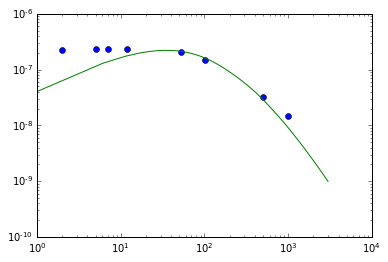

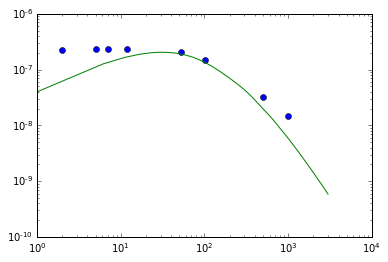

In [57]:
# plt.figure()
# plt.loglog(L_sample, clgg, marker ='o', ls='')
# plt.semilogx(LL,CLgg)

plt.figure()
plt.loglog(L_sample, clkk, marker ='o', ls='')
plt.semilogx(LL,CLkk)

plt.figure()
plt.loglog(L_sample, clkk, marker ='o', ls='')
plt.semilogx(LL,CLkk5)


# plt.figure()
# plt.loglog(L_sample, clkg, marker ='o', ls='')
# plt.semilogx(LL,CLkg)

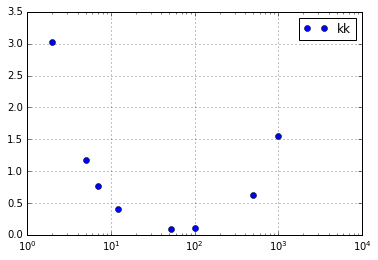

In [58]:
#plt.semilogx(L_sample, clgg/np.interp(L_sample,LL,CLgg)-1, marker ='o', ls='',label='gg')
plt.semilogx(L_sample, clkk/np.interp(L_sample,LL,CLkk5)-1, marker ='o', ls='',label='kk')
#plt.semilogx(L_sample, clkg/np.interp(L_sample,LL,CLkg)-1, marker ='o', ls='',label='kg')

plt.grid()
plt.legend()

In [59]:
from classy import Class

In [60]:
closmo1 = Class()
params = C.Planck2015[1]
params['output'] = 'tCl,lCl'
params['lensing'] = 'yes'
params['perturb_sampling_stepsize']= 0.01
params['tol_perturb_integration']=1.e-6
params['l_switch_limber']=40
closmo1.set(params)
closmo1.compute()
cl_len = closmo1.lensed_cl()

In [61]:
closmo2 = Class()
params2 = C.Planck2015[1]
params2['output'] = 'tCl,lCl'
params2['lensing'] = 'yes'
params2['perturb_sampling_stepsize']= 0.01
params2['tol_perturb_integration']=1.e-6
params2['l_switch_limber']=1.
closmo2.set(params2)
closmo2.compute()
cl_len2 = closmo2.lensed_cl()

In [62]:
plotpath = '/home/nessa/Documents/Projects/LensingBispectrum/CMB-nonlinear/CrossPostBorn/results/plots/vanessa/'

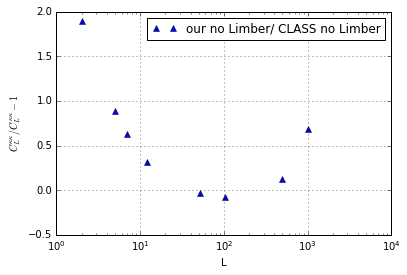

In [63]:
ll = cl_len['ell']
plt.figure()
#plt.semilogx(L_sample, clgg/np.interp(L_sample,LL,CLgg)-1, marker ='o', ls='',label='gg')
#plt.semilogx(L_sample, clkk/np.interp(L_sample,LL,CLkk5)-1, marker ='o', ls='',label='our no Limber/our Limber')
#plt.semilogx(L_sample, clkg/np.interp(L_sample,LL,CLkg)-1, marker ='o', ls='',label='kg')
plt.semilogx(L_sample, clkk/np.interp(L_sample,ll,1./4.*(ll*(ll+1.))**2*cl_len['pp'])-1, marker ='^', ls='',label='our no Limber/ CLASS no Limber')
#plt.semilogx(ll, cl_len['pp']/cl_len2['pp']-1,label='CLASS no Limber/ CLASS Limber')
#plt.semilogx(LL,CLkk/np.interp(LL,ll,1./4.*(ll)**4*cl_len2['pp'])-1,marker ='+')
plt.grid()
plt.ylabel('$C^{\kappa\kappa}_L/C^{\kappa\kappa}_L-1$')
plt.legend()
plt.xlabel('L')
plt.savefig(plotpath+'clkk_comparisons.png')

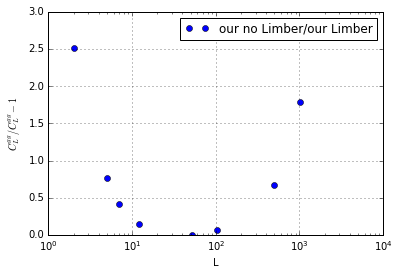

In [64]:
plt.figure()
plt.semilogx(L_sample, clgg/np.interp(L_sample,LL,CLgg)-1, marker ='o', ls='',label='our no Limber/our Limber')
#plt.semilogx(L_sample, clkk/np.interp(L_sample,LL,CLkk5)-1, marker ='o', ls='',label='our post Limber/our Limber')
#plt.semilogx(L_sample, clkg/np.interp(L_sample,LL,CLkg)-1, marker ='o', ls='',label='kg')
#plt.semilogx(L_sample, clkk/np.interp(L_sample,ll,1./4.*(ll)**4*cl_len['pp'])-1, marker ='^', ls='',label='our post Limber/ CLASS post Limber')
#plt.semilogx(ll, cl_len['pp']/cl_len2['pp']-1,label='CLASS post Limber/ CLASS Limber')
#plt.semilogx(LL,CLkk/np.interp(LL,ll,1./4.*(ll)**4*cl_len2['pp'])-1,marker ='+')
plt.grid()
plt.ylabel('$C^{gg}_L/C^{gg}_L-1$')
plt.legend()
plt.xlabel('L')
plt.savefig(plotpath+'clgg_comparisons.png')